In [1]:
from sys import path
path.append('../src/')

import os
import mlflow
import mlflow.keras
import numpy as np
import pickle as pkl
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from skmultilearn.model_selection import iterative_train_test_split

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Fine-tuning'

FILE_BASE_MODEL = '../models/autoencoders_requirements/merged_model_best_branches.h5'

In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def compute_class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes, y)
    class_weights = dict(zip(classes, weights))
    return class_weights

def get_output_counts(output_names, y):
    output_counts = [np.unique(y[:, i], return_counts=True) for i in range(y.shape[1])]
    output_prop = [(unique, counts / counts.sum()) for unique, counts in output_counts]

    dict_counts = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_counts)}
    dict_props = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_prop)}
    return dict_counts, dict_props

# Load Data

In [4]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

y = np.array([mrk.photo_reqs.values() for mrk in mrks])

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)
print(y.shape, y.dtype)

(5763, 224, 224, 3) float32
(5763,) object
(5763, 23) int32


# Load Model

In [5]:
model = load_model(FILE_BASE_MODEL)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
____________________________________________________________________________________________

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Fine-tuning 

In [6]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx] / 255
x_val = x[x_val_idx] / 255

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(4595, 224, 224, 3) float32
(4595, 23) int32
(1168, 224, 224, 3) float32
(1168, 23) int32


In [7]:
output_names = [name for name in model.output_names]
dict_train, dict_train_props = get_output_counts(output_names, y_train)
dict_val, dict_val_props = get_output_counts(output_names, y_val)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Instructions for updating:
Use tf.cast instead.
Train on 4595 samples, validate on 1168 samples
Epoch 1/100
4595/4595 [==============================] - 35s 8ms/step - loss: 12.5769 - blurred_loss: 0.5051 - looking_away_loss: 0.6071 - ink_marked_creased_loss: 0.8927 - unnatural_skin_tone_loss: 0.5574 - too_dark_light_loss: 0.3875 - washed_out_loss: 0.6371 - pixelation_loss: 0.6013 - hair_across_eyes_loss: 0.5159 - eyes_closed_loss: 0.6213 - varied_background_loss: 0.3918 - roll_pitch_yaw_loss: 0.5773 - flash_reflection_on_skin_loss: 0.5366 - red_eyes_loss: 0.5694 - shadows_behind_head_loss: 0.4262 - shadows_across_face_loss: 0.5760 - dark_tinted_lenses_loss: 0.5037 - flash_reflection_on_lenses_loss: 0.5508 - frames_too_heavy_loss: 0.5250 - frame_covering_eyes_loss: 0.5484 - hat_cap_loss: 0.5128 - veil_over_face_loss: 0.4395 - mouth_open_loss: 0.5708 - presence_of_other_faces_or_toys_loss: 0.5175 - blurred_accuracy: 0.6792 - blurred_matthews_correlation_coefficient: 0.3530 - looking_awa

  64/4595 [..............................] - ETA: 23s - loss: 9.6498 - blurred_loss: 0.5094 - looking_away_loss: 0.6568 - ink_marked_creased_loss: 0.1409 - unnatural_skin_tone_loss: 0.4367 - too_dark_light_loss: 0.4300 - washed_out_loss: 0.1871 - pixelation_loss: 0.5352 - hair_across_eyes_loss: 0.5795 - eyes_closed_loss: 0.6193 - varied_background_loss: 0.3548 - roll_pitch_yaw_loss: 0.5338 - flash_reflection_on_skin_loss: 0.4404 - red_eyes_loss: 0.4775 - shadows_behind_head_loss: 0.4821 - shadows_across_face_loss: 0.5283 - dark_tinted_lenses_loss: 0.4256 - flash_reflection_on_lenses_loss: 0.4324 - frames_too_heavy_loss: 0.2482 - frame_covering_eyes_loss: 0.4737 - hat_cap_loss: 0.2730 - veil_over_face_loss: 0.0873 - mouth_open_loss: 0.5719 - presence_of_other_faces_or_toys_loss: 0.2261 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4553 - looking_away_accuracy: 0.5938 - looking_away_matthews_correlation_coefficient: 0.2679 - ink_marked_creased_accuracy: 1.0000 

4595/4595 [==============================] - 25s 5ms/step - loss: 10.6369 - blurred_loss: 0.4813 - looking_away_loss: 0.5701 - ink_marked_creased_loss: 0.8441 - unnatural_skin_tone_loss: 0.4886 - too_dark_light_loss: 0.3160 - washed_out_loss: 0.3254 - pixelation_loss: 0.5938 - hair_across_eyes_loss: 0.4869 - eyes_closed_loss: 0.5701 - varied_background_loss: 0.3235 - roll_pitch_yaw_loss: 0.5715 - flash_reflection_on_skin_loss: 0.4449 - red_eyes_loss: 0.5411 - shadows_behind_head_loss: 0.3847 - shadows_across_face_loss: 0.5453 - dark_tinted_lenses_loss: 0.4073 - flash_reflection_on_lenses_loss: 0.4855 - frames_too_heavy_loss: 0.1723 - frame_covering_eyes_loss: 0.5161 - hat_cap_loss: 0.4451 - veil_over_face_loss: 0.2852 - mouth_open_loss: 0.5341 - presence_of_other_faces_or_toys_loss: 0.3011 - blurred_accuracy: 0.7073 - blurred_matthews_correlation_coefficient: 0.3797 - looking_away_accuracy: 0.7025 - looking_away_matthews_correlation_coefficient: 0.3856 - ink_marked_creased_accuracy: 0.

  64/4595 [..............................] - ETA: 21s - loss: 8.8495 - blurred_loss: 0.4272 - looking_away_loss: 0.5058 - ink_marked_creased_loss: 0.4677 - unnatural_skin_tone_loss: 0.4866 - too_dark_light_loss: 0.1925 - washed_out_loss: 0.0749 - pixelation_loss: 0.5533 - hair_across_eyes_loss: 0.4509 - eyes_closed_loss: 0.4443 - varied_background_loss: 0.3386 - roll_pitch_yaw_loss: 0.6323 - flash_reflection_on_skin_loss: 0.4328 - red_eyes_loss: 0.4861 - shadows_behind_head_loss: 0.3127 - shadows_across_face_loss: 0.5462 - dark_tinted_lenses_loss: 0.3841 - flash_reflection_on_lenses_loss: 0.4531 - frames_too_heavy_loss: 0.0958 - frame_covering_eyes_loss: 0.5049 - hat_cap_loss: 0.3664 - veil_over_face_loss: 0.1341 - mouth_open_loss: 0.4450 - presence_of_other_faces_or_toys_loss: 0.1141 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.5067 - looking_away_accuracy: 0.6719 - looking_away_matthews_correlation_coefficient: 0.4672 - ink_marked_creased_accuracy: 0.0000e

4595/4595 [==============================] - 25s 5ms/step - loss: 10.3908 - blurred_loss: 0.4610 - looking_away_loss: 0.5571 - ink_marked_creased_loss: 0.8591 - unnatural_skin_tone_loss: 0.4884 - too_dark_light_loss: 0.2816 - washed_out_loss: 0.2724 - pixelation_loss: 0.5724 - hair_across_eyes_loss: 0.4855 - eyes_closed_loss: 0.5661 - varied_background_loss: 0.2987 - roll_pitch_yaw_loss: 0.5709 - flash_reflection_on_skin_loss: 0.4321 - red_eyes_loss: 0.5343 - shadows_behind_head_loss: 0.3726 - shadows_across_face_loss: 0.5382 - dark_tinted_lenses_loss: 0.3774 - flash_reflection_on_lenses_loss: 0.4789 - frames_too_heavy_loss: 0.3250 - frame_covering_eyes_loss: 0.5055 - hat_cap_loss: 0.4381 - veil_over_face_loss: 0.2540 - mouth_open_loss: 0.5165 - presence_of_other_faces_or_toys_loss: 0.2022 - blurred_accuracy: 0.7127 - blurred_matthews_correlation_coefficient: 0.4052 - looking_away_accuracy: 0.7047 - looking_away_matthews_correlation_coefficient: 0.3995 - ink_marked_creased_accuracy: 0.

  64/4595 [..............................] - ETA: 21s - loss: 10.1665 - blurred_loss: 0.4742 - looking_away_loss: 0.5927 - ink_marked_creased_loss: 0.3538 - unnatural_skin_tone_loss: 0.6015 - too_dark_light_loss: 0.3373 - washed_out_loss: 0.0880 - pixelation_loss: 0.6198 - hair_across_eyes_loss: 0.4988 - eyes_closed_loss: 0.6055 - varied_background_loss: 0.2697 - roll_pitch_yaw_loss: 0.5707 - flash_reflection_on_skin_loss: 0.4670 - red_eyes_loss: 0.5957 - shadows_behind_head_loss: 0.3576 - shadows_across_face_loss: 0.5585 - dark_tinted_lenses_loss: 0.5077 - flash_reflection_on_lenses_loss: 0.5694 - frames_too_heavy_loss: 0.0963 - frame_covering_eyes_loss: 0.5707 - hat_cap_loss: 0.3736 - veil_over_face_loss: 0.2375 - mouth_open_loss: 0.5983 - presence_of_other_faces_or_toys_loss: 0.2221 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.2554 - looking_away_accuracy: 0.7031 - looking_away_matthews_correlation_coefficient: 0.4529 - ink_marked_creased_accuracy: 0.3438

4595/4595 [==============================] - 25s 5ms/step - loss: 10.3028 - blurred_loss: 0.4609 - looking_away_loss: 0.5507 - ink_marked_creased_loss: 0.7330 - unnatural_skin_tone_loss: 0.4761 - too_dark_light_loss: 0.2972 - washed_out_loss: 0.3813 - pixelation_loss: 0.5723 - hair_across_eyes_loss: 0.4794 - eyes_closed_loss: 0.5475 - varied_background_loss: 0.2971 - roll_pitch_yaw_loss: 0.5732 - flash_reflection_on_skin_loss: 0.4260 - red_eyes_loss: 0.5158 - shadows_behind_head_loss: 0.3769 - shadows_across_face_loss: 0.5305 - dark_tinted_lenses_loss: 0.3563 - flash_reflection_on_lenses_loss: 0.4759 - frames_too_heavy_loss: 0.2943 - frame_covering_eyes_loss: 0.4912 - hat_cap_loss: 0.4410 - veil_over_face_loss: 0.2576 - mouth_open_loss: 0.5240 - presence_of_other_faces_or_toys_loss: 0.2418 - blurred_accuracy: 0.7145 - blurred_matthews_correlation_coefficient: 0.3948 - looking_away_accuracy: 0.7129 - looking_away_matthews_correlation_coefficient: 0.4118 - ink_marked_creased_accuracy: 0.

  64/4595 [..............................] - ETA: 21s - loss: 10.7978 - blurred_loss: 0.5373 - looking_away_loss: 0.5418 - ink_marked_creased_loss: 0.4435 - unnatural_skin_tone_loss: 0.6092 - too_dark_light_loss: 0.2562 - washed_out_loss: 0.1551 - pixelation_loss: 0.5767 - hair_across_eyes_loss: 0.5892 - eyes_closed_loss: 0.5538 - varied_background_loss: 0.5392 - roll_pitch_yaw_loss: 0.5606 - flash_reflection_on_skin_loss: 0.5569 - red_eyes_loss: 0.6228 - shadows_behind_head_loss: 0.5102 - shadows_across_face_loss: 0.5113 - dark_tinted_lenses_loss: 0.4208 - flash_reflection_on_lenses_loss: 0.6216 - frames_too_heavy_loss: 0.4293 - frame_covering_eyes_loss: 0.5973 - hat_cap_loss: 0.4344 - veil_over_face_loss: 0.0679 - mouth_open_loss: 0.5167 - presence_of_other_faces_or_toys_loss: 0.1462 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.3669 - looking_away_accuracy: 0.6406 - looking_away_matthews_correlation_coefficient: 0.2756 - ink_marked_creased_accuracy: 0.0781

4595/4595 [==============================] - 25s 5ms/step - loss: 10.2738 - blurred_loss: 0.4622 - looking_away_loss: 0.5449 - ink_marked_creased_loss: 0.7156 - unnatural_skin_tone_loss: 0.4858 - too_dark_light_loss: 0.3078 - washed_out_loss: 0.3498 - pixelation_loss: 0.5837 - hair_across_eyes_loss: 0.4806 - eyes_closed_loss: 0.5455 - varied_background_loss: 0.3059 - roll_pitch_yaw_loss: 0.5709 - flash_reflection_on_skin_loss: 0.4261 - red_eyes_loss: 0.5076 - shadows_behind_head_loss: 0.3778 - shadows_across_face_loss: 0.5414 - dark_tinted_lenses_loss: 0.3184 - flash_reflection_on_lenses_loss: 0.4850 - frames_too_heavy_loss: 0.3588 - frame_covering_eyes_loss: 0.4881 - hat_cap_loss: 0.4188 - veil_over_face_loss: 0.2300 - mouth_open_loss: 0.5194 - presence_of_other_faces_or_toys_loss: 0.2492 - blurred_accuracy: 0.7232 - blurred_matthews_correlation_coefficient: 0.3948 - looking_away_accuracy: 0.7273 - looking_away_matthews_correlation_coefficient: 0.4219 - ink_marked_creased_accuracy: 0.

  64/4595 [..............................] - ETA: 21s - loss: 10.3720 - blurred_loss: 0.5322 - looking_away_loss: 0.5800 - ink_marked_creased_loss: 0.4737 - unnatural_skin_tone_loss: 0.5880 - too_dark_light_loss: 0.1565 - washed_out_loss: 0.1480 - pixelation_loss: 0.7254 - hair_across_eyes_loss: 0.5825 - eyes_closed_loss: 0.6051 - varied_background_loss: 0.1943 - roll_pitch_yaw_loss: 0.6436 - flash_reflection_on_skin_loss: 0.4235 - red_eyes_loss: 0.6008 - shadows_behind_head_loss: 0.4877 - shadows_across_face_loss: 0.5789 - dark_tinted_lenses_loss: 0.3256 - flash_reflection_on_lenses_loss: 0.5917 - frames_too_heavy_loss: 0.0782 - frame_covering_eyes_loss: 0.6384 - hat_cap_loss: 0.3248 - veil_over_face_loss: 0.5312 - mouth_open_loss: 0.4697 - presence_of_other_faces_or_toys_loss: 0.0920 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5969 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.4454 - ink_marked_creased_accuracy: 0.0469

4595/4595 [==============================] - 25s 5ms/step - loss: 9.5880 - blurred_loss: 0.4522 - looking_away_loss: 0.5325 - ink_marked_creased_loss: 0.7084 - unnatural_skin_tone_loss: 0.4667 - too_dark_light_loss: 0.2922 - washed_out_loss: 0.2655 - pixelation_loss: 0.5686 - hair_across_eyes_loss: 0.4690 - eyes_closed_loss: 0.5276 - varied_background_loss: 0.2745 - roll_pitch_yaw_loss: 0.5713 - flash_reflection_on_skin_loss: 0.4189 - red_eyes_loss: 0.4821 - shadows_behind_head_loss: 0.3585 - shadows_across_face_loss: 0.5275 - dark_tinted_lenses_loss: 0.2728 - flash_reflection_on_lenses_loss: 0.4547 - frames_too_heavy_loss: 0.1353 - frame_covering_eyes_loss: 0.4718 - hat_cap_loss: 0.4054 - veil_over_face_loss: 0.2040 - mouth_open_loss: 0.5128 - presence_of_other_faces_or_toys_loss: 0.2186 - blurred_accuracy: 0.7362 - blurred_matthews_correlation_coefficient: 0.4210 - looking_away_accuracy: 0.7301 - looking_away_matthews_correlation_coefficient: 0.4299 - ink_marked_creased_accuracy: 0.2

  64/4595 [..............................] - ETA: 21s - loss: 8.7314 - blurred_loss: 0.4882 - looking_away_loss: 0.5888 - ink_marked_creased_loss: 0.3804 - unnatural_skin_tone_loss: 0.4573 - too_dark_light_loss: 0.0833 - washed_out_loss: 0.0497 - pixelation_loss: 0.6547 - hair_across_eyes_loss: 0.5083 - eyes_closed_loss: 0.5353 - varied_background_loss: 0.2123 - roll_pitch_yaw_loss: 0.5625 - flash_reflection_on_skin_loss: 0.3695 - red_eyes_loss: 0.3759 - shadows_behind_head_loss: 0.4431 - shadows_across_face_loss: 0.5092 - dark_tinted_lenses_loss: 0.1474 - flash_reflection_on_lenses_loss: 0.4990 - frames_too_heavy_loss: 0.2351 - frame_covering_eyes_loss: 0.3790 - hat_cap_loss: 0.3323 - veil_over_face_loss: 0.0809 - mouth_open_loss: 0.4479 - presence_of_other_faces_or_toys_loss: 0.3914 - blurred_accuracy: 0.6562 - blurred_matthews_correlation_coefficient: 0.3437 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.4740 - ink_marked_creased_accuracy: 0.3438 

4595/4595 [==============================] - 25s 5ms/step - loss: 9.1474 - blurred_loss: 0.4429 - looking_away_loss: 0.5191 - ink_marked_creased_loss: 0.6918 - unnatural_skin_tone_loss: 0.4591 - too_dark_light_loss: 0.2532 - washed_out_loss: 0.2226 - pixelation_loss: 0.5512 - hair_across_eyes_loss: 0.4578 - eyes_closed_loss: 0.5044 - varied_background_loss: 0.2691 - roll_pitch_yaw_loss: 0.5612 - flash_reflection_on_skin_loss: 0.4022 - red_eyes_loss: 0.4621 - shadows_behind_head_loss: 0.3441 - shadows_across_face_loss: 0.5271 - dark_tinted_lenses_loss: 0.2365 - flash_reflection_on_lenses_loss: 0.4633 - frames_too_heavy_loss: 0.0572 - frame_covering_eyes_loss: 0.4659 - hat_cap_loss: 0.3780 - veil_over_face_loss: 0.1916 - mouth_open_loss: 0.4983 - presence_of_other_faces_or_toys_loss: 0.1821 - blurred_accuracy: 0.7382 - blurred_matthews_correlation_coefficient: 0.4363 - looking_away_accuracy: 0.7493 - looking_away_matthews_correlation_coefficient: 0.4601 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 8.4619 - blurred_loss: 0.4310 - looking_away_loss: 0.4827 - ink_marked_creased_loss: 0.3833 - unnatural_skin_tone_loss: 0.4057 - too_dark_light_loss: 0.2988 - washed_out_loss: 0.1768 - pixelation_loss: 0.6196 - hair_across_eyes_loss: 0.4005 - eyes_closed_loss: 0.5039 - varied_background_loss: 0.3094 - roll_pitch_yaw_loss: 0.5600 - flash_reflection_on_skin_loss: 0.3858 - red_eyes_loss: 0.3634 - shadows_behind_head_loss: 0.4258 - shadows_across_face_loss: 0.4761 - dark_tinted_lenses_loss: 0.2756 - flash_reflection_on_lenses_loss: 0.4148 - frames_too_heavy_loss: 0.0024 - frame_covering_eyes_loss: 0.4939 - hat_cap_loss: 0.3932 - veil_over_face_loss: 0.0453 - mouth_open_loss: 0.5134 - presence_of_other_faces_or_toys_loss: 0.1006 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5295 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5903 - ink_marked_creased_accuracy: 0.2969 

4595/4595 [==============================] - 25s 5ms/step - loss: 10.6340 - blurred_loss: 0.4634 - looking_away_loss: 0.5396 - ink_marked_creased_loss: 0.7425 - unnatural_skin_tone_loss: 0.4909 - too_dark_light_loss: 0.3367 - washed_out_loss: 0.4093 - pixelation_loss: 0.5584 - hair_across_eyes_loss: 0.4926 - eyes_closed_loss: 0.5325 - varied_background_loss: 0.3162 - roll_pitch_yaw_loss: 0.5700 - flash_reflection_on_skin_loss: 0.4494 - red_eyes_loss: 0.4887 - shadows_behind_head_loss: 0.4059 - shadows_across_face_loss: 0.5428 - dark_tinted_lenses_loss: 0.2946 - flash_reflection_on_lenses_loss: 0.4840 - frames_too_heavy_loss: 0.5051 - frame_covering_eyes_loss: 0.4853 - hat_cap_loss: 0.4396 - veil_over_face_loss: 0.1987 - mouth_open_loss: 0.5175 - presence_of_other_faces_or_toys_loss: 0.3736 - blurred_accuracy: 0.7221 - blurred_matthews_correlation_coefficient: 0.3994 - looking_away_accuracy: 0.7388 - looking_away_matthews_correlation_coefficient: 0.4401 - ink_marked_creased_accuracy: 0.

  64/4595 [..............................] - ETA: 22s - loss: 9.9964 - blurred_loss: 0.3802 - looking_away_loss: 0.4876 - ink_marked_creased_loss: 0.2457 - unnatural_skin_tone_loss: 0.4372 - too_dark_light_loss: 0.3829 - washed_out_loss: 0.2521 - pixelation_loss: 0.4961 - hair_across_eyes_loss: 0.5096 - eyes_closed_loss: 0.4933 - varied_background_loss: 0.3830 - roll_pitch_yaw_loss: 0.5128 - flash_reflection_on_skin_loss: 0.5082 - red_eyes_loss: 0.5605 - shadows_behind_head_loss: 0.4137 - shadows_across_face_loss: 0.4386 - dark_tinted_lenses_loss: 0.1936 - flash_reflection_on_lenses_loss: 0.3814 - frames_too_heavy_loss: 1.0855 - frame_covering_eyes_loss: 0.4060 - hat_cap_loss: 0.4443 - veil_over_face_loss: 0.1713 - mouth_open_loss: 0.5693 - presence_of_other_faces_or_toys_loss: 0.2434 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.4583 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5039 - ink_marked_creased_accuracy: 0.9844 

4595/4595 [==============================] - 25s 5ms/step - loss: 10.0133 - blurred_loss: 0.4566 - looking_away_loss: 0.5367 - ink_marked_creased_loss: 0.7394 - unnatural_skin_tone_loss: 0.4923 - too_dark_light_loss: 0.2931 - washed_out_loss: 0.2847 - pixelation_loss: 0.5594 - hair_across_eyes_loss: 0.4868 - eyes_closed_loss: 0.5255 - varied_background_loss: 0.3260 - roll_pitch_yaw_loss: 0.5742 - flash_reflection_on_skin_loss: 0.4384 - red_eyes_loss: 0.4958 - shadows_behind_head_loss: 0.3940 - shadows_across_face_loss: 0.5344 - dark_tinted_lenses_loss: 0.2468 - flash_reflection_on_lenses_loss: 0.4750 - frames_too_heavy_loss: 0.2503 - frame_covering_eyes_loss: 0.4819 - hat_cap_loss: 0.4428 - veil_over_face_loss: 0.1830 - mouth_open_loss: 0.5125 - presence_of_other_faces_or_toys_loss: 0.2786 - blurred_accuracy: 0.7208 - blurred_matthews_correlation_coefficient: 0.4079 - looking_away_accuracy: 0.7332 - looking_away_matthews_correlation_coefficient: 0.4300 - ink_marked_creased_accuracy: 0.

  64/4595 [..............................] - ETA: 21s - loss: 9.0737 - blurred_loss: 0.5235 - looking_away_loss: 0.4980 - ink_marked_creased_loss: 0.4270 - unnatural_skin_tone_loss: 0.4244 - too_dark_light_loss: 0.3863 - washed_out_loss: 0.1281 - pixelation_loss: 0.4786 - hair_across_eyes_loss: 0.5034 - eyes_closed_loss: 0.5177 - varied_background_loss: 0.2166 - roll_pitch_yaw_loss: 0.4785 - flash_reflection_on_skin_loss: 0.5148 - red_eyes_loss: 0.4440 - shadows_behind_head_loss: 0.3349 - shadows_across_face_loss: 0.6742 - dark_tinted_lenses_loss: 0.1766 - flash_reflection_on_lenses_loss: 0.3228 - frames_too_heavy_loss: 0.2390 - frame_covering_eyes_loss: 0.5176 - hat_cap_loss: 0.4266 - veil_over_face_loss: 0.0729 - mouth_open_loss: 0.5607 - presence_of_other_faces_or_toys_loss: 0.2076 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.2733 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4389 - ink_marked_creased_accuracy: 0.1406 

4595/4595 [==============================] - 25s 5ms/step - loss: 9.2067 - blurred_loss: 0.4395 - looking_away_loss: 0.5090 - ink_marked_creased_loss: 0.7032 - unnatural_skin_tone_loss: 0.4606 - too_dark_light_loss: 0.2495 - washed_out_loss: 0.2248 - pixelation_loss: 0.5478 - hair_across_eyes_loss: 0.4542 - eyes_closed_loss: 0.4969 - varied_background_loss: 0.2908 - roll_pitch_yaw_loss: 0.5638 - flash_reflection_on_skin_loss: 0.4071 - red_eyes_loss: 0.4553 - shadows_behind_head_loss: 0.3590 - shadows_across_face_loss: 0.5216 - dark_tinted_lenses_loss: 0.1958 - flash_reflection_on_lenses_loss: 0.4582 - frames_too_heavy_loss: 0.0927 - frame_covering_eyes_loss: 0.4637 - hat_cap_loss: 0.3743 - veil_over_face_loss: 0.1942 - mouth_open_loss: 0.5064 - presence_of_other_faces_or_toys_loss: 0.2358 - blurred_accuracy: 0.7295 - blurred_matthews_correlation_coefficient: 0.4138 - looking_away_accuracy: 0.7526 - looking_away_matthews_correlation_coefficient: 0.4719 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 7.8540 - blurred_loss: 0.3683 - looking_away_loss: 0.3467 - ink_marked_creased_loss: 0.3650 - unnatural_skin_tone_loss: 0.5113 - too_dark_light_loss: 0.2205 - washed_out_loss: 0.0747 - pixelation_loss: 0.5696 - hair_across_eyes_loss: 0.4493 - eyes_closed_loss: 0.3170 - varied_background_loss: 0.2494 - roll_pitch_yaw_loss: 0.5794 - flash_reflection_on_skin_loss: 0.4786 - red_eyes_loss: 0.2696 - shadows_behind_head_loss: 0.4035 - shadows_across_face_loss: 0.3655 - dark_tinted_lenses_loss: 0.0803 - flash_reflection_on_lenses_loss: 0.4688 - frames_too_heavy_loss: 0.1659 - frame_covering_eyes_loss: 0.4112 - hat_cap_loss: 0.1914 - veil_over_face_loss: 0.2456 - mouth_open_loss: 0.6396 - presence_of_other_faces_or_toys_loss: 0.0830 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5349 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7563 - ink_marked_creased_accuracy: 0.3750 

4595/4595 [==============================] - 25s 5ms/step - loss: 8.9589 - blurred_loss: 0.4262 - looking_away_loss: 0.5051 - ink_marked_creased_loss: 0.6944 - unnatural_skin_tone_loss: 0.4650 - too_dark_light_loss: 0.2534 - washed_out_loss: 0.2235 - pixelation_loss: 0.5320 - hair_across_eyes_loss: 0.4603 - eyes_closed_loss: 0.4859 - varied_background_loss: 0.2579 - roll_pitch_yaw_loss: 0.5621 - flash_reflection_on_skin_loss: 0.4047 - red_eyes_loss: 0.4472 - shadows_behind_head_loss: 0.3576 - shadows_across_face_loss: 0.5191 - dark_tinted_lenses_loss: 0.1550 - flash_reflection_on_lenses_loss: 0.4255 - frames_too_heavy_loss: 0.0871 - frame_covering_eyes_loss: 0.4563 - hat_cap_loss: 0.3693 - veil_over_face_loss: 0.1704 - mouth_open_loss: 0.4991 - presence_of_other_faces_or_toys_loss: 0.2126 - blurred_accuracy: 0.7539 - blurred_matthews_correlation_coefficient: 0.4465 - looking_away_accuracy: 0.7591 - looking_away_matthews_correlation_coefficient: 0.4798 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 7.5830 - blurred_loss: 0.3509 - looking_away_loss: 0.4682 - ink_marked_creased_loss: 0.4205 - unnatural_skin_tone_loss: 0.4589 - too_dark_light_loss: 0.2166 - washed_out_loss: 0.2112 - pixelation_loss: 0.4082 - hair_across_eyes_loss: 0.3835 - eyes_closed_loss: 0.4715 - varied_background_loss: 0.1975 - roll_pitch_yaw_loss: 0.5438 - flash_reflection_on_skin_loss: 0.3787 - red_eyes_loss: 0.3708 - shadows_behind_head_loss: 0.3382 - shadows_across_face_loss: 0.5032 - dark_tinted_lenses_loss: 0.0641 - flash_reflection_on_lenses_loss: 0.5083 - frames_too_heavy_loss: 0.0926 - frame_covering_eyes_loss: 0.3511 - hat_cap_loss: 0.2876 - veil_over_face_loss: 0.0400 - mouth_open_loss: 0.4208 - presence_of_other_faces_or_toys_loss: 0.0969 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5536 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.4476 - ink_marked_creased_accuracy: 0.2188 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.6383 - blurred_loss: 0.4218 - looking_away_loss: 0.4943 - ink_marked_creased_loss: 0.6762 - unnatural_skin_tone_loss: 0.4474 - too_dark_light_loss: 0.2385 - washed_out_loss: 0.2011 - pixelation_loss: 0.5324 - hair_across_eyes_loss: 0.4391 - eyes_closed_loss: 0.4746 - varied_background_loss: 0.2476 - roll_pitch_yaw_loss: 0.5637 - flash_reflection_on_skin_loss: 0.3999 - red_eyes_loss: 0.4346 - shadows_behind_head_loss: 0.3528 - shadows_across_face_loss: 0.5145 - dark_tinted_lenses_loss: 0.1392 - flash_reflection_on_lenses_loss: 0.4171 - frames_too_heavy_loss: 0.0617 - frame_covering_eyes_loss: 0.4487 - hat_cap_loss: 0.3229 - veil_over_face_loss: 0.1425 - mouth_open_loss: 0.4927 - presence_of_other_faces_or_toys_loss: 0.1751 - blurred_accuracy: 0.7530 - blurred_matthews_correlation_coefficient: 0.4479 - looking_away_accuracy: 0.7678 - looking_away_matthews_correlation_coefficient: 0.4991 - ink_marked_creased_accuracy: 0.2

  64/4595 [..............................] - ETA: 21s - loss: 6.9642 - blurred_loss: 0.5902 - looking_away_loss: 0.4237 - ink_marked_creased_loss: 0.2597 - unnatural_skin_tone_loss: 0.3689 - too_dark_light_loss: 0.1232 - washed_out_loss: 0.1058 - pixelation_loss: 0.3438 - hair_across_eyes_loss: 0.3980 - eyes_closed_loss: 0.3826 - varied_background_loss: 0.0906 - roll_pitch_yaw_loss: 0.6493 - flash_reflection_on_skin_loss: 0.4650 - red_eyes_loss: 0.3586 - shadows_behind_head_loss: 0.2252 - shadows_across_face_loss: 0.5785 - dark_tinted_lenses_loss: 0.0864 - flash_reflection_on_lenses_loss: 0.2361 - frames_too_heavy_loss: 0.0721 - frame_covering_eyes_loss: 0.3645 - hat_cap_loss: 0.2765 - veil_over_face_loss: 0.0672 - mouth_open_loss: 0.4148 - presence_of_other_faces_or_toys_loss: 0.0836 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4647 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6281 - ink_marked_creased_accuracy: 0.7500 

4595/4595 [==============================] - 25s 5ms/step - loss: 8.4485 - blurred_loss: 0.4134 - looking_away_loss: 0.4811 - ink_marked_creased_loss: 0.6797 - unnatural_skin_tone_loss: 0.4479 - too_dark_light_loss: 0.2361 - washed_out_loss: 0.1833 - pixelation_loss: 0.5316 - hair_across_eyes_loss: 0.4340 - eyes_closed_loss: 0.4557 - varied_background_loss: 0.2510 - roll_pitch_yaw_loss: 0.5587 - flash_reflection_on_skin_loss: 0.3901 - red_eyes_loss: 0.4122 - shadows_behind_head_loss: 0.3432 - shadows_across_face_loss: 0.5105 - dark_tinted_lenses_loss: 0.1206 - flash_reflection_on_lenses_loss: 0.4072 - frames_too_heavy_loss: 0.0396 - frame_covering_eyes_loss: 0.4399 - hat_cap_loss: 0.3198 - veil_over_face_loss: 0.1398 - mouth_open_loss: 0.4880 - presence_of_other_faces_or_toys_loss: 0.1612 - blurred_accuracy: 0.7678 - blurred_matthews_correlation_coefficient: 0.4601 - looking_away_accuracy: 0.7682 - looking_away_matthews_correlation_coefficient: 0.4958 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 7.6531 - blurred_loss: 0.3840 - looking_away_loss: 0.5638 - ink_marked_creased_loss: 0.2854 - unnatural_skin_tone_loss: 0.4145 - too_dark_light_loss: 0.1452 - washed_out_loss: 0.0951 - pixelation_loss: 0.3019 - hair_across_eyes_loss: 0.5084 - eyes_closed_loss: 0.4241 - varied_background_loss: 0.1844 - roll_pitch_yaw_loss: 0.5143 - flash_reflection_on_skin_loss: 0.3830 - red_eyes_loss: 0.4548 - shadows_behind_head_loss: 0.3115 - shadows_across_face_loss: 0.5276 - dark_tinted_lenses_loss: 0.0840 - flash_reflection_on_lenses_loss: 0.4228 - frames_too_heavy_loss: 0.1200 - frame_covering_eyes_loss: 0.4113 - hat_cap_loss: 0.3086 - veil_over_face_loss: 0.1060 - mouth_open_loss: 0.4543 - presence_of_other_faces_or_toys_loss: 0.2482 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.4864 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4215 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 25s 5ms/step - loss: 8.5554 - blurred_loss: 0.4200 - looking_away_loss: 0.4925 - ink_marked_creased_loss: 0.6362 - unnatural_skin_tone_loss: 0.4510 - too_dark_light_loss: 0.2383 - washed_out_loss: 0.1549 - pixelation_loss: 0.5286 - hair_across_eyes_loss: 0.4290 - eyes_closed_loss: 0.4666 - varied_background_loss: 0.2366 - roll_pitch_yaw_loss: 0.5604 - flash_reflection_on_skin_loss: 0.3902 - red_eyes_loss: 0.4177 - shadows_behind_head_loss: 0.3399 - shadows_across_face_loss: 0.5186 - dark_tinted_lenses_loss: 0.1501 - flash_reflection_on_lenses_loss: 0.4160 - frames_too_heavy_loss: 0.0626 - frame_covering_eyes_loss: 0.4421 - hat_cap_loss: 0.3349 - veil_over_face_loss: 0.1385 - mouth_open_loss: 0.4844 - presence_of_other_faces_or_toys_loss: 0.2498 - blurred_accuracy: 0.7647 - blurred_matthews_correlation_coefficient: 0.4586 - looking_away_accuracy: 0.7665 - looking_away_matthews_correlation_coefficient: 0.4900 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 8.1427 - blurred_loss: 0.5638 - looking_away_loss: 0.3916 - ink_marked_creased_loss: 0.1723 - unnatural_skin_tone_loss: 0.5798 - too_dark_light_loss: 0.1361 - washed_out_loss: 0.1615 - pixelation_loss: 0.3597 - hair_across_eyes_loss: 0.4301 - eyes_closed_loss: 0.4807 - varied_background_loss: 0.1655 - roll_pitch_yaw_loss: 0.5954 - flash_reflection_on_skin_loss: 0.5856 - red_eyes_loss: 0.4715 - shadows_behind_head_loss: 0.2466 - shadows_across_face_loss: 0.5746 - dark_tinted_lenses_loss: 0.1513 - flash_reflection_on_lenses_loss: 0.5131 - frames_too_heavy_loss: 0.1256 - frame_covering_eyes_loss: 0.4589 - hat_cap_loss: 0.2686 - veil_over_face_loss: 0.0704 - mouth_open_loss: 0.3139 - presence_of_other_faces_or_toys_loss: 0.3259 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.1632 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6601 - ink_marked_creased_accuracy: 1.0000 

4595/4595 [==============================] - 25s 5ms/step - loss: 8.9026 - blurred_loss: 0.4280 - looking_away_loss: 0.4775 - ink_marked_creased_loss: 0.9208 - unnatural_skin_tone_loss: 0.4650 - too_dark_light_loss: 0.2407 - washed_out_loss: 0.2442 - pixelation_loss: 0.5322 - hair_across_eyes_loss: 0.4330 - eyes_closed_loss: 0.4480 - varied_background_loss: 0.2670 - roll_pitch_yaw_loss: 0.5666 - flash_reflection_on_skin_loss: 0.3956 - red_eyes_loss: 0.4048 - shadows_behind_head_loss: 0.3482 - shadows_across_face_loss: 0.5210 - dark_tinted_lenses_loss: 0.1243 - flash_reflection_on_lenses_loss: 0.4125 - frames_too_heavy_loss: 0.0543 - frame_covering_eyes_loss: 0.4376 - hat_cap_loss: 0.3192 - veil_over_face_loss: 0.1338 - mouth_open_loss: 0.4960 - presence_of_other_faces_or_toys_loss: 0.2321 - blurred_accuracy: 0.7617 - blurred_matthews_correlation_coefficient: 0.4561 - looking_away_accuracy: 0.7717 - looking_away_matthews_correlation_coefficient: 0.5038 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 9.7231 - blurred_loss: 0.3563 - looking_away_loss: 0.4160 - ink_marked_creased_loss: 1.4338 - unnatural_skin_tone_loss: 0.3158 - too_dark_light_loss: 0.0887 - washed_out_loss: 0.0641 - pixelation_loss: 0.4514 - hair_across_eyes_loss: 0.3506 - eyes_closed_loss: 0.4450 - varied_background_loss: 0.2015 - roll_pitch_yaw_loss: 0.5246 - flash_reflection_on_skin_loss: 0.3517 - red_eyes_loss: 0.3723 - shadows_behind_head_loss: 0.3006 - shadows_across_face_loss: 0.4551 - dark_tinted_lenses_loss: 0.5163 - flash_reflection_on_lenses_loss: 0.6190 - frames_too_heavy_loss: 0.0081 - frame_covering_eyes_loss: 0.3323 - hat_cap_loss: 0.2496 - veil_over_face_loss: 0.5391 - mouth_open_loss: 0.5217 - presence_of_other_faces_or_toys_loss: 0.8094 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.4633 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.5562 - ink_marked_creased_accuracy: 0.0938 

4595/4595 [==============================] - 25s 5ms/step - loss: 8.6897 - blurred_loss: 0.4093 - looking_away_loss: 0.4819 - ink_marked_creased_loss: 0.6634 - unnatural_skin_tone_loss: 0.4502 - too_dark_light_loss: 0.2190 - washed_out_loss: 0.2689 - pixelation_loss: 0.5362 - hair_across_eyes_loss: 0.4340 - eyes_closed_loss: 0.4513 - varied_background_loss: 0.2621 - roll_pitch_yaw_loss: 0.5586 - flash_reflection_on_skin_loss: 0.4058 - red_eyes_loss: 0.4142 - shadows_behind_head_loss: 0.3542 - shadows_across_face_loss: 0.5093 - dark_tinted_lenses_loss: 0.1396 - flash_reflection_on_lenses_loss: 0.4119 - frames_too_heavy_loss: 0.1195 - frame_covering_eyes_loss: 0.4372 - hat_cap_loss: 0.3038 - veil_over_face_loss: 0.1320 - mouth_open_loss: 0.4865 - presence_of_other_faces_or_toys_loss: 0.2393 - blurred_accuracy: 0.7684 - blurred_matthews_correlation_coefficient: 0.4603 - looking_away_accuracy: 0.7682 - looking_away_matthews_correlation_coefficient: 0.4948 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 21s - loss: 6.9255 - blurred_loss: 0.3994 - looking_away_loss: 0.4401 - ink_marked_creased_loss: 0.3258 - unnatural_skin_tone_loss: 0.4687 - too_dark_light_loss: 0.1315 - washed_out_loss: 0.0959 - pixelation_loss: 0.6640 - hair_across_eyes_loss: 0.2876 - eyes_closed_loss: 0.2869 - varied_background_loss: 0.3740 - roll_pitch_yaw_loss: 0.5952 - flash_reflection_on_skin_loss: 0.3614 - red_eyes_loss: 0.2912 - shadows_behind_head_loss: 0.2900 - shadows_across_face_loss: 0.4559 - dark_tinted_lenses_loss: 0.0447 - flash_reflection_on_lenses_loss: 0.3373 - frames_too_heavy_loss: 0.0552 - frame_covering_eyes_loss: 0.3383 - hat_cap_loss: 0.1709 - veil_over_face_loss: 0.0197 - mouth_open_loss: 0.3572 - presence_of_other_faces_or_toys_loss: 0.1346 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5575 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6144 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 25s 5ms/step - loss: 8.1770 - blurred_loss: 0.4109 - looking_away_loss: 0.4710 - ink_marked_creased_loss: 0.6273 - unnatural_skin_tone_loss: 0.4380 - too_dark_light_loss: 0.2262 - washed_out_loss: 0.1837 - pixelation_loss: 0.5082 - hair_across_eyes_loss: 0.4152 - eyes_closed_loss: 0.4368 - varied_background_loss: 0.2437 - roll_pitch_yaw_loss: 0.5559 - flash_reflection_on_skin_loss: 0.3825 - red_eyes_loss: 0.3905 - shadows_behind_head_loss: 0.3335 - shadows_across_face_loss: 0.5066 - dark_tinted_lenses_loss: 0.1032 - flash_reflection_on_lenses_loss: 0.3796 - frames_too_heavy_loss: 0.0411 - frame_covering_eyes_loss: 0.4252 - hat_cap_loss: 0.2868 - veil_over_face_loss: 0.1224 - mouth_open_loss: 0.4754 - presence_of_other_faces_or_toys_loss: 0.2063 - blurred_accuracy: 0.7597 - blurred_matthews_correlation_coefficient: 0.4651 - looking_away_accuracy: 0.7789 - looking_away_matthews_correlation_coefficient: 0.5158 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 7.0447 - blurred_loss: 0.2843 - looking_away_loss: 0.5601 - ink_marked_creased_loss: 0.1491 - unnatural_skin_tone_loss: 0.3584 - too_dark_light_loss: 0.2186 - washed_out_loss: 0.0494 - pixelation_loss: 0.4591 - hair_across_eyes_loss: 0.3423 - eyes_closed_loss: 0.4114 - varied_background_loss: 0.4212 - roll_pitch_yaw_loss: 0.5512 - flash_reflection_on_skin_loss: 0.3119 - red_eyes_loss: 0.3007 - shadows_behind_head_loss: 0.3856 - shadows_across_face_loss: 0.4834 - dark_tinted_lenses_loss: 0.1218 - flash_reflection_on_lenses_loss: 0.3986 - frames_too_heavy_loss: 0.0202 - frame_covering_eyes_loss: 0.3480 - hat_cap_loss: 0.2294 - veil_over_face_loss: 0.0538 - mouth_open_loss: 0.5188 - presence_of_other_faces_or_toys_loss: 0.0673 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.0601 - looking_away_accuracy: 0.5625 - looking_away_matthews_correlation_coefficient: 0.1383 - ink_marked_creased_accuracy: 1.0000 

4595/4595 [==============================] - 25s 5ms/step - loss: 7.9314 - blurred_loss: 0.3985 - looking_away_loss: 0.4565 - ink_marked_creased_loss: 0.6856 - unnatural_skin_tone_loss: 0.4325 - too_dark_light_loss: 0.2114 - washed_out_loss: 0.1486 - pixelation_loss: 0.5212 - hair_across_eyes_loss: 0.4054 - eyes_closed_loss: 0.4208 - varied_background_loss: 0.2252 - roll_pitch_yaw_loss: 0.5593 - flash_reflection_on_skin_loss: 0.3725 - red_eyes_loss: 0.3805 - shadows_behind_head_loss: 0.3289 - shadows_across_face_loss: 0.4938 - dark_tinted_lenses_loss: 0.0812 - flash_reflection_on_lenses_loss: 0.3719 - frames_too_heavy_loss: 0.0185 - frame_covering_eyes_loss: 0.4168 - hat_cap_loss: 0.2473 - veil_over_face_loss: 0.1132 - mouth_open_loss: 0.4668 - presence_of_other_faces_or_toys_loss: 0.1822 - blurred_accuracy: 0.7811 - blurred_matthews_correlation_coefficient: 0.4867 - looking_away_accuracy: 0.7800 - looking_away_matthews_correlation_coefficient: 0.5191 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 7.7524 - blurred_loss: 0.3584 - looking_away_loss: 0.5458 - ink_marked_creased_loss: 0.2934 - unnatural_skin_tone_loss: 0.6273 - too_dark_light_loss: 0.1117 - washed_out_loss: 0.0995 - pixelation_loss: 0.3387 - hair_across_eyes_loss: 0.3756 - eyes_closed_loss: 0.5601 - varied_background_loss: 0.1884 - roll_pitch_yaw_loss: 0.5775 - flash_reflection_on_skin_loss: 0.4556 - red_eyes_loss: 0.4808 - shadows_behind_head_loss: 0.4832 - shadows_across_face_loss: 0.4054 - dark_tinted_lenses_loss: 0.0440 - flash_reflection_on_lenses_loss: 0.3408 - frames_too_heavy_loss: 1.4949e-04 - frame_covering_eyes_loss: 0.4555 - hat_cap_loss: 0.2037 - veil_over_face_loss: 0.0364 - mouth_open_loss: 0.3783 - presence_of_other_faces_or_toys_loss: 0.3925 - blurred_accuracy: 0.8750 - blurred_matthews_correlation_coefficient: 0.6695 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5671 - ink_marked_creased_accuracy: 0.7

4595/4595 [==============================] - 25s 5ms/step - loss: 7.6830 - blurred_loss: 0.3921 - looking_away_loss: 0.4510 - ink_marked_creased_loss: 0.6088 - unnatural_skin_tone_loss: 0.4260 - too_dark_light_loss: 0.2027 - washed_out_loss: 0.1208 - pixelation_loss: 0.5005 - hair_across_eyes_loss: 0.3990 - eyes_closed_loss: 0.4146 - varied_background_loss: 0.2314 - roll_pitch_yaw_loss: 0.5561 - flash_reflection_on_skin_loss: 0.3722 - red_eyes_loss: 0.3699 - shadows_behind_head_loss: 0.3221 - shadows_across_face_loss: 0.5017 - dark_tinted_lenses_loss: 0.0750 - flash_reflection_on_lenses_loss: 0.3625 - frames_too_heavy_loss: 0.0228 - frame_covering_eyes_loss: 0.4134 - hat_cap_loss: 0.2339 - veil_over_face_loss: 0.0964 - mouth_open_loss: 0.4661 - presence_of_other_faces_or_toys_loss: 0.1443 - blurred_accuracy: 0.7835 - blurred_matthews_correlation_coefficient: 0.4808 - looking_away_accuracy: 0.7913 - looking_away_matthews_correlation_coefficient: 0.5344 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 7.8685 - blurred_loss: 0.5159 - looking_away_loss: 0.3965 - ink_marked_creased_loss: 0.2284 - unnatural_skin_tone_loss: 0.3819 - too_dark_light_loss: 0.1704 - washed_out_loss: 0.9862 - pixelation_loss: 0.5594 - hair_across_eyes_loss: 0.4050 - eyes_closed_loss: 0.3251 - varied_background_loss: 0.2785 - roll_pitch_yaw_loss: 0.4438 - flash_reflection_on_skin_loss: 0.3644 - red_eyes_loss: 0.2898 - shadows_behind_head_loss: 0.3519 - shadows_across_face_loss: 0.5008 - dark_tinted_lenses_loss: 0.0074 - flash_reflection_on_lenses_loss: 0.4086 - frames_too_heavy_loss: 0.0022 - frame_covering_eyes_loss: 0.3710 - hat_cap_loss: 0.1503 - veil_over_face_loss: 0.0779 - mouth_open_loss: 0.5648 - presence_of_other_faces_or_toys_loss: 0.0880 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.4430 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.6102 - ink_marked_creased_accuracy: 0.8281 

4595/4595 [==============================] - 25s 5ms/step - loss: 7.5810 - blurred_loss: 0.3906 - looking_away_loss: 0.4375 - ink_marked_creased_loss: 0.6521 - unnatural_skin_tone_loss: 0.4148 - too_dark_light_loss: 0.1982 - washed_out_loss: 0.1192 - pixelation_loss: 0.4976 - hair_across_eyes_loss: 0.3958 - eyes_closed_loss: 0.4030 - varied_background_loss: 0.2206 - roll_pitch_yaw_loss: 0.5514 - flash_reflection_on_skin_loss: 0.3668 - red_eyes_loss: 0.3544 - shadows_behind_head_loss: 0.3185 - shadows_across_face_loss: 0.4892 - dark_tinted_lenses_loss: 0.0645 - flash_reflection_on_lenses_loss: 0.3502 - frames_too_heavy_loss: 0.0135 - frame_covering_eyes_loss: 0.3983 - hat_cap_loss: 0.2203 - veil_over_face_loss: 0.0895 - mouth_open_loss: 0.4646 - presence_of_other_faces_or_toys_loss: 0.1656 - blurred_accuracy: 0.7865 - blurred_matthews_correlation_coefficient: 0.4737 - looking_away_accuracy: 0.7952 - looking_away_matthews_correlation_coefficient: 0.5520 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 6.5664 - blurred_loss: 0.4269 - looking_away_loss: 0.4095 - ink_marked_creased_loss: 0.2502 - unnatural_skin_tone_loss: 0.3424 - too_dark_light_loss: 0.3656 - washed_out_loss: 0.0378 - pixelation_loss: 0.4018 - hair_across_eyes_loss: 0.4686 - eyes_closed_loss: 0.3532 - varied_background_loss: 0.2329 - roll_pitch_yaw_loss: 0.4293 - flash_reflection_on_skin_loss: 0.3208 - red_eyes_loss: 0.2742 - shadows_behind_head_loss: 0.3536 - shadows_across_face_loss: 0.4505 - dark_tinted_lenses_loss: 0.0088 - flash_reflection_on_lenses_loss: 0.2600 - frames_too_heavy_loss: 0.0029 - frame_covering_eyes_loss: 0.3474 - hat_cap_loss: 0.1772 - veil_over_face_loss: 0.0520 - mouth_open_loss: 0.4461 - presence_of_other_faces_or_toys_loss: 0.1544 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.5092 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5427 - ink_marked_creased_accuracy: 0.7031 

4595/4595 [==============================] - 25s 5ms/step - loss: 7.7034 - blurred_loss: 0.3877 - looking_away_loss: 0.4447 - ink_marked_creased_loss: 0.5971 - unnatural_skin_tone_loss: 0.4285 - too_dark_light_loss: 0.2013 - washed_out_loss: 0.0978 - pixelation_loss: 0.5045 - hair_across_eyes_loss: 0.3943 - eyes_closed_loss: 0.4081 - varied_background_loss: 0.2314 - roll_pitch_yaw_loss: 0.5524 - flash_reflection_on_skin_loss: 0.3774 - red_eyes_loss: 0.3564 - shadows_behind_head_loss: 0.3283 - shadows_across_face_loss: 0.4925 - dark_tinted_lenses_loss: 0.0702 - flash_reflection_on_lenses_loss: 0.3613 - frames_too_heavy_loss: 0.1520 - frame_covering_eyes_loss: 0.3993 - hat_cap_loss: 0.2210 - veil_over_face_loss: 0.0952 - mouth_open_loss: 0.4639 - presence_of_other_faces_or_toys_loss: 0.1412 - blurred_accuracy: 0.7872 - blurred_matthews_correlation_coefficient: 0.4906 - looking_away_accuracy: 0.7937 - looking_away_matthews_correlation_coefficient: 0.5476 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 21s - loss: 9.5034 - blurred_loss: 0.5813 - looking_away_loss: 0.4654 - ink_marked_creased_loss: 0.3317 - unnatural_skin_tone_loss: 0.5562 - too_dark_light_loss: 0.3809 - washed_out_loss: 0.4687 - pixelation_loss: 0.4662 - hair_across_eyes_loss: 0.3515 - eyes_closed_loss: 0.5068 - varied_background_loss: 0.4165 - roll_pitch_yaw_loss: 0.5772 - flash_reflection_on_skin_loss: 0.4410 - red_eyes_loss: 0.5185 - shadows_behind_head_loss: 0.2848 - shadows_across_face_loss: 0.4188 - dark_tinted_lenses_loss: 0.0788 - flash_reflection_on_lenses_loss: 0.5729 - frames_too_heavy_loss: 0.5959 - frame_covering_eyes_loss: 0.4748 - hat_cap_loss: 0.2913 - veil_over_face_loss: 0.0411 - mouth_open_loss: 0.5364 - presence_of_other_faces_or_toys_loss: 0.1466 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.2653 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.4547 - ink_marked_creased_accuracy: 0.4844 

4595/4595 [==============================] - 25s 5ms/step - loss: 8.2625 - blurred_loss: 0.4056 - looking_away_loss: 0.4576 - ink_marked_creased_loss: 0.6263 - unnatural_skin_tone_loss: 0.4543 - too_dark_light_loss: 0.2278 - washed_out_loss: 0.1951 - pixelation_loss: 0.5210 - hair_across_eyes_loss: 0.4054 - eyes_closed_loss: 0.4098 - varied_background_loss: 0.2571 - roll_pitch_yaw_loss: 0.5558 - flash_reflection_on_skin_loss: 0.3886 - red_eyes_loss: 0.3693 - shadows_behind_head_loss: 0.3469 - shadows_across_face_loss: 0.5016 - dark_tinted_lenses_loss: 0.0825 - flash_reflection_on_lenses_loss: 0.3744 - frames_too_heavy_loss: 0.2055 - frame_covering_eyes_loss: 0.4130 - hat_cap_loss: 0.2745 - veil_over_face_loss: 0.1186 - mouth_open_loss: 0.4737 - presence_of_other_faces_or_toys_loss: 0.2009 - blurred_accuracy: 0.7774 - blurred_matthews_correlation_coefficient: 0.4716 - looking_away_accuracy: 0.7880 - looking_away_matthews_correlation_coefficient: 0.5384 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 7.5884 - blurred_loss: 0.4171 - looking_away_loss: 0.4364 - ink_marked_creased_loss: 0.3344 - unnatural_skin_tone_loss: 0.3255 - too_dark_light_loss: 0.3051 - washed_out_loss: 0.0971 - pixelation_loss: 0.7026 - hair_across_eyes_loss: 0.3801 - eyes_closed_loss: 0.3822 - varied_background_loss: 0.1870 - roll_pitch_yaw_loss: 0.6300 - flash_reflection_on_skin_loss: 0.2766 - red_eyes_loss: 0.4154 - shadows_behind_head_loss: 0.4151 - shadows_across_face_loss: 0.4580 - dark_tinted_lenses_loss: 0.0861 - flash_reflection_on_lenses_loss: 0.5465 - frames_too_heavy_loss: 0.0048 - frame_covering_eyes_loss: 0.4321 - hat_cap_loss: 0.1266 - veil_over_face_loss: 0.0793 - mouth_open_loss: 0.3961 - presence_of_other_faces_or_toys_loss: 0.1543 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4022 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5529 - ink_marked_creased_accuracy: 0.5000 

4595/4595 [==============================] - 25s 5ms/step - loss: 7.4842 - blurred_loss: 0.3706 - looking_away_loss: 0.4280 - ink_marked_creased_loss: 0.6469 - unnatural_skin_tone_loss: 0.4205 - too_dark_light_loss: 0.2240 - washed_out_loss: 0.0943 - pixelation_loss: 0.5085 - hair_across_eyes_loss: 0.3829 - eyes_closed_loss: 0.3744 - varied_background_loss: 0.2188 - roll_pitch_yaw_loss: 0.5577 - flash_reflection_on_skin_loss: 0.3678 - red_eyes_loss: 0.3265 - shadows_behind_head_loss: 0.3284 - shadows_across_face_loss: 0.4894 - dark_tinted_lenses_loss: 0.0561 - flash_reflection_on_lenses_loss: 0.3341 - frames_too_heavy_loss: 0.0361 - frame_covering_eyes_loss: 0.3906 - hat_cap_loss: 0.2261 - veil_over_face_loss: 0.0902 - mouth_open_loss: 0.4639 - presence_of_other_faces_or_toys_loss: 0.1445 - blurred_accuracy: 0.7987 - blurred_matthews_correlation_coefficient: 0.5135 - looking_away_accuracy: 0.8030 - looking_away_matthews_correlation_coefficient: 0.5722 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 21s - loss: 7.9003 - blurred_loss: 0.3416 - looking_away_loss: 0.4110 - ink_marked_creased_loss: 0.4057 - unnatural_skin_tone_loss: 0.4389 - too_dark_light_loss: 0.2684 - washed_out_loss: 0.0361 - pixelation_loss: 0.6250 - hair_across_eyes_loss: 0.3387 - eyes_closed_loss: 0.4738 - varied_background_loss: 0.1891 - roll_pitch_yaw_loss: 0.6362 - flash_reflection_on_skin_loss: 0.4534 - red_eyes_loss: 0.3797 - shadows_behind_head_loss: 0.4467 - shadows_across_face_loss: 0.3888 - dark_tinted_lenses_loss: 0.1264 - flash_reflection_on_lenses_loss: 0.2894 - frames_too_heavy_loss: 0.1216 - frame_covering_eyes_loss: 0.4614 - hat_cap_loss: 0.2945 - veil_over_face_loss: 0.0533 - mouth_open_loss: 0.5300 - presence_of_other_faces_or_toys_loss: 0.1909 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5246 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.5735 - ink_marked_creased_accuracy: 0.4062 

4595/4595 [==============================] - 25s 5ms/step - loss: 7.4805 - blurred_loss: 0.3691 - looking_away_loss: 0.4270 - ink_marked_creased_loss: 0.8008 - unnatural_skin_tone_loss: 0.4196 - too_dark_light_loss: 0.1866 - washed_out_loss: 0.0656 - pixelation_loss: 0.5042 - hair_across_eyes_loss: 0.3721 - eyes_closed_loss: 0.3712 - varied_background_loss: 0.2146 - roll_pitch_yaw_loss: 0.5503 - flash_reflection_on_skin_loss: 0.3617 - red_eyes_loss: 0.3223 - shadows_behind_head_loss: 0.3186 - shadows_across_face_loss: 0.4780 - dark_tinted_lenses_loss: 0.0690 - flash_reflection_on_lenses_loss: 0.3232 - frames_too_heavy_loss: 0.0242 - frame_covering_eyes_loss: 0.3892 - hat_cap_loss: 0.2112 - veil_over_face_loss: 0.0717 - mouth_open_loss: 0.4558 - presence_of_other_faces_or_toys_loss: 0.1762 - blurred_accuracy: 0.8089 - blurred_matthews_correlation_coefficient: 0.5219 - looking_away_accuracy: 0.7965 - looking_away_matthews_correlation_coefficient: 0.5543 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 6.9962 - blurred_loss: 0.4765 - looking_away_loss: 0.3604 - ink_marked_creased_loss: 0.4062 - unnatural_skin_tone_loss: 0.3825 - too_dark_light_loss: 0.2554 - washed_out_loss: 0.0228 - pixelation_loss: 0.4947 - hair_across_eyes_loss: 0.4102 - eyes_closed_loss: 0.5246 - varied_background_loss: 0.2707 - roll_pitch_yaw_loss: 0.5289 - flash_reflection_on_skin_loss: 0.2737 - red_eyes_loss: 0.3542 - shadows_behind_head_loss: 0.2565 - shadows_across_face_loss: 0.4751 - dark_tinted_lenses_loss: 0.1041 - flash_reflection_on_lenses_loss: 0.3405 - frames_too_heavy_loss: 0.0083 - frame_covering_eyes_loss: 0.3559 - hat_cap_loss: 0.1655 - veil_over_face_loss: 0.0195 - mouth_open_loss: 0.3818 - presence_of_other_faces_or_toys_loss: 0.1282 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.3493 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6375 - ink_marked_creased_accuracy: 0.3438 

4595/4595 [==============================] - 25s 5ms/step - loss: 7.0054 - blurred_loss: 0.3541 - looking_away_loss: 0.4158 - ink_marked_creased_loss: 0.4974 - unnatural_skin_tone_loss: 0.4159 - too_dark_light_loss: 0.1794 - washed_out_loss: 0.1090 - pixelation_loss: 0.4957 - hair_across_eyes_loss: 0.3575 - eyes_closed_loss: 0.3559 - varied_background_loss: 0.2127 - roll_pitch_yaw_loss: 0.5472 - flash_reflection_on_skin_loss: 0.3530 - red_eyes_loss: 0.3055 - shadows_behind_head_loss: 0.3160 - shadows_across_face_loss: 0.4716 - dark_tinted_lenses_loss: 0.0584 - flash_reflection_on_lenses_loss: 0.3110 - frames_too_heavy_loss: 0.0126 - frame_covering_eyes_loss: 0.3784 - hat_cap_loss: 0.1969 - veil_over_face_loss: 0.0709 - mouth_open_loss: 0.4520 - presence_of_other_faces_or_toys_loss: 0.1405 - blurred_accuracy: 0.8098 - blurred_matthews_correlation_coefficient: 0.5242 - looking_away_accuracy: 0.8102 - looking_away_matthews_correlation_coefficient: 0.5862 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 21s - loss: 7.1840 - blurred_loss: 0.3144 - looking_away_loss: 0.4492 - ink_marked_creased_loss: 0.2766 - unnatural_skin_tone_loss: 0.5186 - too_dark_light_loss: 0.3638 - washed_out_loss: 0.0503 - pixelation_loss: 0.8192 - hair_across_eyes_loss: 0.3719 - eyes_closed_loss: 0.3877 - varied_background_loss: 0.1381 - roll_pitch_yaw_loss: 0.5114 - flash_reflection_on_skin_loss: 0.3078 - red_eyes_loss: 0.3373 - shadows_behind_head_loss: 0.2767 - shadows_across_face_loss: 0.4439 - dark_tinted_lenses_loss: 0.1120 - flash_reflection_on_lenses_loss: 0.3513 - frames_too_heavy_loss: 0.0170 - frame_covering_eyes_loss: 0.4452 - hat_cap_loss: 0.1575 - veil_over_face_loss: 0.0101 - mouth_open_loss: 0.4132 - presence_of_other_faces_or_toys_loss: 0.1109 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5306 - looking_away_accuracy: 0.6875 - looking_away_matthews_correlation_coefficient: 0.4269 - ink_marked_creased_accuracy: 0.6562 

4595/4595 [==============================] - 25s 5ms/step - loss: 6.9494 - blurred_loss: 0.3618 - looking_away_loss: 0.4204 - ink_marked_creased_loss: 0.5200 - unnatural_skin_tone_loss: 0.4000 - too_dark_light_loss: 0.2093 - washed_out_loss: 0.0614 - pixelation_loss: 0.4879 - hair_across_eyes_loss: 0.3581 - eyes_closed_loss: 0.3512 - varied_background_loss: 0.2103 - roll_pitch_yaw_loss: 0.5454 - flash_reflection_on_skin_loss: 0.3490 - red_eyes_loss: 0.3000 - shadows_behind_head_loss: 0.3082 - shadows_across_face_loss: 0.4651 - dark_tinted_lenses_loss: 0.0640 - flash_reflection_on_lenses_loss: 0.3025 - frames_too_heavy_loss: 0.0114 - frame_covering_eyes_loss: 0.3697 - hat_cap_loss: 0.1839 - veil_over_face_loss: 0.0654 - mouth_open_loss: 0.4493 - presence_of_other_faces_or_toys_loss: 0.1528 - blurred_accuracy: 0.8100 - blurred_matthews_correlation_coefficient: 0.5248 - looking_away_accuracy: 0.8070 - looking_away_matthews_correlation_coefficient: 0.5768 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 21s - loss: 8.1959 - blurred_loss: 0.3285 - looking_away_loss: 0.6182 - ink_marked_creased_loss: 0.2941 - unnatural_skin_tone_loss: 0.4736 - too_dark_light_loss: 0.1610 - washed_out_loss: 0.1479 - pixelation_loss: 0.4423 - hair_across_eyes_loss: 0.4065 - eyes_closed_loss: 0.7294 - varied_background_loss: 0.2076 - roll_pitch_yaw_loss: 0.5330 - flash_reflection_on_skin_loss: 0.4304 - red_eyes_loss: 0.4902 - shadows_behind_head_loss: 0.4217 - shadows_across_face_loss: 0.4390 - dark_tinted_lenses_loss: 0.3323 - flash_reflection_on_lenses_loss: 0.4755 - frames_too_heavy_loss: 7.6834e-04 - frame_covering_eyes_loss: 0.4704 - hat_cap_loss: 0.1027 - veil_over_face_loss: 0.2344 - mouth_open_loss: 0.3229 - presence_of_other_faces_or_toys_loss: 0.1337 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.6328 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6728 - ink_marked_creased_accuracy: 0.6

4595/4595 [==============================] - 25s 5ms/step - loss: 6.7632 - blurred_loss: 0.3504 - looking_away_loss: 0.4057 - ink_marked_creased_loss: 0.4656 - unnatural_skin_tone_loss: 0.3969 - too_dark_light_loss: 0.1857 - washed_out_loss: 0.0564 - pixelation_loss: 0.4939 - hair_across_eyes_loss: 0.3455 - eyes_closed_loss: 0.3408 - varied_background_loss: 0.2081 - roll_pitch_yaw_loss: 0.5396 - flash_reflection_on_skin_loss: 0.3444 - red_eyes_loss: 0.2889 - shadows_behind_head_loss: 0.3108 - shadows_across_face_loss: 0.4788 - dark_tinted_lenses_loss: 0.0583 - flash_reflection_on_lenses_loss: 0.2963 - frames_too_heavy_loss: 0.0084 - frame_covering_eyes_loss: 0.3555 - hat_cap_loss: 0.1830 - veil_over_face_loss: 0.0739 - mouth_open_loss: 0.4450 - presence_of_other_faces_or_toys_loss: 0.1301 - blurred_accuracy: 0.8163 - blurred_matthews_correlation_coefficient: 0.5341 - looking_away_accuracy: 0.8155 - looking_away_matthews_correlation_coefficient: 0.5939 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 5.7735 - blurred_loss: 0.2558 - looking_away_loss: 0.3289 - ink_marked_creased_loss: 0.1915 - unnatural_skin_tone_loss: 0.3229 - too_dark_light_loss: 0.1635 - washed_out_loss: 0.0825 - pixelation_loss: 0.5108 - hair_across_eyes_loss: 0.1873 - eyes_closed_loss: 0.3378 - varied_background_loss: 0.2009 - roll_pitch_yaw_loss: 0.5070 - flash_reflection_on_skin_loss: 0.3237 - red_eyes_loss: 0.2818 - shadows_behind_head_loss: 0.3217 - shadows_across_face_loss: 0.3511 - dark_tinted_lenses_loss: 0.0413 - flash_reflection_on_lenses_loss: 0.2650 - frames_too_heavy_loss: 0.0129 - frame_covering_eyes_loss: 0.2662 - hat_cap_loss: 0.2970 - veil_over_face_loss: 0.0145 - mouth_open_loss: 0.4129 - presence_of_other_faces_or_toys_loss: 0.0964 - blurred_accuracy: 0.8594 - blurred_matthews_correlation_coefficient: 0.5916 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6324 - ink_marked_creased_accuracy: 0.8281 

4595/4595 [==============================] - 25s 5ms/step - loss: 6.7409 - blurred_loss: 0.3504 - looking_away_loss: 0.3970 - ink_marked_creased_loss: 0.5158 - unnatural_skin_tone_loss: 0.4099 - too_dark_light_loss: 0.1892 - washed_out_loss: 0.0682 - pixelation_loss: 0.4855 - hair_across_eyes_loss: 0.3395 - eyes_closed_loss: 0.3180 - varied_background_loss: 0.2052 - roll_pitch_yaw_loss: 0.5460 - flash_reflection_on_skin_loss: 0.3458 - red_eyes_loss: 0.2599 - shadows_behind_head_loss: 0.3094 - shadows_across_face_loss: 0.4686 - dark_tinted_lenses_loss: 0.0587 - flash_reflection_on_lenses_loss: 0.2801 - frames_too_heavy_loss: 0.0147 - frame_covering_eyes_loss: 0.3519 - hat_cap_loss: 0.1935 - veil_over_face_loss: 0.0608 - mouth_open_loss: 0.4545 - presence_of_other_faces_or_toys_loss: 0.1144 - blurred_accuracy: 0.8046 - blurred_matthews_correlation_coefficient: 0.5257 - looking_away_accuracy: 0.8157 - looking_away_matthews_correlation_coefficient: 0.5961 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 21s - loss: 5.8787 - blurred_loss: 0.2698 - looking_away_loss: 0.2811 - ink_marked_creased_loss: 0.2442 - unnatural_skin_tone_loss: 0.4706 - too_dark_light_loss: 0.1279 - washed_out_loss: 0.0119 - pixelation_loss: 0.5864 - hair_across_eyes_loss: 0.3964 - eyes_closed_loss: 0.3057 - varied_background_loss: 0.1611 - roll_pitch_yaw_loss: 0.4498 - flash_reflection_on_skin_loss: 0.5334 - red_eyes_loss: 0.1570 - shadows_behind_head_loss: 0.3143 - shadows_across_face_loss: 0.4172 - dark_tinted_lenses_loss: 0.0280 - flash_reflection_on_lenses_loss: 0.2100 - frames_too_heavy_loss: 4.9973e-04 - frame_covering_eyes_loss: 0.2052 - hat_cap_loss: 0.1092 - veil_over_face_loss: 0.0231 - mouth_open_loss: 0.5338 - presence_of_other_faces_or_toys_loss: 0.0423 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.5733 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.8118 - ink_marked_creased_accuracy: 0.7

4595/4595 [==============================] - 25s 5ms/step - loss: 6.2168 - blurred_loss: 0.3410 - looking_away_loss: 0.3843 - ink_marked_creased_loss: 0.3050 - unnatural_skin_tone_loss: 0.3887 - too_dark_light_loss: 0.1608 - washed_out_loss: 0.0476 - pixelation_loss: 0.4675 - hair_across_eyes_loss: 0.3164 - eyes_closed_loss: 0.2972 - varied_background_loss: 0.1988 - roll_pitch_yaw_loss: 0.5325 - flash_reflection_on_skin_loss: 0.3414 - red_eyes_loss: 0.2318 - shadows_behind_head_loss: 0.3025 - shadows_across_face_loss: 0.4568 - dark_tinted_lenses_loss: 0.0425 - flash_reflection_on_lenses_loss: 0.2719 - frames_too_heavy_loss: 0.0085 - frame_covering_eyes_loss: 0.3308 - hat_cap_loss: 0.1669 - veil_over_face_loss: 0.0643 - mouth_open_loss: 0.4465 - presence_of_other_faces_or_toys_loss: 0.1210 - blurred_accuracy: 0.8198 - blurred_matthews_correlation_coefficient: 0.5430 - looking_away_accuracy: 0.8294 - looking_away_matthews_correlation_coefficient: 0.6240 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 21s - loss: 5.8174 - blurred_loss: 0.2403 - looking_away_loss: 0.4543 - ink_marked_creased_loss: 0.0840 - unnatural_skin_tone_loss: 0.4083 - too_dark_light_loss: 0.1717 - washed_out_loss: 0.0265 - pixelation_loss: 0.4280 - hair_across_eyes_loss: 0.3235 - eyes_closed_loss: 0.2355 - varied_background_loss: 0.1261 - roll_pitch_yaw_loss: 0.4185 - flash_reflection_on_skin_loss: 0.4930 - red_eyes_loss: 0.2632 - shadows_behind_head_loss: 0.3733 - shadows_across_face_loss: 0.4973 - dark_tinted_lenses_loss: 0.0513 - flash_reflection_on_lenses_loss: 0.2971 - frames_too_heavy_loss: 0.0275 - frame_covering_eyes_loss: 0.3011 - hat_cap_loss: 0.1503 - veil_over_face_loss: 0.0211 - mouth_open_loss: 0.3214 - presence_of_other_faces_or_toys_loss: 0.1042 - blurred_accuracy: 0.8594 - blurred_matthews_correlation_coefficient: 0.5830 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5062 - ink_marked_creased_accuracy: 0.9375 

4595/4595 [==============================] - 25s 5ms/step - loss: 6.3397 - blurred_loss: 0.3379 - looking_away_loss: 0.3747 - ink_marked_creased_loss: 0.4694 - unnatural_skin_tone_loss: 0.3874 - too_dark_light_loss: 0.1659 - washed_out_loss: 0.0327 - pixelation_loss: 0.4782 - hair_across_eyes_loss: 0.3100 - eyes_closed_loss: 0.2842 - varied_background_loss: 0.1972 - roll_pitch_yaw_loss: 0.5346 - flash_reflection_on_skin_loss: 0.3464 - red_eyes_loss: 0.2291 - shadows_behind_head_loss: 0.3058 - shadows_across_face_loss: 0.4572 - dark_tinted_lenses_loss: 0.0536 - flash_reflection_on_lenses_loss: 0.2547 - frames_too_heavy_loss: 0.0070 - frame_covering_eyes_loss: 0.3290 - hat_cap_loss: 0.1636 - veil_over_face_loss: 0.0416 - mouth_open_loss: 0.4460 - presence_of_other_faces_or_toys_loss: 0.1368 - blurred_accuracy: 0.8159 - blurred_matthews_correlation_coefficient: 0.5418 - looking_away_accuracy: 0.8324 - looking_away_matthews_correlation_coefficient: 0.6356 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 21s - loss: 5.7444 - blurred_loss: 0.2745 - looking_away_loss: 0.2981 - ink_marked_creased_loss: 0.4371 - unnatural_skin_tone_loss: 0.3351 - too_dark_light_loss: 0.1797 - washed_out_loss: 0.0180 - pixelation_loss: 0.4340 - hair_across_eyes_loss: 0.3334 - eyes_closed_loss: 0.2514 - varied_background_loss: 0.1162 - roll_pitch_yaw_loss: 0.4694 - flash_reflection_on_skin_loss: 0.3001 - red_eyes_loss: 0.2227 - shadows_behind_head_loss: 0.2609 - shadows_across_face_loss: 0.4483 - dark_tinted_lenses_loss: 0.1084 - flash_reflection_on_lenses_loss: 0.2030 - frames_too_heavy_loss: 0.0012 - frame_covering_eyes_loss: 0.2943 - hat_cap_loss: 0.1147 - veil_over_face_loss: 0.0068 - mouth_open_loss: 0.4110 - presence_of_other_faces_or_toys_loss: 0.2261 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5410 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7258 - ink_marked_creased_accuracy: 0.4688 

4595/4595 [==============================] - 25s 5ms/step - loss: 6.1716 - blurred_loss: 0.3388 - looking_away_loss: 0.3719 - ink_marked_creased_loss: 0.3594 - unnatural_skin_tone_loss: 0.3833 - too_dark_light_loss: 0.1791 - washed_out_loss: 0.0319 - pixelation_loss: 0.4680 - hair_across_eyes_loss: 0.3066 - eyes_closed_loss: 0.2971 - varied_background_loss: 0.1979 - roll_pitch_yaw_loss: 0.5303 - flash_reflection_on_skin_loss: 0.3335 - red_eyes_loss: 0.2390 - shadows_behind_head_loss: 0.2950 - shadows_across_face_loss: 0.4493 - dark_tinted_lenses_loss: 0.0563 - flash_reflection_on_lenses_loss: 0.2576 - frames_too_heavy_loss: 0.0077 - frame_covering_eyes_loss: 0.3144 - hat_cap_loss: 0.1626 - veil_over_face_loss: 0.0373 - mouth_open_loss: 0.4262 - presence_of_other_faces_or_toys_loss: 0.1354 - blurred_accuracy: 0.8294 - blurred_matthews_correlation_coefficient: 0.5586 - looking_away_accuracy: 0.8326 - looking_away_matthews_correlation_coefficient: 0.6284 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 5.6543 - blurred_loss: 0.3422 - looking_away_loss: 0.3004 - ink_marked_creased_loss: 0.1888 - unnatural_skin_tone_loss: 0.3328 - too_dark_light_loss: 0.2298 - washed_out_loss: 0.0103 - pixelation_loss: 0.5080 - hair_across_eyes_loss: 0.1777 - eyes_closed_loss: 0.1677 - varied_background_loss: 0.1631 - roll_pitch_yaw_loss: 0.5589 - flash_reflection_on_skin_loss: 0.3375 - red_eyes_loss: 0.1374 - shadows_behind_head_loss: 0.2329 - shadows_across_face_loss: 0.4591 - dark_tinted_lenses_loss: 0.0040 - flash_reflection_on_lenses_loss: 0.3017 - frames_too_heavy_loss: 0.0015 - frame_covering_eyes_loss: 0.3735 - hat_cap_loss: 0.2197 - veil_over_face_loss: 0.0508 - mouth_open_loss: 0.3820 - presence_of_other_faces_or_toys_loss: 0.1745 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5182 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6983 - ink_marked_creased_accuracy: 0.7969 

4595/4595 [==============================] - 25s 5ms/step - loss: 6.2753 - blurred_loss: 0.3514 - looking_away_loss: 0.3564 - ink_marked_creased_loss: 0.3762 - unnatural_skin_tone_loss: 0.3963 - too_dark_light_loss: 0.1842 - washed_out_loss: 0.1163 - pixelation_loss: 0.4615 - hair_across_eyes_loss: 0.2862 - eyes_closed_loss: 0.2548 - varied_background_loss: 0.2020 - roll_pitch_yaw_loss: 0.5322 - flash_reflection_on_skin_loss: 0.3419 - red_eyes_loss: 0.1905 - shadows_behind_head_loss: 0.3056 - shadows_across_face_loss: 0.4442 - dark_tinted_lenses_loss: 0.0424 - flash_reflection_on_lenses_loss: 0.2675 - frames_too_heavy_loss: 0.0076 - frame_covering_eyes_loss: 0.3097 - hat_cap_loss: 0.1681 - veil_over_face_loss: 0.0628 - mouth_open_loss: 0.4299 - presence_of_other_faces_or_toys_loss: 0.1928 - blurred_accuracy: 0.8211 - blurred_matthews_correlation_coefficient: 0.5413 - looking_away_accuracy: 0.8409 - looking_away_matthews_correlation_coefficient: 0.6523 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 21s - loss: 10.0442 - blurred_loss: 0.7264 - looking_away_loss: 0.4635 - ink_marked_creased_loss: 0.4732 - unnatural_skin_tone_loss: 0.4316 - too_dark_light_loss: 0.4726 - washed_out_loss: 1.0416 - pixelation_loss: 0.7400 - hair_across_eyes_loss: 0.2748 - eyes_closed_loss: 0.4172 - varied_background_loss: 0.3690 - roll_pitch_yaw_loss: 0.6950 - flash_reflection_on_skin_loss: 0.5297 - red_eyes_loss: 0.4110 - shadows_behind_head_loss: 0.4558 - shadows_across_face_loss: 0.4337 - dark_tinted_lenses_loss: 0.3088 - flash_reflection_on_lenses_loss: 0.3049 - frames_too_heavy_loss: 0.0074 - frame_covering_eyes_loss: 0.5266 - hat_cap_loss: 0.2067 - veil_over_face_loss: 0.1426 - mouth_open_loss: 0.4037 - presence_of_other_faces_or_toys_loss: 0.2082 - blurred_accuracy: 0.6250 - blurred_matthews_correlation_coefficient: 0.2709 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4737 - ink_marked_creased_accuracy: 0.4375

4595/4595 [==============================] - 25s 5ms/step - loss: 7.1098 - blurred_loss: 0.3810 - looking_away_loss: 0.3771 - ink_marked_creased_loss: 0.5513 - unnatural_skin_tone_loss: 0.4212 - too_dark_light_loss: 0.1976 - washed_out_loss: 0.2297 - pixelation_loss: 0.4869 - hair_across_eyes_loss: 0.3211 - eyes_closed_loss: 0.2861 - varied_background_loss: 0.2176 - roll_pitch_yaw_loss: 0.5325 - flash_reflection_on_skin_loss: 0.3671 - red_eyes_loss: 0.2243 - shadows_behind_head_loss: 0.3218 - shadows_across_face_loss: 0.4889 - dark_tinted_lenses_loss: 0.0579 - flash_reflection_on_lenses_loss: 0.3254 - frames_too_heavy_loss: 0.0204 - frame_covering_eyes_loss: 0.3406 - hat_cap_loss: 0.2338 - veil_over_face_loss: 0.0747 - mouth_open_loss: 0.4554 - presence_of_other_faces_or_toys_loss: 0.1937 - blurred_accuracy: 0.7970 - blurred_matthews_correlation_coefficient: 0.5140 - looking_away_accuracy: 0.8355 - looking_away_matthews_correlation_coefficient: 0.6317 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 21s - loss: 6.7610 - blurred_loss: 0.4785 - looking_away_loss: 0.3011 - ink_marked_creased_loss: 0.8650 - unnatural_skin_tone_loss: 0.3154 - too_dark_light_loss: 0.0769 - washed_out_loss: 0.2697 - pixelation_loss: 0.2806 - hair_across_eyes_loss: 0.3941 - eyes_closed_loss: 0.3023 - varied_background_loss: 0.1098 - roll_pitch_yaw_loss: 0.5202 - flash_reflection_on_skin_loss: 0.2931 - red_eyes_loss: 0.2151 - shadows_behind_head_loss: 0.3622 - shadows_across_face_loss: 0.5422 - dark_tinted_lenses_loss: 0.0454 - flash_reflection_on_lenses_loss: 0.2605 - frames_too_heavy_loss: 9.6879e-04 - frame_covering_eyes_loss: 0.3380 - hat_cap_loss: 0.2162 - veil_over_face_loss: 0.0810 - mouth_open_loss: 0.3620 - presence_of_other_faces_or_toys_loss: 0.1307 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6378 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7760 - ink_marked_creased_accuracy: 0.3

4595/4595 [==============================] - 25s 5ms/step - loss: 6.4518 - blurred_loss: 0.3510 - looking_away_loss: 0.3562 - ink_marked_creased_loss: 0.5932 - unnatural_skin_tone_loss: 0.3939 - too_dark_light_loss: 0.1678 - washed_out_loss: 0.1137 - pixelation_loss: 0.4587 - hair_across_eyes_loss: 0.2886 - eyes_closed_loss: 0.2533 - varied_background_loss: 0.2029 - roll_pitch_yaw_loss: 0.5263 - flash_reflection_on_skin_loss: 0.3407 - red_eyes_loss: 0.1934 - shadows_behind_head_loss: 0.3157 - shadows_across_face_loss: 0.4552 - dark_tinted_lenses_loss: 0.0513 - flash_reflection_on_lenses_loss: 0.2578 - frames_too_heavy_loss: 0.0179 - frame_covering_eyes_loss: 0.2984 - hat_cap_loss: 0.1588 - veil_over_face_loss: 0.0629 - mouth_open_loss: 0.4341 - presence_of_other_faces_or_toys_loss: 0.1571 - blurred_accuracy: 0.8118 - blurred_matthews_correlation_coefficient: 0.5278 - looking_away_accuracy: 0.8385 - looking_away_matthews_correlation_coefficient: 0.6436 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 4.9743 - blurred_loss: 0.3918 - looking_away_loss: 0.3065 - ink_marked_creased_loss: 0.1976 - unnatural_skin_tone_loss: 0.2796 - too_dark_light_loss: 0.0947 - washed_out_loss: 0.0315 - pixelation_loss: 0.4060 - hair_across_eyes_loss: 0.1686 - eyes_closed_loss: 0.2403 - varied_background_loss: 0.1689 - roll_pitch_yaw_loss: 0.5302 - flash_reflection_on_skin_loss: 0.1798 - red_eyes_loss: 0.2587 - shadows_behind_head_loss: 0.2112 - shadows_across_face_loss: 0.5386 - dark_tinted_lenses_loss: 0.0269 - flash_reflection_on_lenses_loss: 0.1237 - frames_too_heavy_loss: 0.0015 - frame_covering_eyes_loss: 0.1738 - hat_cap_loss: 0.0945 - veil_over_face_loss: 0.0088 - mouth_open_loss: 0.3970 - presence_of_other_faces_or_toys_loss: 0.1441 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6329 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6709 - ink_marked_creased_accuracy: 0.7344 

4595/4595 [==============================] - 25s 5ms/step - loss: 5.5436 - blurred_loss: 0.3257 - looking_away_loss: 0.3339 - ink_marked_creased_loss: 0.2813 - unnatural_skin_tone_loss: 0.3723 - too_dark_light_loss: 0.1561 - washed_out_loss: 0.0472 - pixelation_loss: 0.4379 - hair_across_eyes_loss: 0.2575 - eyes_closed_loss: 0.2208 - varied_background_loss: 0.1818 - roll_pitch_yaw_loss: 0.5205 - flash_reflection_on_skin_loss: 0.3180 - red_eyes_loss: 0.1635 - shadows_behind_head_loss: 0.2801 - shadows_across_face_loss: 0.4319 - dark_tinted_lenses_loss: 0.0416 - flash_reflection_on_lenses_loss: 0.2124 - frames_too_heavy_loss: 0.0077 - frame_covering_eyes_loss: 0.2741 - hat_cap_loss: 0.1243 - veil_over_face_loss: 0.0253 - mouth_open_loss: 0.4168 - presence_of_other_faces_or_toys_loss: 0.1198 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5639 - looking_away_accuracy: 0.8538 - looking_away_matthews_correlation_coefficient: 0.6738 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 21s - loss: 5.5155 - blurred_loss: 0.2578 - looking_away_loss: 0.4270 - ink_marked_creased_loss: 0.1570 - unnatural_skin_tone_loss: 0.3590 - too_dark_light_loss: 0.1347 - washed_out_loss: 0.0301 - pixelation_loss: 0.2745 - hair_across_eyes_loss: 0.4392 - eyes_closed_loss: 0.3798 - varied_background_loss: 0.1701 - roll_pitch_yaw_loss: 0.4651 - flash_reflection_on_skin_loss: 0.2593 - red_eyes_loss: 0.2857 - shadows_behind_head_loss: 0.2923 - shadows_across_face_loss: 0.4718 - dark_tinted_lenses_loss: 0.0550 - flash_reflection_on_lenses_loss: 0.1907 - frames_too_heavy_loss: 5.4416e-04 - frame_covering_eyes_loss: 0.2903 - hat_cap_loss: 0.0933 - veil_over_face_loss: 0.0087 - mouth_open_loss: 0.3912 - presence_of_other_faces_or_toys_loss: 0.0822 - blurred_accuracy: 0.8594 - blurred_matthews_correlation_coefficient: 0.5963 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.7032 - ink_marked_creased_accuracy: 0.8

4595/4595 [==============================] - 25s 5ms/step - loss: 5.7551 - blurred_loss: 0.3282 - looking_away_loss: 0.3388 - ink_marked_creased_loss: 0.2663 - unnatural_skin_tone_loss: 0.3713 - too_dark_light_loss: 0.1386 - washed_out_loss: 0.0526 - pixelation_loss: 0.4509 - hair_across_eyes_loss: 0.2709 - eyes_closed_loss: 0.2329 - varied_background_loss: 0.1866 - roll_pitch_yaw_loss: 0.5170 - flash_reflection_on_skin_loss: 0.3232 - red_eyes_loss: 0.1609 - shadows_behind_head_loss: 0.2915 - shadows_across_face_loss: 0.4411 - dark_tinted_lenses_loss: 0.0440 - flash_reflection_on_lenses_loss: 0.2309 - frames_too_heavy_loss: 0.0032 - frame_covering_eyes_loss: 0.2839 - hat_cap_loss: 0.1368 - veil_over_face_loss: 0.0629 - mouth_open_loss: 0.4216 - presence_of_other_faces_or_toys_loss: 0.2010 - blurred_accuracy: 0.8311 - blurred_matthews_correlation_coefficient: 0.5665 - looking_away_accuracy: 0.8535 - looking_away_matthews_correlation_coefficient: 0.6758 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 5.0658 - blurred_loss: 0.2723 - looking_away_loss: 0.2365 - ink_marked_creased_loss: 0.4262 - unnatural_skin_tone_loss: 0.3211 - too_dark_light_loss: 0.3442 - washed_out_loss: 0.0856 - pixelation_loss: 0.3654 - hair_across_eyes_loss: 0.3001 - eyes_closed_loss: 0.1455 - varied_background_loss: 0.2258 - roll_pitch_yaw_loss: 0.4130 - flash_reflection_on_skin_loss: 0.2873 - red_eyes_loss: 0.0841 - shadows_behind_head_loss: 0.3204 - shadows_across_face_loss: 0.4189 - dark_tinted_lenses_loss: 0.0039 - flash_reflection_on_lenses_loss: 0.1470 - frames_too_heavy_loss: 1.1383e-04 - frame_covering_eyes_loss: 0.2245 - hat_cap_loss: 0.0600 - veil_over_face_loss: 0.0057 - mouth_open_loss: 0.3252 - presence_of_other_faces_or_toys_loss: 0.0531 - blurred_accuracy: 0.8594 - blurred_matthews_correlation_coefficient: 0.5989 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6880 - ink_marked_creased_accuracy: 0.5

4595/4595 [==============================] - 25s 5ms/step - loss: 5.3084 - blurred_loss: 0.3140 - looking_away_loss: 0.3215 - ink_marked_creased_loss: 0.1993 - unnatural_skin_tone_loss: 0.3685 - too_dark_light_loss: 0.1629 - washed_out_loss: 0.0481 - pixelation_loss: 0.4410 - hair_across_eyes_loss: 0.2438 - eyes_closed_loss: 0.2021 - varied_background_loss: 0.1685 - roll_pitch_yaw_loss: 0.5087 - flash_reflection_on_skin_loss: 0.3183 - red_eyes_loss: 0.1247 - shadows_behind_head_loss: 0.2785 - shadows_across_face_loss: 0.4233 - dark_tinted_lenses_loss: 0.0368 - flash_reflection_on_lenses_loss: 0.2187 - frames_too_heavy_loss: 0.0029 - frame_covering_eyes_loss: 0.2624 - hat_cap_loss: 0.1200 - veil_over_face_loss: 0.0196 - mouth_open_loss: 0.4121 - presence_of_other_faces_or_toys_loss: 0.1176 - blurred_accuracy: 0.8370 - blurred_matthews_correlation_coefficient: 0.5804 - looking_away_accuracy: 0.8561 - looking_away_matthews_correlation_coefficient: 0.6835 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 21s - loss: 4.9682 - blurred_loss: 0.1806 - looking_away_loss: 0.2998 - ink_marked_creased_loss: 0.4265 - unnatural_skin_tone_loss: 0.3413 - too_dark_light_loss: 0.0796 - washed_out_loss: 0.0275 - pixelation_loss: 0.4476 - hair_across_eyes_loss: 0.2600 - eyes_closed_loss: 0.2229 - varied_background_loss: 0.1826 - roll_pitch_yaw_loss: 0.3854 - flash_reflection_on_skin_loss: 0.3715 - red_eyes_loss: 0.0771 - shadows_behind_head_loss: 0.2056 - shadows_across_face_loss: 0.4835 - dark_tinted_lenses_loss: 0.0612 - flash_reflection_on_lenses_loss: 0.1097 - frames_too_heavy_loss: 0.0024 - frame_covering_eyes_loss: 0.2297 - hat_cap_loss: 0.0553 - veil_over_face_loss: 0.0457 - mouth_open_loss: 0.3990 - presence_of_other_faces_or_toys_loss: 0.0736 - blurred_accuracy: 0.9375 - blurred_matthews_correlation_coefficient: 0.7887 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6751 - ink_marked_creased_accuracy: 0.8594 

4595/4595 [==============================] - 25s 5ms/step - loss: 5.4514 - blurred_loss: 0.3222 - looking_away_loss: 0.3287 - ink_marked_creased_loss: 0.3092 - unnatural_skin_tone_loss: 0.3671 - too_dark_light_loss: 0.1474 - washed_out_loss: 0.0303 - pixelation_loss: 0.4422 - hair_across_eyes_loss: 0.2435 - eyes_closed_loss: 0.2111 - varied_background_loss: 0.1697 - roll_pitch_yaw_loss: 0.5069 - flash_reflection_on_skin_loss: 0.3105 - red_eyes_loss: 0.1387 - shadows_behind_head_loss: 0.2771 - shadows_across_face_loss: 0.4319 - dark_tinted_lenses_loss: 0.0412 - flash_reflection_on_lenses_loss: 0.2046 - frames_too_heavy_loss: 0.0030 - frame_covering_eyes_loss: 0.2666 - hat_cap_loss: 0.1229 - veil_over_face_loss: 0.0416 - mouth_open_loss: 0.4120 - presence_of_other_faces_or_toys_loss: 0.1213 - blurred_accuracy: 0.8307 - blurred_matthews_correlation_coefficient: 0.5581 - looking_away_accuracy: 0.8522 - looking_away_matthews_correlation_coefficient: 0.6743 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 21s - loss: 4.7695 - blurred_loss: 0.3293 - looking_away_loss: 0.4328 - ink_marked_creased_loss: 0.1505 - unnatural_skin_tone_loss: 0.2771 - too_dark_light_loss: 0.1259 - washed_out_loss: 0.1089 - pixelation_loss: 0.2981 - hair_across_eyes_loss: 0.2006 - eyes_closed_loss: 0.0902 - varied_background_loss: 0.0852 - roll_pitch_yaw_loss: 0.6168 - flash_reflection_on_skin_loss: 0.2724 - red_eyes_loss: 0.0938 - shadows_behind_head_loss: 0.3106 - shadows_across_face_loss: 0.3869 - dark_tinted_lenses_loss: 0.0121 - flash_reflection_on_lenses_loss: 0.1624 - frames_too_heavy_loss: 8.5110e-06 - frame_covering_eyes_loss: 0.2921 - hat_cap_loss: 0.0442 - veil_over_face_loss: 0.0142 - mouth_open_loss: 0.3618 - presence_of_other_faces_or_toys_loss: 0.1032 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4703 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.6023 - ink_marked_creased_accuracy: 0.8

4595/4595 [==============================] - 25s 5ms/step - loss: 5.3193 - blurred_loss: 0.3115 - looking_away_loss: 0.3206 - ink_marked_creased_loss: 0.2096 - unnatural_skin_tone_loss: 0.3608 - too_dark_light_loss: 0.1551 - washed_out_loss: 0.0509 - pixelation_loss: 0.4243 - hair_across_eyes_loss: 0.2431 - eyes_closed_loss: 0.2024 - varied_background_loss: 0.1843 - roll_pitch_yaw_loss: 0.5015 - flash_reflection_on_skin_loss: 0.3117 - red_eyes_loss: 0.1367 - shadows_behind_head_loss: 0.2692 - shadows_across_face_loss: 0.4285 - dark_tinted_lenses_loss: 0.0370 - flash_reflection_on_lenses_loss: 0.2172 - frames_too_heavy_loss: 0.0043 - frame_covering_eyes_loss: 0.2579 - hat_cap_loss: 0.1300 - veil_over_face_loss: 0.0380 - mouth_open_loss: 0.4122 - presence_of_other_faces_or_toys_loss: 0.1104 - blurred_accuracy: 0.8283 - blurred_matthews_correlation_coefficient: 0.5563 - looking_away_accuracy: 0.8622 - looking_away_matthews_correlation_coefficient: 0.6900 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 21s - loss: 6.1803 - blurred_loss: 0.4647 - looking_away_loss: 0.2579 - ink_marked_creased_loss: 0.0323 - unnatural_skin_tone_loss: 0.4079 - too_dark_light_loss: 0.2495 - washed_out_loss: 0.2598 - pixelation_loss: 0.8756 - hair_across_eyes_loss: 0.1943 - eyes_closed_loss: 0.3500 - varied_background_loss: 0.1222 - roll_pitch_yaw_loss: 0.4988 - flash_reflection_on_skin_loss: 0.3063 - red_eyes_loss: 0.1762 - shadows_behind_head_loss: 0.2040 - shadows_across_face_loss: 0.3692 - dark_tinted_lenses_loss: 0.0786 - flash_reflection_on_lenses_loss: 0.1997 - frames_too_heavy_loss: 0.0373 - frame_covering_eyes_loss: 0.2732 - hat_cap_loss: 0.1330 - veil_over_face_loss: 0.0383 - mouth_open_loss: 0.5103 - presence_of_other_faces_or_toys_loss: 0.1411 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.4493 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7731 - ink_marked_creased_accuracy: 0.9844 

4595/4595 [==============================] - 25s 5ms/step - loss: 5.2127 - blurred_loss: 0.3193 - looking_away_loss: 0.3108 - ink_marked_creased_loss: 0.1310 - unnatural_skin_tone_loss: 0.3600 - too_dark_light_loss: 0.1541 - washed_out_loss: 0.0708 - pixelation_loss: 0.4263 - hair_across_eyes_loss: 0.2257 - eyes_closed_loss: 0.1794 - varied_background_loss: 0.1629 - roll_pitch_yaw_loss: 0.5024 - flash_reflection_on_skin_loss: 0.3094 - red_eyes_loss: 0.1147 - shadows_behind_head_loss: 0.2817 - shadows_across_face_loss: 0.4250 - dark_tinted_lenses_loss: 0.0373 - flash_reflection_on_lenses_loss: 0.2013 - frames_too_heavy_loss: 0.0067 - frame_covering_eyes_loss: 0.2472 - hat_cap_loss: 0.1230 - veil_over_face_loss: 0.0252 - mouth_open_loss: 0.4011 - presence_of_other_faces_or_toys_loss: 0.1987 - blurred_accuracy: 0.8296 - blurred_matthews_correlation_coefficient: 0.5603 - looking_away_accuracy: 0.8638 - looking_away_matthews_correlation_coefficient: 0.6927 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 5.6772 - blurred_loss: 0.3631 - looking_away_loss: 0.2526 - ink_marked_creased_loss: 0.1889 - unnatural_skin_tone_loss: 0.3829 - too_dark_light_loss: 0.1940 - washed_out_loss: 0.0830 - pixelation_loss: 0.4256 - hair_across_eyes_loss: 0.3297 - eyes_closed_loss: 0.1538 - varied_background_loss: 0.1856 - roll_pitch_yaw_loss: 0.4542 - flash_reflection_on_skin_loss: 0.2779 - red_eyes_loss: 0.1398 - shadows_behind_head_loss: 0.2677 - shadows_across_face_loss: 0.3826 - dark_tinted_lenses_loss: 0.0035 - flash_reflection_on_lenses_loss: 0.1916 - frames_too_heavy_loss: 0.0187 - frame_covering_eyes_loss: 0.2150 - hat_cap_loss: 0.2578 - veil_over_face_loss: 0.0222 - mouth_open_loss: 0.4665 - presence_of_other_faces_or_toys_loss: 0.4204 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.4934 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7099 - ink_marked_creased_accuracy: 0.7969 

4595/4595 [==============================] - 25s 5ms/step - loss: 5.3960 - blurred_loss: 0.3246 - looking_away_loss: 0.3168 - ink_marked_creased_loss: 0.1276 - unnatural_skin_tone_loss: 0.3677 - too_dark_light_loss: 0.1655 - washed_out_loss: 0.0775 - pixelation_loss: 0.4261 - hair_across_eyes_loss: 0.2434 - eyes_closed_loss: 0.2113 - varied_background_loss: 0.1734 - roll_pitch_yaw_loss: 0.4936 - flash_reflection_on_skin_loss: 0.3146 - red_eyes_loss: 0.1377 - shadows_behind_head_loss: 0.2771 - shadows_across_face_loss: 0.4332 - dark_tinted_lenses_loss: 0.0530 - flash_reflection_on_lenses_loss: 0.2093 - frames_too_heavy_loss: 0.0072 - frame_covering_eyes_loss: 0.2727 - hat_cap_loss: 0.1398 - veil_over_face_loss: 0.0415 - mouth_open_loss: 0.4194 - presence_of_other_faces_or_toys_loss: 0.1586 - blurred_accuracy: 0.8266 - blurred_matthews_correlation_coefficient: 0.5584 - looking_away_accuracy: 0.8570 - looking_away_matthews_correlation_coefficient: 0.6822 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 4.6755 - blurred_loss: 0.3895 - looking_away_loss: 0.2328 - ink_marked_creased_loss: 0.0646 - unnatural_skin_tone_loss: 0.3500 - too_dark_light_loss: 0.1495 - washed_out_loss: 0.0200 - pixelation_loss: 0.3872 - hair_across_eyes_loss: 0.2863 - eyes_closed_loss: 0.1200 - varied_background_loss: 0.2158 - roll_pitch_yaw_loss: 0.5394 - flash_reflection_on_skin_loss: 0.2965 - red_eyes_loss: 0.0956 - shadows_behind_head_loss: 0.2185 - shadows_across_face_loss: 0.4282 - dark_tinted_lenses_loss: 0.0217 - flash_reflection_on_lenses_loss: 0.1544 - frames_too_heavy_loss: 0.0041 - frame_covering_eyes_loss: 0.2041 - hat_cap_loss: 0.0461 - veil_over_face_loss: 0.0164 - mouth_open_loss: 0.3911 - presence_of_other_faces_or_toys_loss: 0.0434 - blurred_accuracy: 0.8594 - blurred_matthews_correlation_coefficient: 0.4604 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8758 - ink_marked_creased_accuracy: 0.9375 

4595/4595 [==============================] - 25s 5ms/step - loss: 5.1033 - blurred_loss: 0.3026 - looking_away_loss: 0.3162 - ink_marked_creased_loss: 0.1751 - unnatural_skin_tone_loss: 0.3576 - too_dark_light_loss: 0.1500 - washed_out_loss: 0.0445 - pixelation_loss: 0.4155 - hair_across_eyes_loss: 0.2226 - eyes_closed_loss: 0.1880 - varied_background_loss: 0.1691 - roll_pitch_yaw_loss: 0.4889 - flash_reflection_on_skin_loss: 0.2910 - red_eyes_loss: 0.1379 - shadows_behind_head_loss: 0.2854 - shadows_across_face_loss: 0.4120 - dark_tinted_lenses_loss: 0.0494 - flash_reflection_on_lenses_loss: 0.1857 - frames_too_heavy_loss: 0.0021 - frame_covering_eyes_loss: 0.2422 - hat_cap_loss: 0.1273 - veil_over_face_loss: 0.0134 - mouth_open_loss: 0.3976 - presence_of_other_faces_or_toys_loss: 0.1276 - blurred_accuracy: 0.8446 - blurred_matthews_correlation_coefficient: 0.5774 - looking_away_accuracy: 0.8666 - looking_away_matthews_correlation_coefficient: 0.7040 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 4.9197 - blurred_loss: 0.3203 - looking_away_loss: 0.2700 - ink_marked_creased_loss: 0.1795 - unnatural_skin_tone_loss: 0.3748 - too_dark_light_loss: 0.0796 - washed_out_loss: 0.0156 - pixelation_loss: 0.3658 - hair_across_eyes_loss: 0.1593 - eyes_closed_loss: 0.1469 - varied_background_loss: 0.0739 - roll_pitch_yaw_loss: 0.5594 - flash_reflection_on_skin_loss: 0.4005 - red_eyes_loss: 0.0765 - shadows_behind_head_loss: 0.3244 - shadows_across_face_loss: 0.5601 - dark_tinted_lenses_loss: 0.0095 - flash_reflection_on_lenses_loss: 0.1148 - frames_too_heavy_loss: 1.3092e-04 - frame_covering_eyes_loss: 0.2428 - hat_cap_loss: 0.1067 - veil_over_face_loss: 0.0035 - mouth_open_loss: 0.3865 - presence_of_other_faces_or_toys_loss: 0.1491 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5916 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7910 - ink_marked_creased_accuracy: 0.8

4595/4595 [==============================] - 25s 5ms/step - loss: 5.0374 - blurred_loss: 0.3038 - looking_away_loss: 0.3070 - ink_marked_creased_loss: 0.2261 - unnatural_skin_tone_loss: 0.3562 - too_dark_light_loss: 0.1602 - washed_out_loss: 0.0273 - pixelation_loss: 0.4105 - hair_across_eyes_loss: 0.2151 - eyes_closed_loss: 0.1714 - varied_background_loss: 0.1649 - roll_pitch_yaw_loss: 0.4886 - flash_reflection_on_skin_loss: 0.3063 - red_eyes_loss: 0.1130 - shadows_behind_head_loss: 0.2727 - shadows_across_face_loss: 0.3997 - dark_tinted_lenses_loss: 0.0419 - flash_reflection_on_lenses_loss: 0.1711 - frames_too_heavy_loss: 0.0049 - frame_covering_eyes_loss: 0.2402 - hat_cap_loss: 0.1214 - veil_over_face_loss: 0.0254 - mouth_open_loss: 0.3971 - presence_of_other_faces_or_toys_loss: 0.1144 - blurred_accuracy: 0.8385 - blurred_matthews_correlation_coefficient: 0.5799 - looking_away_accuracy: 0.8655 - looking_away_matthews_correlation_coefficient: 0.7010 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 22s - loss: 4.7849 - blurred_loss: 0.2310 - looking_away_loss: 0.3272 - ink_marked_creased_loss: 0.1988 - unnatural_skin_tone_loss: 0.3481 - too_dark_light_loss: 0.1333 - washed_out_loss: 8.0608e-04 - pixelation_loss: 0.5694 - hair_across_eyes_loss: 0.1207 - eyes_closed_loss: 0.1024 - varied_background_loss: 0.1049 - roll_pitch_yaw_loss: 0.4509 - flash_reflection_on_skin_loss: 0.4296 - red_eyes_loss: 0.0352 - shadows_behind_head_loss: 0.3556 - shadows_across_face_loss: 0.4125 - dark_tinted_lenses_loss: 0.0170 - flash_reflection_on_lenses_loss: 0.0793 - frames_too_heavy_loss: 1.5724e-04 - frame_covering_eyes_loss: 0.1045 - hat_cap_loss: 0.1033 - veil_over_face_loss: 0.0822 - mouth_open_loss: 0.4801 - presence_of_other_faces_or_toys_loss: 0.0979 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.4457 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.7071 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 4.6313 - blurred_loss: 0.2912 - looking_away_loss: 0.2881 - ink_marked_creased_loss: 0.0929 - unnatural_skin_tone_loss: 0.3453 - too_dark_light_loss: 0.1468 - washed_out_loss: 0.0161 - pixelation_loss: 0.3989 - hair_across_eyes_loss: 0.2035 - eyes_closed_loss: 0.1518 - varied_background_loss: 0.1663 - roll_pitch_yaw_loss: 0.4752 - flash_reflection_on_skin_loss: 0.2875 - red_eyes_loss: 0.0899 - shadows_behind_head_loss: 0.2580 - shadows_across_face_loss: 0.3998 - dark_tinted_lenses_loss: 0.0276 - flash_reflection_on_lenses_loss: 0.1577 - frames_too_heavy_loss: 0.0016 - frame_covering_eyes_loss: 0.2202 - hat_cap_loss: 0.1074 - veil_over_face_loss: 0.0191 - mouth_open_loss: 0.3876 - presence_of_other_faces_or_toys_loss: 0.0996 - blurred_accuracy: 0.8457 - blurred_matthews_correlation_coefficient: 0.5918 - looking_away_accuracy: 0.8720 - looking_away_matthews_correlation_coefficient: 0.7142 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 4.4490 - blurred_loss: 0.2343 - looking_away_loss: 0.3256 - ink_marked_creased_loss: 0.0087 - unnatural_skin_tone_loss: 0.3175 - too_dark_light_loss: 0.1218 - washed_out_loss: 7.0284e-04 - pixelation_loss: 0.2936 - hair_across_eyes_loss: 0.2213 - eyes_closed_loss: 0.0618 - varied_background_loss: 0.1837 - roll_pitch_yaw_loss: 0.5169 - flash_reflection_on_skin_loss: 0.2652 - red_eyes_loss: 0.0451 - shadows_behind_head_loss: 0.2250 - shadows_across_face_loss: 0.4466 - dark_tinted_lenses_loss: 0.0316 - flash_reflection_on_lenses_loss: 0.3783 - frames_too_heavy_loss: 1.1547e-05 - frame_covering_eyes_loss: 0.1880 - hat_cap_loss: 0.0844 - veil_over_face_loss: 0.0091 - mouth_open_loss: 0.4428 - presence_of_other_faces_or_toys_loss: 0.0471 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6243 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6496 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 4.5514 - blurred_loss: 0.2853 - looking_away_loss: 0.2864 - ink_marked_creased_loss: 0.1017 - unnatural_skin_tone_loss: 0.3353 - too_dark_light_loss: 0.1376 - washed_out_loss: 0.0329 - pixelation_loss: 0.3960 - hair_across_eyes_loss: 0.2003 - eyes_closed_loss: 0.1566 - varied_background_loss: 0.1596 - roll_pitch_yaw_loss: 0.4691 - flash_reflection_on_skin_loss: 0.2773 - red_eyes_loss: 0.0974 - shadows_behind_head_loss: 0.2490 - shadows_across_face_loss: 0.4003 - dark_tinted_lenses_loss: 0.0251 - flash_reflection_on_lenses_loss: 0.1511 - frames_too_heavy_loss: 0.0049 - frame_covering_eyes_loss: 0.2173 - hat_cap_loss: 0.0918 - veil_over_face_loss: 0.0109 - mouth_open_loss: 0.3798 - presence_of_other_faces_or_toys_loss: 0.0846 - blurred_accuracy: 0.8533 - blurred_matthews_correlation_coefficient: 0.6034 - looking_away_accuracy: 0.8820 - looking_away_matthews_correlation_coefficient: 0.7348 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.1894 - blurred_loss: 0.4178 - looking_away_loss: 0.2359 - ink_marked_creased_loss: 0.0235 - unnatural_skin_tone_loss: 0.3052 - too_dark_light_loss: 0.2928 - washed_out_loss: 4.6283e-04 - pixelation_loss: 0.2270 - hair_across_eyes_loss: 0.1312 - eyes_closed_loss: 0.1097 - varied_background_loss: 0.1250 - roll_pitch_yaw_loss: 0.4449 - flash_reflection_on_skin_loss: 0.2141 - red_eyes_loss: 0.0714 - shadows_behind_head_loss: 0.3225 - shadows_across_face_loss: 0.4649 - dark_tinted_lenses_loss: 0.0844 - flash_reflection_on_lenses_loss: 0.1174 - frames_too_heavy_loss: 5.2130e-05 - frame_covering_eyes_loss: 0.1228 - hat_cap_loss: 0.1452 - veil_over_face_loss: 0.0035 - mouth_open_loss: 0.3092 - presence_of_other_faces_or_toys_loss: 0.0204 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.2785 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6898 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 4.5362 - blurred_loss: 0.2749 - looking_away_loss: 0.2869 - ink_marked_creased_loss: 0.0907 - unnatural_skin_tone_loss: 0.3322 - too_dark_light_loss: 0.1407 - washed_out_loss: 0.0187 - pixelation_loss: 0.3922 - hair_across_eyes_loss: 0.1919 - eyes_closed_loss: 0.1491 - varied_background_loss: 0.1540 - roll_pitch_yaw_loss: 0.4725 - flash_reflection_on_skin_loss: 0.2840 - red_eyes_loss: 0.0904 - shadows_behind_head_loss: 0.2441 - shadows_across_face_loss: 0.4004 - dark_tinted_lenses_loss: 0.0339 - flash_reflection_on_lenses_loss: 0.1624 - frames_too_heavy_loss: 0.0043 - frame_covering_eyes_loss: 0.2094 - hat_cap_loss: 0.0987 - veil_over_face_loss: 0.0135 - mouth_open_loss: 0.3810 - presence_of_other_faces_or_toys_loss: 0.1104 - blurred_accuracy: 0.8511 - blurred_matthews_correlation_coefficient: 0.6069 - looking_away_accuracy: 0.8738 - looking_away_matthews_correlation_coefficient: 0.7167 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 4.6566 - blurred_loss: 0.2295 - looking_away_loss: 0.3245 - ink_marked_creased_loss: 0.0121 - unnatural_skin_tone_loss: 0.3391 - too_dark_light_loss: 0.2761 - washed_out_loss: 0.0385 - pixelation_loss: 0.4363 - hair_across_eyes_loss: 0.2538 - eyes_closed_loss: 0.0962 - varied_background_loss: 0.0983 - roll_pitch_yaw_loss: 0.5271 - flash_reflection_on_skin_loss: 0.3247 - red_eyes_loss: 0.0942 - shadows_behind_head_loss: 0.3094 - shadows_across_face_loss: 0.4254 - dark_tinted_lenses_loss: 0.0056 - flash_reflection_on_lenses_loss: 0.0832 - frames_too_heavy_loss: 3.7640e-04 - frame_covering_eyes_loss: 0.1781 - hat_cap_loss: 0.0665 - veil_over_face_loss: 0.0259 - mouth_open_loss: 0.3893 - presence_of_other_faces_or_toys_loss: 0.1226 - blurred_accuracy: 0.8750 - blurred_matthews_correlation_coefficient: 0.6643 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6778 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 5ms/step - loss: 4.3545 - blurred_loss: 0.2732 - looking_away_loss: 0.2749 - ink_marked_creased_loss: 0.0841 - unnatural_skin_tone_loss: 0.3287 - too_dark_light_loss: 0.1089 - washed_out_loss: 0.0162 - pixelation_loss: 0.3791 - hair_across_eyes_loss: 0.1763 - eyes_closed_loss: 0.1550 - varied_background_loss: 0.1443 - roll_pitch_yaw_loss: 0.4666 - flash_reflection_on_skin_loss: 0.2717 - red_eyes_loss: 0.0872 - shadows_behind_head_loss: 0.2402 - shadows_across_face_loss: 0.3819 - dark_tinted_lenses_loss: 0.0307 - flash_reflection_on_lenses_loss: 0.1440 - frames_too_heavy_loss: 0.0026 - frame_covering_eyes_loss: 0.2007 - hat_cap_loss: 0.0764 - veil_over_face_loss: 0.0280 - mouth_open_loss: 0.3705 - presence_of_other_faces_or_toys_loss: 0.1195 - blurred_accuracy: 0.8561 - blurred_matthews_correlation_coefficient: 0.6109 - looking_away_accuracy: 0.8825 - looking_away_matthews_correlation_coefficient: 0.7386 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 4.3096 - blurred_loss: 0.3076 - looking_away_loss: 0.3422 - ink_marked_creased_loss: 0.1814 - unnatural_skin_tone_loss: 0.3209 - too_dark_light_loss: 0.0324 - washed_out_loss: 0.0098 - pixelation_loss: 0.2262 - hair_across_eyes_loss: 0.2732 - eyes_closed_loss: 0.0568 - varied_background_loss: 0.1431 - roll_pitch_yaw_loss: 0.4065 - flash_reflection_on_skin_loss: 0.2471 - red_eyes_loss: 0.0368 - shadows_behind_head_loss: 0.2264 - shadows_across_face_loss: 0.3070 - dark_tinted_lenses_loss: 0.0171 - flash_reflection_on_lenses_loss: 0.2537 - frames_too_heavy_loss: 6.8613e-05 - frame_covering_eyes_loss: 0.2952 - hat_cap_loss: 0.1892 - veil_over_face_loss: 0.0104 - mouth_open_loss: 0.3886 - presence_of_other_faces_or_toys_loss: 0.0380 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.4638 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.4602 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 6ms/step - loss: 4.4592 - blurred_loss: 0.2692 - looking_away_loss: 0.2945 - ink_marked_creased_loss: 0.0761 - unnatural_skin_tone_loss: 0.3200 - too_dark_light_loss: 0.1344 - washed_out_loss: 0.0322 - pixelation_loss: 0.3816 - hair_across_eyes_loss: 0.1806 - eyes_closed_loss: 0.1708 - varied_background_loss: 0.1451 - roll_pitch_yaw_loss: 0.4659 - flash_reflection_on_skin_loss: 0.2720 - red_eyes_loss: 0.1057 - shadows_behind_head_loss: 0.2494 - shadows_across_face_loss: 0.3814 - dark_tinted_lenses_loss: 0.0443 - flash_reflection_on_lenses_loss: 0.1493 - frames_too_heavy_loss: 0.0024 - frame_covering_eyes_loss: 0.2076 - hat_cap_loss: 0.0983 - veil_over_face_loss: 0.0184 - mouth_open_loss: 0.3678 - presence_of_other_faces_or_toys_loss: 0.0929 - blurred_accuracy: 0.8592 - blurred_matthews_correlation_coefficient: 0.6159 - looking_away_accuracy: 0.8762 - looking_away_matthews_correlation_coefficient: 0.7218 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 4.3268 - blurred_loss: 0.2183 - looking_away_loss: 0.2578 - ink_marked_creased_loss: 0.1577 - unnatural_skin_tone_loss: 0.3838 - too_dark_light_loss: 0.0726 - washed_out_loss: 0.1074 - pixelation_loss: 0.3942 - hair_across_eyes_loss: 0.1890 - eyes_closed_loss: 0.0758 - varied_background_loss: 0.0344 - roll_pitch_yaw_loss: 0.4216 - flash_reflection_on_skin_loss: 0.2217 - red_eyes_loss: 0.1062 - shadows_behind_head_loss: 0.1465 - shadows_across_face_loss: 0.4400 - dark_tinted_lenses_loss: 0.0803 - flash_reflection_on_lenses_loss: 0.1696 - frames_too_heavy_loss: 1.6827e-05 - frame_covering_eyes_loss: 0.2303 - hat_cap_loss: 0.0848 - veil_over_face_loss: 0.0930 - mouth_open_loss: 0.3412 - presence_of_other_faces_or_toys_loss: 0.1004 - blurred_accuracy: 0.8750 - blurred_matthews_correlation_coefficient: 0.7359 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6965 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 5ms/step - loss: 4.0972 - blurred_loss: 0.2623 - looking_away_loss: 0.2656 - ink_marked_creased_loss: 0.0278 - unnatural_skin_tone_loss: 0.3149 - too_dark_light_loss: 0.1070 - washed_out_loss: 0.0304 - pixelation_loss: 0.3579 - hair_across_eyes_loss: 0.1672 - eyes_closed_loss: 0.1208 - varied_background_loss: 0.1530 - roll_pitch_yaw_loss: 0.4481 - flash_reflection_on_skin_loss: 0.2683 - red_eyes_loss: 0.0670 - shadows_behind_head_loss: 0.2380 - shadows_across_face_loss: 0.3624 - dark_tinted_lenses_loss: 0.0202 - flash_reflection_on_lenses_loss: 0.1371 - frames_too_heavy_loss: 0.0018 - frame_covering_eyes_loss: 0.1921 - hat_cap_loss: 0.0829 - veil_over_face_loss: 0.0249 - mouth_open_loss: 0.3582 - presence_of_other_faces_or_toys_loss: 0.0891 - blurred_accuracy: 0.8640 - blurred_matthews_correlation_coefficient: 0.6317 - looking_away_accuracy: 0.8901 - looking_away_matthews_correlation_coefficient: 0.7524 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 4.0535 - blurred_loss: 0.1711 - looking_away_loss: 0.3108 - ink_marked_creased_loss: 0.0486 - unnatural_skin_tone_loss: 0.2420 - too_dark_light_loss: 0.1272 - washed_out_loss: 0.0018 - pixelation_loss: 0.3917 - hair_across_eyes_loss: 0.2906 - eyes_closed_loss: 0.1615 - varied_background_loss: 0.0868 - roll_pitch_yaw_loss: 0.5367 - flash_reflection_on_skin_loss: 0.2326 - red_eyes_loss: 0.1463 - shadows_behind_head_loss: 0.1865 - shadows_across_face_loss: 0.2665 - dark_tinted_lenses_loss: 0.0404 - flash_reflection_on_lenses_loss: 0.0674 - frames_too_heavy_loss: 1.0942e-06 - frame_covering_eyes_loss: 0.1933 - hat_cap_loss: 0.0591 - veil_over_face_loss: 0.0788 - mouth_open_loss: 0.3698 - presence_of_other_faces_or_toys_loss: 0.0440 - blurred_accuracy: 0.9219 - blurred_matthews_correlation_coefficient: 0.7115 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.5764 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 6ms/step - loss: 4.4193 - blurred_loss: 0.2789 - looking_away_loss: 0.2696 - ink_marked_creased_loss: 0.0425 - unnatural_skin_tone_loss: 0.3265 - too_dark_light_loss: 0.1237 - washed_out_loss: 0.0362 - pixelation_loss: 0.3666 - hair_across_eyes_loss: 0.1781 - eyes_closed_loss: 0.1265 - varied_background_loss: 0.1524 - roll_pitch_yaw_loss: 0.4558 - flash_reflection_on_skin_loss: 0.2713 - red_eyes_loss: 0.0796 - shadows_behind_head_loss: 0.2454 - shadows_across_face_loss: 0.3815 - dark_tinted_lenses_loss: 0.0377 - flash_reflection_on_lenses_loss: 0.1464 - frames_too_heavy_loss: 0.0022 - frame_covering_eyes_loss: 0.1950 - hat_cap_loss: 0.1052 - veil_over_face_loss: 0.0399 - mouth_open_loss: 0.3686 - presence_of_other_faces_or_toys_loss: 0.1892 - blurred_accuracy: 0.8501 - blurred_matthews_correlation_coefficient: 0.6069 - looking_away_accuracy: 0.8820 - looking_away_matthews_correlation_coefficient: 0.7371 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 4.5129 - blurred_loss: 0.3986 - looking_away_loss: 0.2410 - ink_marked_creased_loss: 0.0384 - unnatural_skin_tone_loss: 0.2297 - too_dark_light_loss: 0.1006 - washed_out_loss: 0.0564 - pixelation_loss: 0.3873 - hair_across_eyes_loss: 0.2153 - eyes_closed_loss: 0.1786 - varied_background_loss: 0.2672 - roll_pitch_yaw_loss: 0.5301 - flash_reflection_on_skin_loss: 0.2870 - red_eyes_loss: 0.1515 - shadows_behind_head_loss: 0.2259 - shadows_across_face_loss: 0.2674 - dark_tinted_lenses_loss: 0.0051 - flash_reflection_on_lenses_loss: 0.0457 - frames_too_heavy_loss: 1.0681e-04 - frame_covering_eyes_loss: 0.1810 - hat_cap_loss: 0.1583 - veil_over_face_loss: 0.0608 - mouth_open_loss: 0.3624 - presence_of_other_faces_or_toys_loss: 0.1246 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.4268 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7797 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 5ms/step - loss: 4.3164 - blurred_loss: 0.2802 - looking_away_loss: 0.2648 - ink_marked_creased_loss: 0.0373 - unnatural_skin_tone_loss: 0.3168 - too_dark_light_loss: 0.1120 - washed_out_loss: 0.0713 - pixelation_loss: 0.3747 - hair_across_eyes_loss: 0.1785 - eyes_closed_loss: 0.1364 - varied_background_loss: 0.1525 - roll_pitch_yaw_loss: 0.4414 - flash_reflection_on_skin_loss: 0.2798 - red_eyes_loss: 0.0734 - shadows_behind_head_loss: 0.2436 - shadows_across_face_loss: 0.3674 - dark_tinted_lenses_loss: 0.0212 - flash_reflection_on_lenses_loss: 0.1267 - frames_too_heavy_loss: 0.0013 - frame_covering_eyes_loss: 0.1924 - hat_cap_loss: 0.1255 - veil_over_face_loss: 0.0242 - mouth_open_loss: 0.3594 - presence_of_other_faces_or_toys_loss: 0.1358 - blurred_accuracy: 0.8553 - blurred_matthews_correlation_coefficient: 0.6054 - looking_away_accuracy: 0.8866 - looking_away_matthews_correlation_coefficient: 0.7463 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 4.0283 - blurred_loss: 0.3853 - looking_away_loss: 0.2805 - ink_marked_creased_loss: 0.0185 - unnatural_skin_tone_loss: 0.3525 - too_dark_light_loss: 0.0687 - washed_out_loss: 0.0140 - pixelation_loss: 0.4011 - hair_across_eyes_loss: 0.1393 - eyes_closed_loss: 0.1659 - varied_background_loss: 0.0930 - roll_pitch_yaw_loss: 0.4945 - flash_reflection_on_skin_loss: 0.4873 - red_eyes_loss: 0.0163 - shadows_behind_head_loss: 0.1819 - shadows_across_face_loss: 0.3555 - dark_tinted_lenses_loss: 0.0052 - flash_reflection_on_lenses_loss: 0.0690 - frames_too_heavy_loss: 2.1106e-05 - frame_covering_eyes_loss: 0.0767 - hat_cap_loss: 0.1123 - veil_over_face_loss: 6.5046e-04 - mouth_open_loss: 0.2110 - presence_of_other_faces_or_toys_loss: 0.0990 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.4629 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7571 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 3.8402 - blurred_loss: 0.2548 - looking_away_loss: 0.2493 - ink_marked_creased_loss: 0.0208 - unnatural_skin_tone_loss: 0.3022 - too_dark_light_loss: 0.1004 - washed_out_loss: 0.0148 - pixelation_loss: 0.3482 - hair_across_eyes_loss: 0.1488 - eyes_closed_loss: 0.1204 - varied_background_loss: 0.1333 - roll_pitch_yaw_loss: 0.4263 - flash_reflection_on_skin_loss: 0.2549 - red_eyes_loss: 0.0545 - shadows_behind_head_loss: 0.2364 - shadows_across_face_loss: 0.3521 - dark_tinted_lenses_loss: 0.0204 - flash_reflection_on_lenses_loss: 0.1092 - frames_too_heavy_loss: 0.0023 - frame_covering_eyes_loss: 0.1764 - hat_cap_loss: 0.0843 - veil_over_face_loss: 0.0078 - mouth_open_loss: 0.3407 - presence_of_other_faces_or_toys_loss: 0.0826 - blurred_accuracy: 0.8655 - blurred_matthews_correlation_coefficient: 0.6375 - looking_away_accuracy: 0.8940 - looking_away_matthews_correlation_coefficient: 0.7626 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 3.7378 - blurred_loss: 0.2230 - looking_away_loss: 0.1645 - ink_marked_creased_loss: 5.9076e-04 - unnatural_skin_tone_loss: 0.2719 - too_dark_light_loss: 0.0673 - washed_out_loss: 0.0028 - pixelation_loss: 0.3862 - hair_across_eyes_loss: 0.0988 - eyes_closed_loss: 0.1531 - varied_background_loss: 0.1645 - roll_pitch_yaw_loss: 0.4977 - flash_reflection_on_skin_loss: 0.2353 - red_eyes_loss: 0.0344 - shadows_behind_head_loss: 0.2952 - shadows_across_face_loss: 0.3659 - dark_tinted_lenses_loss: 0.0059 - flash_reflection_on_lenses_loss: 0.0954 - frames_too_heavy_loss: 0.0061 - frame_covering_eyes_loss: 0.2481 - hat_cap_loss: 0.0530 - veil_over_face_loss: 0.0028 - mouth_open_loss: 0.3253 - presence_of_other_faces_or_toys_loss: 0.0401 - blurred_accuracy: 0.9062 - blurred_matthews_correlation_coefficient: 0.7298 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.8060 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 3.7388 - blurred_loss: 0.2400 - looking_away_loss: 0.2455 - ink_marked_creased_loss: 0.0136 - unnatural_skin_tone_loss: 0.2999 - too_dark_light_loss: 0.1038 - washed_out_loss: 0.0138 - pixelation_loss: 0.3341 - hair_across_eyes_loss: 0.1527 - eyes_closed_loss: 0.1008 - varied_background_loss: 0.1299 - roll_pitch_yaw_loss: 0.4259 - flash_reflection_on_skin_loss: 0.2388 - red_eyes_loss: 0.0558 - shadows_behind_head_loss: 0.2243 - shadows_across_face_loss: 0.3525 - dark_tinted_lenses_loss: 0.0244 - flash_reflection_on_lenses_loss: 0.1146 - frames_too_heavy_loss: 0.0014 - frame_covering_eyes_loss: 0.1702 - hat_cap_loss: 0.0747 - veil_over_face_loss: 0.0040 - mouth_open_loss: 0.3429 - presence_of_other_faces_or_toys_loss: 0.0791 - blurred_accuracy: 0.8773 - blurred_matthews_correlation_coefficient: 0.6600 - looking_away_accuracy: 0.8938 - looking_away_matthews_correlation_coefficient: 0.7641 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 3.6248 - blurred_loss: 0.2601 - looking_away_loss: 0.2695 - ink_marked_creased_loss: 0.0091 - unnatural_skin_tone_loss: 0.2541 - too_dark_light_loss: 0.0579 - washed_out_loss: 0.0099 - pixelation_loss: 0.2875 - hair_across_eyes_loss: 0.1403 - eyes_closed_loss: 0.1557 - varied_background_loss: 0.1706 - roll_pitch_yaw_loss: 0.3883 - flash_reflection_on_skin_loss: 0.2104 - red_eyes_loss: 0.0391 - shadows_behind_head_loss: 0.2633 - shadows_across_face_loss: 0.4501 - dark_tinted_lenses_loss: 0.0015 - flash_reflection_on_lenses_loss: 0.0719 - frames_too_heavy_loss: 1.0325e-06 - frame_covering_eyes_loss: 0.1593 - hat_cap_loss: 0.0313 - veil_over_face_loss: 0.0070 - mouth_open_loss: 0.3073 - presence_of_other_faces_or_toys_loss: 0.0805 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5484 - looking_away_accuracy: 0.8750 - looking_away_matthews_correlation_coefficient: 0.7186 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 3.6960 - blurred_loss: 0.2451 - looking_away_loss: 0.2467 - ink_marked_creased_loss: 0.0172 - unnatural_skin_tone_loss: 0.2913 - too_dark_light_loss: 0.0910 - washed_out_loss: 0.0092 - pixelation_loss: 0.3484 - hair_across_eyes_loss: 0.1501 - eyes_closed_loss: 0.1082 - varied_background_loss: 0.1215 - roll_pitch_yaw_loss: 0.4096 - flash_reflection_on_skin_loss: 0.2414 - red_eyes_loss: 0.0541 - shadows_behind_head_loss: 0.2183 - shadows_across_face_loss: 0.3608 - dark_tinted_lenses_loss: 0.0138 - flash_reflection_on_lenses_loss: 0.0945 - frames_too_heavy_loss: 0.0020 - frame_covering_eyes_loss: 0.1602 - hat_cap_loss: 0.0678 - veil_over_face_loss: 0.0042 - mouth_open_loss: 0.3357 - presence_of_other_faces_or_toys_loss: 0.1042 - blurred_accuracy: 0.8751 - blurred_matthews_correlation_coefficient: 0.6563 - looking_away_accuracy: 0.8964 - looking_away_matthews_correlation_coefficient: 0.7666 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 3.3599 - blurred_loss: 0.2017 - looking_away_loss: 0.2794 - ink_marked_creased_loss: 6.0886e-04 - unnatural_skin_tone_loss: 0.3556 - too_dark_light_loss: 0.1189 - washed_out_loss: 0.0304 - pixelation_loss: 0.2578 - hair_across_eyes_loss: 0.1673 - eyes_closed_loss: 0.0576 - varied_background_loss: 0.1093 - roll_pitch_yaw_loss: 0.3251 - flash_reflection_on_skin_loss: 0.2846 - red_eyes_loss: 0.0409 - shadows_behind_head_loss: 0.1401 - shadows_across_face_loss: 0.3729 - dark_tinted_lenses_loss: 0.0040 - flash_reflection_on_lenses_loss: 0.0421 - frames_too_heavy_loss: 0.0100 - frame_covering_eyes_loss: 0.1071 - hat_cap_loss: 0.0931 - veil_over_face_loss: 0.0017 - mouth_open_loss: 0.3187 - presence_of_other_faces_or_toys_loss: 0.0408 - blurred_accuracy: 0.9219 - blurred_matthews_correlation_coefficient: 0.8036 - looking_away_accuracy: 0.8750 - looking_away_matthews_correlation_coefficient: 0.7221 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 3.7142 - blurred_loss: 0.2329 - looking_away_loss: 0.2427 - ink_marked_creased_loss: 0.0123 - unnatural_skin_tone_loss: 0.2889 - too_dark_light_loss: 0.1036 - washed_out_loss: 0.0085 - pixelation_loss: 0.3429 - hair_across_eyes_loss: 0.1399 - eyes_closed_loss: 0.1133 - varied_background_loss: 0.1289 - roll_pitch_yaw_loss: 0.4058 - flash_reflection_on_skin_loss: 0.2407 - red_eyes_loss: 0.0620 - shadows_behind_head_loss: 0.2189 - shadows_across_face_loss: 0.3460 - dark_tinted_lenses_loss: 0.0232 - flash_reflection_on_lenses_loss: 0.1278 - frames_too_heavy_loss: 0.0011 - frame_covering_eyes_loss: 0.1577 - hat_cap_loss: 0.0700 - veil_over_face_loss: 0.0357 - mouth_open_loss: 0.3338 - presence_of_other_faces_or_toys_loss: 0.0766 - blurred_accuracy: 0.8827 - blurred_matthews_correlation_coefficient: 0.6672 - looking_away_accuracy: 0.8936 - looking_away_matthews_correlation_coefficient: 0.7589 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 3.4364 - blurred_loss: 0.1308 - looking_away_loss: 0.1645 - ink_marked_creased_loss: 0.0062 - unnatural_skin_tone_loss: 0.2325 - too_dark_light_loss: 0.0597 - washed_out_loss: 0.0590 - pixelation_loss: 0.3510 - hair_across_eyes_loss: 0.1142 - eyes_closed_loss: 0.0353 - varied_background_loss: 0.1844 - roll_pitch_yaw_loss: 0.4388 - flash_reflection_on_skin_loss: 0.3369 - red_eyes_loss: 0.0975 - shadows_behind_head_loss: 0.1248 - shadows_across_face_loss: 0.4438 - dark_tinted_lenses_loss: 6.0057e-04 - flash_reflection_on_lenses_loss: 0.1851 - frames_too_heavy_loss: 3.9251e-05 - frame_covering_eyes_loss: 0.0979 - hat_cap_loss: 0.0300 - veil_over_face_loss: 0.0025 - mouth_open_loss: 0.2833 - presence_of_other_faces_or_toys_loss: 0.0576 - blurred_accuracy: 0.9844 - blurred_matthews_correlation_coefficient: 0.9539 - looking_away_accuracy: 0.9531 - looking_away_matthews_correlation_coefficient: 0.9025 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 3.7086 - blurred_loss: 0.2373 - looking_away_loss: 0.2551 - ink_marked_creased_loss: 0.0109 - unnatural_skin_tone_loss: 0.2856 - too_dark_light_loss: 0.1182 - washed_out_loss: 0.0093 - pixelation_loss: 0.3377 - hair_across_eyes_loss: 0.1577 - eyes_closed_loss: 0.1312 - varied_background_loss: 0.1365 - roll_pitch_yaw_loss: 0.3935 - flash_reflection_on_skin_loss: 0.2256 - red_eyes_loss: 0.0830 - shadows_behind_head_loss: 0.2095 - shadows_across_face_loss: 0.3329 - dark_tinted_lenses_loss: 0.0480 - flash_reflection_on_lenses_loss: 0.0972 - frames_too_heavy_loss: 6.5657e-04 - frame_covering_eyes_loss: 0.1738 - hat_cap_loss: 0.0612 - veil_over_face_loss: 0.0077 - mouth_open_loss: 0.3210 - presence_of_other_faces_or_toys_loss: 0.0763 - blurred_accuracy: 0.8842 - blurred_matthews_correlation_coefficient: 0.6773 - looking_away_accuracy: 0.8947 - looking_away_matthews_correlation_coefficient: 0.7631 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 22s - loss: 3.4146 - blurred_loss: 0.2854 - looking_away_loss: 0.2789 - ink_marked_creased_loss: 0.0017 - unnatural_skin_tone_loss: 0.2887 - too_dark_light_loss: 0.1212 - washed_out_loss: 2.7361e-05 - pixelation_loss: 0.3649 - hair_across_eyes_loss: 0.1204 - eyes_closed_loss: 0.0588 - varied_background_loss: 0.1350 - roll_pitch_yaw_loss: 0.3265 - flash_reflection_on_skin_loss: 0.2605 - red_eyes_loss: 0.0526 - shadows_behind_head_loss: 0.1482 - shadows_across_face_loss: 0.3277 - dark_tinted_lenses_loss: 0.0062 - flash_reflection_on_lenses_loss: 0.0443 - frames_too_heavy_loss: 0.0011 - frame_covering_eyes_loss: 0.1874 - hat_cap_loss: 0.0264 - veil_over_face_loss: 0.0011 - mouth_open_loss: 0.3380 - presence_of_other_faces_or_toys_loss: 0.0397 - blurred_accuracy: 0.8906 - blurred_matthews_correlation_coefficient: 0.5143 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.5839 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 3.4310 - blurred_loss: 0.2050 - looking_away_loss: 0.2271 - ink_marked_creased_loss: 0.0107 - unnatural_skin_tone_loss: 0.2768 - too_dark_light_loss: 0.1012 - washed_out_loss: 0.0096 - pixelation_loss: 0.3141 - hair_across_eyes_loss: 0.1371 - eyes_closed_loss: 0.1056 - varied_background_loss: 0.1209 - roll_pitch_yaw_loss: 0.3813 - flash_reflection_on_skin_loss: 0.2207 - red_eyes_loss: 0.0596 - shadows_behind_head_loss: 0.2075 - shadows_across_face_loss: 0.3252 - dark_tinted_lenses_loss: 0.0213 - flash_reflection_on_lenses_loss: 0.0959 - frames_too_heavy_loss: 4.9006e-04 - frame_covering_eyes_loss: 0.1502 - hat_cap_loss: 0.0573 - veil_over_face_loss: 0.0251 - mouth_open_loss: 0.3119 - presence_of_other_faces_or_toys_loss: 0.0675 - blurred_accuracy: 0.8966 - blurred_matthews_correlation_coefficient: 0.6988 - looking_away_accuracy: 0.9036 - looking_away_matthews_correlation_coefficient: 0.7820 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 3.1063 - blurred_loss: 0.1465 - looking_away_loss: 0.1355 - ink_marked_creased_loss: 0.0018 - unnatural_skin_tone_loss: 0.2306 - too_dark_light_loss: 0.1631 - washed_out_loss: 0.0098 - pixelation_loss: 0.2227 - hair_across_eyes_loss: 0.1155 - eyes_closed_loss: 0.0208 - varied_background_loss: 0.1008 - roll_pitch_yaw_loss: 0.4413 - flash_reflection_on_skin_loss: 0.2895 - red_eyes_loss: 0.0074 - shadows_behind_head_loss: 0.1017 - shadows_across_face_loss: 0.3885 - dark_tinted_lenses_loss: 0.0256 - flash_reflection_on_lenses_loss: 0.0586 - frames_too_heavy_loss: 7.1412e-04 - frame_covering_eyes_loss: 0.0739 - hat_cap_loss: 0.0388 - veil_over_face_loss: 0.0234 - mouth_open_loss: 0.3437 - presence_of_other_faces_or_toys_loss: 0.1661 - blurred_accuracy: 0.9531 - blurred_matthews_correlation_coefficient: 0.8761 - looking_away_accuracy: 0.9688 - looking_away_matthews_correlation_coefficient: 0.9347 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 3.3929 - blurred_loss: 0.2222 - looking_away_loss: 0.2314 - ink_marked_creased_loss: 0.0129 - unnatural_skin_tone_loss: 0.2808 - too_dark_light_loss: 0.0833 - washed_out_loss: 0.0061 - pixelation_loss: 0.2988 - hair_across_eyes_loss: 0.1324 - eyes_closed_loss: 0.1018 - varied_background_loss: 0.1155 - roll_pitch_yaw_loss: 0.3815 - flash_reflection_on_skin_loss: 0.2185 - red_eyes_loss: 0.0475 - shadows_behind_head_loss: 0.2028 - shadows_across_face_loss: 0.3247 - dark_tinted_lenses_loss: 0.0163 - flash_reflection_on_lenses_loss: 0.1071 - frames_too_heavy_loss: 0.0013 - frame_covering_eyes_loss: 0.1474 - hat_cap_loss: 0.0748 - veil_over_face_loss: 0.0112 - mouth_open_loss: 0.2960 - presence_of_other_faces_or_toys_loss: 0.0779 - blurred_accuracy: 0.8894 - blurred_matthews_correlation_coefficient: 0.6691 - looking_away_accuracy: 0.9008 - looking_away_matthews_correlation_coefficient: 0.7789 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 2.9175 - blurred_loss: 0.1541 - looking_away_loss: 0.1814 - ink_marked_creased_loss: 0.0119 - unnatural_skin_tone_loss: 0.1739 - too_dark_light_loss: 0.1458 - washed_out_loss: 0.0013 - pixelation_loss: 0.1863 - hair_across_eyes_loss: 0.1497 - eyes_closed_loss: 0.0993 - varied_background_loss: 0.0705 - roll_pitch_yaw_loss: 0.3399 - flash_reflection_on_skin_loss: 0.1645 - red_eyes_loss: 0.0109 - shadows_behind_head_loss: 0.3448 - shadows_across_face_loss: 0.2359 - dark_tinted_lenses_loss: 0.0037 - flash_reflection_on_lenses_loss: 0.0275 - frames_too_heavy_loss: 2.3260e-06 - frame_covering_eyes_loss: 0.1694 - hat_cap_loss: 0.0407 - veil_over_face_loss: 0.0067 - mouth_open_loss: 0.3121 - presence_of_other_faces_or_toys_loss: 0.0871 - blurred_accuracy: 0.9688 - blurred_matthews_correlation_coefficient: 0.9066 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.8056 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 5ms/step - loss: 3.3108 - blurred_loss: 0.2180 - looking_away_loss: 0.2254 - ink_marked_creased_loss: 0.0068 - unnatural_skin_tone_loss: 0.2624 - too_dark_light_loss: 0.0833 - washed_out_loss: 0.0266 - pixelation_loss: 0.3074 - hair_across_eyes_loss: 0.1232 - eyes_closed_loss: 0.0884 - varied_background_loss: 0.1196 - roll_pitch_yaw_loss: 0.3782 - flash_reflection_on_skin_loss: 0.2139 - red_eyes_loss: 0.0558 - shadows_behind_head_loss: 0.1955 - shadows_across_face_loss: 0.3103 - dark_tinted_lenses_loss: 0.0225 - flash_reflection_on_lenses_loss: 0.0959 - frames_too_heavy_loss: 0.0012 - frame_covering_eyes_loss: 0.1498 - hat_cap_loss: 0.0514 - veil_over_face_loss: 0.0066 - mouth_open_loss: 0.2953 - presence_of_other_faces_or_toys_loss: 0.0752 - blurred_accuracy: 0.8864 - blurred_matthews_correlation_coefficient: 0.6810 - looking_away_accuracy: 0.9036 - looking_away_matthews_correlation_coefficient: 0.7877 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 2.5929 - blurred_loss: 0.1613 - looking_away_loss: 0.1241 - ink_marked_creased_loss: 0.0015 - unnatural_skin_tone_loss: 0.2522 - too_dark_light_loss: 0.0534 - washed_out_loss: 0.0096 - pixelation_loss: 0.1874 - hair_across_eyes_loss: 0.0925 - eyes_closed_loss: 0.0495 - varied_background_loss: 0.1294 - roll_pitch_yaw_loss: 0.2857 - flash_reflection_on_skin_loss: 0.1577 - red_eyes_loss: 0.0193 - shadows_behind_head_loss: 0.1648 - shadows_across_face_loss: 0.2891 - dark_tinted_lenses_loss: 0.0058 - flash_reflection_on_lenses_loss: 0.0995 - frames_too_heavy_loss: 2.6429e-06 - frame_covering_eyes_loss: 0.1055 - hat_cap_loss: 0.0679 - veil_over_face_loss: 2.6100e-04 - mouth_open_loss: 0.2909 - presence_of_other_faces_or_toys_loss: 0.0454 - blurred_accuracy: 0.9531 - blurred_matthews_correlation_coefficient: 0.8377 - looking_away_accuracy: 0.9688 - looking_away_matthews_correlation_coefficient: 0.9297 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 3.2694 - blurred_loss: 0.2005 - looking_away_loss: 0.2264 - ink_marked_creased_loss: 0.0080 - unnatural_skin_tone_loss: 0.2721 - too_dark_light_loss: 0.0829 - washed_out_loss: 0.0181 - pixelation_loss: 0.3214 - hair_across_eyes_loss: 0.1320 - eyes_closed_loss: 0.1034 - varied_background_loss: 0.1153 - roll_pitch_yaw_loss: 0.3633 - flash_reflection_on_skin_loss: 0.2095 - red_eyes_loss: 0.0491 - shadows_behind_head_loss: 0.1939 - shadows_across_face_loss: 0.3083 - dark_tinted_lenses_loss: 0.0252 - flash_reflection_on_lenses_loss: 0.0863 - frames_too_heavy_loss: 3.2411e-04 - frame_covering_eyes_loss: 0.1446 - hat_cap_loss: 0.0640 - veil_over_face_loss: 0.0055 - mouth_open_loss: 0.2866 - presence_of_other_faces_or_toys_loss: 0.0506 - blurred_accuracy: 0.9042 - blurred_matthews_correlation_coefficient: 0.7148 - looking_away_accuracy: 0.9016 - looking_away_matthews_correlation_coefficient: 0.7866 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 3.4042 - blurred_loss: 0.2004 - looking_away_loss: 0.1939 - ink_marked_creased_loss: 0.0104 - unnatural_skin_tone_loss: 0.2598 - too_dark_light_loss: 0.0742 - washed_out_loss: 5.7364e-05 - pixelation_loss: 0.4460 - hair_across_eyes_loss: 0.0944 - eyes_closed_loss: 0.0442 - varied_background_loss: 0.0678 - roll_pitch_yaw_loss: 0.3136 - flash_reflection_on_skin_loss: 0.2172 - red_eyes_loss: 0.0854 - shadows_behind_head_loss: 0.2928 - shadows_across_face_loss: 0.2521 - dark_tinted_lenses_loss: 0.0613 - flash_reflection_on_lenses_loss: 0.0831 - frames_too_heavy_loss: 9.2515e-04 - frame_covering_eyes_loss: 0.2643 - hat_cap_loss: 0.1204 - veil_over_face_loss: 0.0639 - mouth_open_loss: 0.2223 - presence_of_other_faces_or_toys_loss: 0.0357 - blurred_accuracy: 0.8906 - blurred_matthews_correlation_coefficient: 0.6883 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.8140 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 3.1305 - blurred_loss: 0.2037 - looking_away_loss: 0.2172 - ink_marked_creased_loss: 0.0042 - unnatural_skin_tone_loss: 0.2571 - too_dark_light_loss: 0.0791 - washed_out_loss: 0.0095 - pixelation_loss: 0.3014 - hair_across_eyes_loss: 0.1079 - eyes_closed_loss: 0.0815 - varied_background_loss: 0.1137 - roll_pitch_yaw_loss: 0.3628 - flash_reflection_on_skin_loss: 0.2080 - red_eyes_loss: 0.0431 - shadows_behind_head_loss: 0.1971 - shadows_across_face_loss: 0.3091 - dark_tinted_lenses_loss: 0.0113 - flash_reflection_on_lenses_loss: 0.0917 - frames_too_heavy_loss: 5.2285e-04 - frame_covering_eyes_loss: 0.1381 - hat_cap_loss: 0.0599 - veil_over_face_loss: 0.0047 - mouth_open_loss: 0.2761 - presence_of_other_faces_or_toys_loss: 0.0524 - blurred_accuracy: 0.8982 - blurred_matthews_correlation_coefficient: 0.6978 - looking_away_accuracy: 0.9116 - looking_away_matthews_correlation_coefficient: 0.8012 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 2.6931 - blurred_loss: 0.2098 - looking_away_loss: 0.1441 - ink_marked_creased_loss: 0.0015 - unnatural_skin_tone_loss: 0.3230 - too_dark_light_loss: 0.0518 - washed_out_loss: 0.0091 - pixelation_loss: 0.2901 - hair_across_eyes_loss: 0.1019 - eyes_closed_loss: 0.0514 - varied_background_loss: 0.0421 - roll_pitch_yaw_loss: 0.2974 - flash_reflection_on_skin_loss: 0.1789 - red_eyes_loss: 0.0105 - shadows_behind_head_loss: 0.1423 - shadows_across_face_loss: 0.3433 - dark_tinted_lenses_loss: 5.0794e-04 - flash_reflection_on_lenses_loss: 0.0661 - frames_too_heavy_loss: 2.6383e-04 - frame_covering_eyes_loss: 0.1032 - hat_cap_loss: 0.0619 - veil_over_face_loss: 7.1441e-04 - mouth_open_loss: 0.2008 - presence_of_other_faces_or_toys_loss: 0.0625 - blurred_accuracy: 0.8750 - blurred_matthews_correlation_coefficient: 0.6836 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7937 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 3.0939 - blurred_loss: 0.1927 - looking_away_loss: 0.2109 - ink_marked_creased_loss: 0.0116 - unnatural_skin_tone_loss: 0.2581 - too_dark_light_loss: 0.0783 - washed_out_loss: 0.0221 - pixelation_loss: 0.2957 - hair_across_eyes_loss: 0.1190 - eyes_closed_loss: 0.0846 - varied_background_loss: 0.1118 - roll_pitch_yaw_loss: 0.3429 - flash_reflection_on_skin_loss: 0.2080 - red_eyes_loss: 0.0412 - shadows_behind_head_loss: 0.1842 - shadows_across_face_loss: 0.2942 - dark_tinted_lenses_loss: 0.0150 - flash_reflection_on_lenses_loss: 0.0786 - frames_too_heavy_loss: 7.0011e-04 - frame_covering_eyes_loss: 0.1272 - hat_cap_loss: 0.0612 - veil_over_face_loss: 0.0180 - mouth_open_loss: 0.2730 - presence_of_other_faces_or_toys_loss: 0.0663 - blurred_accuracy: 0.9058 - blurred_matthews_correlation_coefficient: 0.7171 - looking_away_accuracy: 0.9114 - looking_away_matthews_correlation_coefficient: 0.8035 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 22s - loss: 3.3476 - blurred_loss: 0.2794 - looking_away_loss: 0.1780 - ink_marked_creased_loss: 0.0549 - unnatural_skin_tone_loss: 0.3074 - too_dark_light_loss: 0.1000 - washed_out_loss: 3.9395e-04 - pixelation_loss: 0.3752 - hair_across_eyes_loss: 0.0898 - eyes_closed_loss: 0.0827 - varied_background_loss: 0.1205 - roll_pitch_yaw_loss: 0.3058 - flash_reflection_on_skin_loss: 0.1928 - red_eyes_loss: 0.0203 - shadows_behind_head_loss: 0.2667 - shadows_across_face_loss: 0.3598 - dark_tinted_lenses_loss: 0.0216 - flash_reflection_on_lenses_loss: 0.0627 - frames_too_heavy_loss: 0.0038 - frame_covering_eyes_loss: 0.0944 - hat_cap_loss: 0.0109 - veil_over_face_loss: 0.0051 - mouth_open_loss: 0.3274 - presence_of_other_faces_or_toys_loss: 0.0880 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.4457 - looking_away_accuracy: 0.9531 - looking_away_matthews_correlation_coefficient: 0.8992 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 5ms/step - loss: 2.9962 - blurred_loss: 0.1952 - looking_away_loss: 0.2049 - ink_marked_creased_loss: 0.0077 - unnatural_skin_tone_loss: 0.2485 - too_dark_light_loss: 0.0784 - washed_out_loss: 0.0146 - pixelation_loss: 0.3019 - hair_across_eyes_loss: 0.1169 - eyes_closed_loss: 0.0874 - varied_background_loss: 0.1074 - roll_pitch_yaw_loss: 0.3352 - flash_reflection_on_skin_loss: 0.1908 - red_eyes_loss: 0.0349 - shadows_behind_head_loss: 0.1815 - shadows_across_face_loss: 0.2951 - dark_tinted_lenses_loss: 0.0131 - flash_reflection_on_lenses_loss: 0.0720 - frames_too_heavy_loss: 4.1550e-04 - frame_covering_eyes_loss: 0.1285 - hat_cap_loss: 0.0743 - veil_over_face_loss: 0.0056 - mouth_open_loss: 0.2571 - presence_of_other_faces_or_toys_loss: 0.0484 - blurred_accuracy: 0.8999 - blurred_matthews_correlation_coefficient: 0.7167 - looking_away_accuracy: 0.9147 - looking_away_matthews_correlation_coefficient: 0.8112 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 2.9258 - blurred_loss: 0.1570 - looking_away_loss: 0.2486 - ink_marked_creased_loss: 0.1346 - unnatural_skin_tone_loss: 0.2389 - too_dark_light_loss: 0.0413 - washed_out_loss: 0.0379 - pixelation_loss: 0.2116 - hair_across_eyes_loss: 0.0696 - eyes_closed_loss: 0.0550 - varied_background_loss: 0.0750 - roll_pitch_yaw_loss: 0.3024 - flash_reflection_on_skin_loss: 0.2534 - red_eyes_loss: 0.0214 - shadows_behind_head_loss: 0.1935 - shadows_across_face_loss: 0.3130 - dark_tinted_lenses_loss: 0.0498 - flash_reflection_on_lenses_loss: 0.0944 - frames_too_heavy_loss: 9.1516e-06 - frame_covering_eyes_loss: 0.1193 - hat_cap_loss: 0.0306 - veil_over_face_loss: 0.0025 - mouth_open_loss: 0.2369 - presence_of_other_faces_or_toys_loss: 0.0391 - blurred_accuracy: 0.8750 - blurred_matthews_correlation_coefficient: 0.6396 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.8095 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 3.0728 - blurred_loss: 0.2056 - looking_away_loss: 0.2141 - ink_marked_creased_loss: 0.0148 - unnatural_skin_tone_loss: 0.2509 - too_dark_light_loss: 0.0813 - washed_out_loss: 0.0538 - pixelation_loss: 0.3029 - hair_across_eyes_loss: 0.1207 - eyes_closed_loss: 0.0817 - varied_background_loss: 0.1003 - roll_pitch_yaw_loss: 0.3290 - flash_reflection_on_skin_loss: 0.1950 - red_eyes_loss: 0.0402 - shadows_behind_head_loss: 0.1919 - shadows_across_face_loss: 0.2953 - dark_tinted_lenses_loss: 0.0132 - flash_reflection_on_lenses_loss: 0.0831 - frames_too_heavy_loss: 5.4840e-04 - frame_covering_eyes_loss: 0.1279 - hat_cap_loss: 0.0484 - veil_over_face_loss: 0.0087 - mouth_open_loss: 0.2540 - presence_of_other_faces_or_toys_loss: 0.0589 - blurred_accuracy: 0.8990 - blurred_matthews_correlation_coefficient: 0.7151 - looking_away_accuracy: 0.9143 - looking_away_matthews_correlation_coefficient: 0.8088 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 2.6490 - blurred_loss: 0.1166 - looking_away_loss: 0.2781 - ink_marked_creased_loss: 0.0019 - unnatural_skin_tone_loss: 0.1567 - too_dark_light_loss: 0.0537 - washed_out_loss: 4.2553e-06 - pixelation_loss: 0.4132 - hair_across_eyes_loss: 0.1037 - eyes_closed_loss: 0.0820 - varied_background_loss: 0.0651 - roll_pitch_yaw_loss: 0.2751 - flash_reflection_on_skin_loss: 0.1415 - red_eyes_loss: 0.0285 - shadows_behind_head_loss: 0.1327 - shadows_across_face_loss: 0.2688 - dark_tinted_lenses_loss: 0.0033 - flash_reflection_on_lenses_loss: 0.1016 - frames_too_heavy_loss: 0.0020 - frame_covering_eyes_loss: 0.1182 - hat_cap_loss: 0.0178 - veil_over_face_loss: 0.0119 - mouth_open_loss: 0.2483 - presence_of_other_faces_or_toys_loss: 0.0284 - blurred_accuracy: 0.9062 - blurred_matthews_correlation_coefficient: 0.7715 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6884 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 9.1818 - blurred_loss: 0.3842 - looking_away_loss: 0.3683 - ink_marked_creased_loss: 1.3544 - unnatural_skin_tone_loss: 0.4476 - too_dark_light_loss: 0.2847 - washed_out_loss: 0.5922 - pixelation_loss: 0.4582 - hair_across_eyes_loss: 0.2963 - eyes_closed_loss: 0.2504 - varied_background_loss: 0.3039 - roll_pitch_yaw_loss: 0.4706 - flash_reflection_on_skin_loss: 0.3931 - red_eyes_loss: 0.2049 - shadows_behind_head_loss: 0.3428 - shadows_across_face_loss: 0.4516 - dark_tinted_lenses_loss: 0.1163 - flash_reflection_on_lenses_loss: 0.3520 - frames_too_heavy_loss: 0.5953 - frame_covering_eyes_loss: 0.3068 - hat_cap_loss: 0.2989 - veil_over_face_loss: 0.1736 - mouth_open_loss: 0.4703 - presence_of_other_faces_or_toys_loss: 0.2616 - blurred_accuracy: 0.7928 - blurred_matthews_correlation_coefficient: 0.5139 - looking_away_accuracy: 0.8405 - looking_away_matthews_correlation_coefficient: 0.6510 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 6.4308 - blurred_loss: 0.1857 - looking_away_loss: 0.4209 - ink_marked_creased_loss: 0.6173 - unnatural_skin_tone_loss: 0.5282 - too_dark_light_loss: 0.2515 - washed_out_loss: 0.0919 - pixelation_loss: 0.2719 - hair_across_eyes_loss: 0.4537 - eyes_closed_loss: 0.1552 - varied_background_loss: 0.2786 - roll_pitch_yaw_loss: 0.3831 - flash_reflection_on_skin_loss: 0.4682 - red_eyes_loss: 0.1361 - shadows_behind_head_loss: 0.4112 - shadows_across_face_loss: 0.4385 - dark_tinted_lenses_loss: 0.1070 - flash_reflection_on_lenses_loss: 0.1917 - frames_too_heavy_loss: 5.6664e-06 - frame_covering_eyes_loss: 0.2725 - hat_cap_loss: 0.1688 - veil_over_face_loss: 0.0398 - mouth_open_loss: 0.4389 - presence_of_other_faces_or_toys_loss: 0.1202 - blurred_accuracy: 0.9062 - blurred_matthews_correlation_coefficient: 0.6021 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4950 - ink_marked_creased_accuracy: 0.5

4595/4595 [==============================] - 25s 5ms/step - loss: 5.4674 - blurred_loss: 0.2870 - looking_away_loss: 0.2911 - ink_marked_creased_loss: 0.4042 - unnatural_skin_tone_loss: 0.3474 - too_dark_light_loss: 0.1576 - washed_out_loss: 0.1028 - pixelation_loss: 0.4229 - hair_across_eyes_loss: 0.2221 - eyes_closed_loss: 0.1790 - varied_background_loss: 0.1955 - roll_pitch_yaw_loss: 0.4211 - flash_reflection_on_skin_loss: 0.2956 - red_eyes_loss: 0.1228 - shadows_behind_head_loss: 0.2754 - shadows_across_face_loss: 0.3960 - dark_tinted_lenses_loss: 0.0463 - flash_reflection_on_lenses_loss: 0.1925 - frames_too_heavy_loss: 0.1628 - frame_covering_eyes_loss: 0.2073 - hat_cap_loss: 0.1331 - veil_over_face_loss: 0.0788 - mouth_open_loss: 0.3778 - presence_of_other_faces_or_toys_loss: 0.1462 - blurred_accuracy: 0.8498 - blurred_matthews_correlation_coefficient: 0.6079 - looking_away_accuracy: 0.8749 - looking_away_matthews_correlation_coefficient: 0.7153 - ink_marked_creased_accuracy: 0.7

  64/4595 [..............................] - ETA: 22s - loss: 4.1352 - blurred_loss: 0.3680 - looking_away_loss: 0.2678 - ink_marked_creased_loss: 0.1080 - unnatural_skin_tone_loss: 0.2930 - too_dark_light_loss: 0.0964 - washed_out_loss: 0.0581 - pixelation_loss: 0.3333 - hair_across_eyes_loss: 0.1208 - eyes_closed_loss: 0.3101 - varied_background_loss: 0.1306 - roll_pitch_yaw_loss: 0.2423 - flash_reflection_on_skin_loss: 0.1514 - red_eyes_loss: 0.0634 - shadows_behind_head_loss: 0.2389 - shadows_across_face_loss: 0.3268 - dark_tinted_lenses_loss: 0.0140 - flash_reflection_on_lenses_loss: 0.1278 - frames_too_heavy_loss: 0.0202 - frame_covering_eyes_loss: 0.1261 - hat_cap_loss: 0.0808 - veil_over_face_loss: 0.1064 - mouth_open_loss: 0.4747 - presence_of_other_faces_or_toys_loss: 0.0763 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.5850 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7495 - ink_marked_creased_accuracy: 0.9531 

4595/4595 [==============================] - 25s 5ms/step - loss: 4.1431 - blurred_loss: 0.2377 - looking_away_loss: 0.2426 - ink_marked_creased_loss: 0.3779 - unnatural_skin_tone_loss: 0.2901 - too_dark_light_loss: 0.1206 - washed_out_loss: 0.0466 - pixelation_loss: 0.3212 - hair_across_eyes_loss: 0.1445 - eyes_closed_loss: 0.1042 - varied_background_loss: 0.1478 - roll_pitch_yaw_loss: 0.3685 - flash_reflection_on_skin_loss: 0.2478 - red_eyes_loss: 0.0585 - shadows_behind_head_loss: 0.2156 - shadows_across_face_loss: 0.3433 - dark_tinted_lenses_loss: 0.0185 - flash_reflection_on_lenses_loss: 0.1199 - frames_too_heavy_loss: 0.0667 - frame_covering_eyes_loss: 0.1583 - hat_cap_loss: 0.0772 - veil_over_face_loss: 0.0265 - mouth_open_loss: 0.3164 - presence_of_other_faces_or_toys_loss: 0.0914 - blurred_accuracy: 0.8803 - blurred_matthews_correlation_coefficient: 0.6638 - looking_away_accuracy: 0.8947 - looking_away_matthews_correlation_coefficient: 0.7617 - ink_marked_creased_accuracy: 0.8

  64/4595 [..............................] - ETA: 21s - loss: 3.8276 - blurred_loss: 0.2556 - looking_away_loss: 0.1647 - ink_marked_creased_loss: 0.1466 - unnatural_skin_tone_loss: 0.2891 - too_dark_light_loss: 0.2048 - washed_out_loss: 0.1618 - pixelation_loss: 0.3386 - hair_across_eyes_loss: 0.1149 - eyes_closed_loss: 0.1168 - varied_background_loss: 0.0672 - roll_pitch_yaw_loss: 0.4369 - flash_reflection_on_skin_loss: 0.2254 - red_eyes_loss: 0.0377 - shadows_behind_head_loss: 0.1527 - shadows_across_face_loss: 0.3957 - dark_tinted_lenses_loss: 0.0503 - flash_reflection_on_lenses_loss: 0.0291 - frames_too_heavy_loss: 0.0045 - frame_covering_eyes_loss: 0.1010 - hat_cap_loss: 0.0683 - veil_over_face_loss: 0.0042 - mouth_open_loss: 0.3585 - presence_of_other_faces_or_toys_loss: 0.1031 - blurred_accuracy: 0.8906 - blurred_matthews_correlation_coefficient: 0.7402 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.8390 - ink_marked_creased_accuracy: 0.8594 

4595/4595 [==============================] - 25s 5ms/step - loss: 3.3504 - blurred_loss: 0.2112 - looking_away_loss: 0.2223 - ink_marked_creased_loss: 0.1168 - unnatural_skin_tone_loss: 0.2685 - too_dark_light_loss: 0.0891 - washed_out_loss: 0.0444 - pixelation_loss: 0.2986 - hair_across_eyes_loss: 0.1243 - eyes_closed_loss: 0.0863 - varied_background_loss: 0.1195 - roll_pitch_yaw_loss: 0.3333 - flash_reflection_on_skin_loss: 0.2106 - red_eyes_loss: 0.0431 - shadows_behind_head_loss: 0.1951 - shadows_across_face_loss: 0.3091 - dark_tinted_lenses_loss: 0.0193 - flash_reflection_on_lenses_loss: 0.0877 - frames_too_heavy_loss: 0.0055 - frame_covering_eyes_loss: 0.1303 - hat_cap_loss: 0.0534 - veil_over_face_loss: 0.0341 - mouth_open_loss: 0.2759 - presence_of_other_faces_or_toys_loss: 0.0746 - blurred_accuracy: 0.8982 - blurred_matthews_correlation_coefficient: 0.7026 - looking_away_accuracy: 0.9053 - looking_away_matthews_correlation_coefficient: 0.7879 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 2.6061 - blurred_loss: 0.1382 - looking_away_loss: 0.1711 - ink_marked_creased_loss: 0.0337 - unnatural_skin_tone_loss: 0.2112 - too_dark_light_loss: 0.0707 - washed_out_loss: 0.0080 - pixelation_loss: 0.2202 - hair_across_eyes_loss: 0.0595 - eyes_closed_loss: 0.0308 - varied_background_loss: 0.0942 - roll_pitch_yaw_loss: 0.3440 - flash_reflection_on_skin_loss: 0.1020 - red_eyes_loss: 0.0184 - shadows_behind_head_loss: 0.1449 - shadows_across_face_loss: 0.2546 - dark_tinted_lenses_loss: 0.0011 - flash_reflection_on_lenses_loss: 0.0619 - frames_too_heavy_loss: 1.3808e-04 - frame_covering_eyes_loss: 0.2163 - hat_cap_loss: 0.0207 - veil_over_face_loss: 0.0042 - mouth_open_loss: 0.3163 - presence_of_other_faces_or_toys_loss: 0.0839 - blurred_accuracy: 0.9219 - blurred_matthews_correlation_coefficient: 0.7793 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.7851 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 5ms/step - loss: 3.1578 - blurred_loss: 0.1935 - looking_away_loss: 0.2056 - ink_marked_creased_loss: 0.1275 - unnatural_skin_tone_loss: 0.2569 - too_dark_light_loss: 0.0892 - washed_out_loss: 0.0277 - pixelation_loss: 0.2976 - hair_across_eyes_loss: 0.1103 - eyes_closed_loss: 0.0731 - varied_background_loss: 0.1109 - roll_pitch_yaw_loss: 0.3160 - flash_reflection_on_skin_loss: 0.2013 - red_eyes_loss: 0.0359 - shadows_behind_head_loss: 0.1823 - shadows_across_face_loss: 0.2948 - dark_tinted_lenses_loss: 0.0108 - flash_reflection_on_lenses_loss: 0.0734 - frames_too_heavy_loss: 0.0040 - frame_covering_eyes_loss: 0.1243 - hat_cap_loss: 0.0690 - veil_over_face_loss: 0.0068 - mouth_open_loss: 0.2565 - presence_of_other_faces_or_toys_loss: 0.0910 - blurred_accuracy: 0.8988 - blurred_matthews_correlation_coefficient: 0.7144 - looking_away_accuracy: 0.9140 - looking_away_matthews_correlation_coefficient: 0.8040 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 2.8392 - blurred_loss: 0.2224 - looking_away_loss: 0.1815 - ink_marked_creased_loss: 0.0955 - unnatural_skin_tone_loss: 0.1416 - too_dark_light_loss: 0.1644 - washed_out_loss: 0.1341 - pixelation_loss: 0.2853 - hair_across_eyes_loss: 0.0973 - eyes_closed_loss: 0.0771 - varied_background_loss: 0.1689 - roll_pitch_yaw_loss: 0.2627 - flash_reflection_on_skin_loss: 0.1182 - red_eyes_loss: 0.0474 - shadows_behind_head_loss: 0.1254 - shadows_across_face_loss: 0.2151 - dark_tinted_lenses_loss: 7.2981e-04 - flash_reflection_on_lenses_loss: 0.0485 - frames_too_heavy_loss: 0.0014 - frame_covering_eyes_loss: 0.1085 - hat_cap_loss: 0.0741 - veil_over_face_loss: 0.0016 - mouth_open_loss: 0.2036 - presence_of_other_faces_or_toys_loss: 0.0639 - blurred_accuracy: 0.8906 - blurred_matthews_correlation_coefficient: 0.7166 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8488 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 5ms/step - loss: 2.9488 - blurred_loss: 0.1848 - looking_away_loss: 0.2044 - ink_marked_creased_loss: 0.0596 - unnatural_skin_tone_loss: 0.2432 - too_dark_light_loss: 0.0683 - washed_out_loss: 0.0272 - pixelation_loss: 0.2721 - hair_across_eyes_loss: 0.1015 - eyes_closed_loss: 0.0591 - varied_background_loss: 0.1085 - roll_pitch_yaw_loss: 0.3011 - flash_reflection_on_skin_loss: 0.1905 - red_eyes_loss: 0.0278 - shadows_behind_head_loss: 0.1709 - shadows_across_face_loss: 0.2776 - dark_tinted_lenses_loss: 0.0218 - flash_reflection_on_lenses_loss: 0.0908 - frames_too_heavy_loss: 0.0045 - frame_covering_eyes_loss: 0.1177 - hat_cap_loss: 0.0562 - veil_over_face_loss: 0.0053 - mouth_open_loss: 0.2446 - presence_of_other_faces_or_toys_loss: 0.1134 - blurred_accuracy: 0.9071 - blurred_matthews_correlation_coefficient: 0.7223 - looking_away_accuracy: 0.9129 - looking_away_matthews_correlation_coefficient: 0.8040 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 2.7370 - blurred_loss: 0.2009 - looking_away_loss: 0.2022 - ink_marked_creased_loss: 0.0616 - unnatural_skin_tone_loss: 0.2278 - too_dark_light_loss: 0.0581 - washed_out_loss: 0.0083 - pixelation_loss: 0.1971 - hair_across_eyes_loss: 0.0576 - eyes_closed_loss: 0.0695 - varied_background_loss: 0.1194 - roll_pitch_yaw_loss: 0.4507 - flash_reflection_on_skin_loss: 0.1980 - red_eyes_loss: 0.0053 - shadows_behind_head_loss: 0.1010 - shadows_across_face_loss: 0.2272 - dark_tinted_lenses_loss: 0.0147 - flash_reflection_on_lenses_loss: 0.0779 - frames_too_heavy_loss: 0.0035 - frame_covering_eyes_loss: 0.1307 - hat_cap_loss: 0.0287 - veil_over_face_loss: 4.3673e-04 - mouth_open_loss: 0.2635 - presence_of_other_faces_or_toys_loss: 0.0332 - blurred_accuracy: 0.9062 - blurred_matthews_correlation_coefficient: 0.6571 - looking_away_accuracy: 0.8594 - looking_away_matthews_correlation_coefficient: 0.6669 - ink_marked_creased_accuracy: 0.9

4595/4595 [==============================] - 25s 5ms/step - loss: 2.6788 - blurred_loss: 0.1793 - looking_away_loss: 0.1929 - ink_marked_creased_loss: 0.0320 - unnatural_skin_tone_loss: 0.2303 - too_dark_light_loss: 0.0575 - washed_out_loss: 0.0132 - pixelation_loss: 0.2717 - hair_across_eyes_loss: 0.0954 - eyes_closed_loss: 0.0687 - varied_background_loss: 0.0966 - roll_pitch_yaw_loss: 0.2941 - flash_reflection_on_skin_loss: 0.1759 - red_eyes_loss: 0.0282 - shadows_behind_head_loss: 0.1643 - shadows_across_face_loss: 0.2624 - dark_tinted_lenses_loss: 0.0079 - flash_reflection_on_lenses_loss: 0.0598 - frames_too_heavy_loss: 0.0027 - frame_covering_eyes_loss: 0.1092 - hat_cap_loss: 0.0367 - veil_over_face_loss: 0.0086 - mouth_open_loss: 0.2313 - presence_of_other_faces_or_toys_loss: 0.0585 - blurred_accuracy: 0.9129 - blurred_matthews_correlation_coefficient: 0.7414 - looking_away_accuracy: 0.9203 - looking_away_matthews_correlation_coefficient: 0.8197 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 2.4656 - blurred_loss: 0.1435 - looking_away_loss: 0.2293 - ink_marked_creased_loss: 0.0154 - unnatural_skin_tone_loss: 0.2648 - too_dark_light_loss: 0.0178 - washed_out_loss: 9.8995e-04 - pixelation_loss: 0.2251 - hair_across_eyes_loss: 0.0584 - eyes_closed_loss: 0.0803 - varied_background_loss: 0.0533 - roll_pitch_yaw_loss: 0.2896 - flash_reflection_on_skin_loss: 0.1522 - red_eyes_loss: 0.0038 - shadows_behind_head_loss: 0.2569 - shadows_across_face_loss: 0.1982 - dark_tinted_lenses_loss: 0.0035 - flash_reflection_on_lenses_loss: 0.0243 - frames_too_heavy_loss: 3.6727e-06 - frame_covering_eyes_loss: 0.1160 - hat_cap_loss: 0.0181 - veil_over_face_loss: 3.4054e-04 - mouth_open_loss: 0.2807 - presence_of_other_faces_or_toys_loss: 0.0331 - blurred_accuracy: 0.9062 - blurred_matthews_correlation_coefficient: 0.7792 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7694 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 2.6429 - blurred_loss: 0.1655 - looking_away_loss: 0.1872 - ink_marked_creased_loss: 0.0490 - unnatural_skin_tone_loss: 0.2239 - too_dark_light_loss: 0.0602 - washed_out_loss: 0.0112 - pixelation_loss: 0.2673 - hair_across_eyes_loss: 0.0928 - eyes_closed_loss: 0.0607 - varied_background_loss: 0.0888 - roll_pitch_yaw_loss: 0.2803 - flash_reflection_on_skin_loss: 0.1854 - red_eyes_loss: 0.0359 - shadows_behind_head_loss: 0.1625 - shadows_across_face_loss: 0.2700 - dark_tinted_lenses_loss: 0.0106 - flash_reflection_on_lenses_loss: 0.0540 - frames_too_heavy_loss: 0.0017 - frame_covering_eyes_loss: 0.1017 - hat_cap_loss: 0.0336 - veil_over_face_loss: 0.0124 - mouth_open_loss: 0.2106 - presence_of_other_faces_or_toys_loss: 0.0782 - blurred_accuracy: 0.9180 - blurred_matthews_correlation_coefficient: 0.7439 - looking_away_accuracy: 0.9162 - looking_away_matthews_correlation_coefficient: 0.8135 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 2.2910 - blurred_loss: 0.1560 - looking_away_loss: 0.1623 - ink_marked_creased_loss: 0.0125 - unnatural_skin_tone_loss: 0.1716 - too_dark_light_loss: 0.1428 - washed_out_loss: 0.0168 - pixelation_loss: 0.2419 - hair_across_eyes_loss: 0.0576 - eyes_closed_loss: 0.0538 - varied_background_loss: 0.0850 - roll_pitch_yaw_loss: 0.2387 - flash_reflection_on_skin_loss: 0.2004 - red_eyes_loss: 0.0175 - shadows_behind_head_loss: 0.2018 - shadows_across_face_loss: 0.2076 - dark_tinted_lenses_loss: 0.0202 - flash_reflection_on_lenses_loss: 0.0388 - frames_too_heavy_loss: 0.0043 - frame_covering_eyes_loss: 0.0706 - hat_cap_loss: 0.0142 - veil_over_face_loss: 0.0019 - mouth_open_loss: 0.1557 - presence_of_other_faces_or_toys_loss: 0.0192 - blurred_accuracy: 0.9219 - blurred_matthews_correlation_coefficient: 0.7622 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.8197 - ink_marked_creased_accuracy: 0.9844 

4595/4595 [==============================] - 25s 5ms/step - loss: 2.4974 - blurred_loss: 0.1662 - looking_away_loss: 0.1767 - ink_marked_creased_loss: 0.0281 - unnatural_skin_tone_loss: 0.2237 - too_dark_light_loss: 0.0590 - washed_out_loss: 0.0112 - pixelation_loss: 0.2616 - hair_across_eyes_loss: 0.0882 - eyes_closed_loss: 0.0568 - varied_background_loss: 0.0931 - roll_pitch_yaw_loss: 0.2698 - flash_reflection_on_skin_loss: 0.1748 - red_eyes_loss: 0.0273 - shadows_behind_head_loss: 0.1486 - shadows_across_face_loss: 0.2490 - dark_tinted_lenses_loss: 0.0127 - flash_reflection_on_lenses_loss: 0.0576 - frames_too_heavy_loss: 0.0014 - frame_covering_eyes_loss: 0.0924 - hat_cap_loss: 0.0407 - veil_over_face_loss: 0.0057 - mouth_open_loss: 0.1994 - presence_of_other_faces_or_toys_loss: 0.0529 - blurred_accuracy: 0.9195 - blurred_matthews_correlation_coefficient: 0.7539 - looking_away_accuracy: 0.9293 - looking_away_matthews_correlation_coefficient: 0.8408 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 2.1370 - blurred_loss: 0.0905 - looking_away_loss: 0.2394 - ink_marked_creased_loss: 0.0044 - unnatural_skin_tone_loss: 0.2293 - too_dark_light_loss: 0.0207 - washed_out_loss: 3.3887e-05 - pixelation_loss: 0.2149 - hair_across_eyes_loss: 0.0657 - eyes_closed_loss: 0.0316 - varied_background_loss: 0.0747 - roll_pitch_yaw_loss: 0.2440 - flash_reflection_on_skin_loss: 0.1807 - red_eyes_loss: 0.0425 - shadows_behind_head_loss: 0.1149 - shadows_across_face_loss: 0.1788 - dark_tinted_lenses_loss: 0.0950 - flash_reflection_on_lenses_loss: 0.0162 - frames_too_heavy_loss: 1.8552e-05 - frame_covering_eyes_loss: 0.0759 - hat_cap_loss: 0.0166 - veil_over_face_loss: 1.4761e-04 - mouth_open_loss: 0.1980 - presence_of_other_faces_or_toys_loss: 0.0030 - blurred_accuracy: 0.9531 - blurred_matthews_correlation_coefficient: 0.8189 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8699 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 2.6318 - blurred_loss: 0.1673 - looking_away_loss: 0.1940 - ink_marked_creased_loss: 0.0230 - unnatural_skin_tone_loss: 0.2179 - too_dark_light_loss: 0.0649 - washed_out_loss: 0.0130 - pixelation_loss: 0.2647 - hair_across_eyes_loss: 0.0875 - eyes_closed_loss: 0.0959 - varied_background_loss: 0.0946 - roll_pitch_yaw_loss: 0.2713 - flash_reflection_on_skin_loss: 0.1603 - red_eyes_loss: 0.0517 - shadows_behind_head_loss: 0.1420 - shadows_across_face_loss: 0.2372 - dark_tinted_lenses_loss: 0.0474 - flash_reflection_on_lenses_loss: 0.0679 - frames_too_heavy_loss: 0.0015 - frame_covering_eyes_loss: 0.1175 - hat_cap_loss: 0.0357 - veil_over_face_loss: 0.0193 - mouth_open_loss: 0.2135 - presence_of_other_faces_or_toys_loss: 0.0422 - blurred_accuracy: 0.9214 - blurred_matthews_correlation_coefficient: 0.7603 - looking_away_accuracy: 0.9184 - looking_away_matthews_correlation_coefficient: 0.8196 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 2.1988 - blurred_loss: 0.2039 - looking_away_loss: 0.0888 - ink_marked_creased_loss: 0.0327 - unnatural_skin_tone_loss: 0.1871 - too_dark_light_loss: 0.0234 - washed_out_loss: 7.1796e-04 - pixelation_loss: 0.2434 - hair_across_eyes_loss: 0.0886 - eyes_closed_loss: 0.0224 - varied_background_loss: 0.1376 - roll_pitch_yaw_loss: 0.2543 - flash_reflection_on_skin_loss: 0.1761 - red_eyes_loss: 0.0396 - shadows_behind_head_loss: 0.1007 - shadows_across_face_loss: 0.2450 - dark_tinted_lenses_loss: 0.0035 - flash_reflection_on_lenses_loss: 0.0172 - frames_too_heavy_loss: 3.8481e-04 - frame_covering_eyes_loss: 0.0931 - hat_cap_loss: 0.0829 - veil_over_face_loss: 4.5981e-04 - mouth_open_loss: 0.1559 - presence_of_other_faces_or_toys_loss: 0.0012 - blurred_accuracy: 0.9062 - blurred_matthews_correlation_coefficient: 0.6651 - looking_away_accuracy: 0.9688 - looking_away_matthews_correlation_coefficient: 0.9307 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 2.3620 - blurred_loss: 0.1577 - looking_away_loss: 0.1763 - ink_marked_creased_loss: 0.0206 - unnatural_skin_tone_loss: 0.1960 - too_dark_light_loss: 0.0675 - washed_out_loss: 0.0067 - pixelation_loss: 0.2534 - hair_across_eyes_loss: 0.0920 - eyes_closed_loss: 0.0613 - varied_background_loss: 0.0933 - roll_pitch_yaw_loss: 0.2385 - flash_reflection_on_skin_loss: 0.1527 - red_eyes_loss: 0.0275 - shadows_behind_head_loss: 0.1513 - shadows_across_face_loss: 0.2439 - dark_tinted_lenses_loss: 0.0160 - flash_reflection_on_lenses_loss: 0.0545 - frames_too_heavy_loss: 0.0020 - frame_covering_eyes_loss: 0.0965 - hat_cap_loss: 0.0354 - veil_over_face_loss: 0.0060 - mouth_open_loss: 0.1830 - presence_of_other_faces_or_toys_loss: 0.0326 - blurred_accuracy: 0.9245 - blurred_matthews_correlation_coefficient: 0.7633 - looking_away_accuracy: 0.9262 - looking_away_matthews_correlation_coefficient: 0.8340 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 1.8273 - blurred_loss: 0.0946 - looking_away_loss: 0.1373 - ink_marked_creased_loss: 5.2063e-04 - unnatural_skin_tone_loss: 0.0872 - too_dark_light_loss: 0.0587 - washed_out_loss: 0.0020 - pixelation_loss: 0.2692 - hair_across_eyes_loss: 0.0471 - eyes_closed_loss: 0.0482 - varied_background_loss: 0.0515 - roll_pitch_yaw_loss: 0.2197 - flash_reflection_on_skin_loss: 0.1113 - red_eyes_loss: 0.0338 - shadows_behind_head_loss: 0.0875 - shadows_across_face_loss: 0.1967 - dark_tinted_lenses_loss: 6.7408e-04 - flash_reflection_on_lenses_loss: 0.0273 - frames_too_heavy_loss: 9.6068e-04 - frame_covering_eyes_loss: 0.0728 - hat_cap_loss: 0.1012 - veil_over_face_loss: 2.1811e-04 - mouth_open_loss: 0.1771 - presence_of_other_faces_or_toys_loss: 0.0018 - blurred_accuracy: 0.9531 - blurred_matthews_correlation_coefficient: 0.8348 - looking_away_accuracy: 0.9531 - looking_away_matthews_correlation_coefficient: 0.8752 - ink_marked_creased_a

4595/4595 [==============================] - 25s 5ms/step - loss: 2.3894 - blurred_loss: 0.1568 - looking_away_loss: 0.1698 - ink_marked_creased_loss: 0.0147 - unnatural_skin_tone_loss: 0.2088 - too_dark_light_loss: 0.0519 - washed_out_loss: 0.0055 - pixelation_loss: 0.2441 - hair_across_eyes_loss: 0.0804 - eyes_closed_loss: 0.0664 - varied_background_loss: 0.0918 - roll_pitch_yaw_loss: 0.2405 - flash_reflection_on_skin_loss: 0.1516 - red_eyes_loss: 0.0283 - shadows_behind_head_loss: 0.1471 - shadows_across_face_loss: 0.2235 - dark_tinted_lenses_loss: 0.0169 - flash_reflection_on_lenses_loss: 0.0636 - frames_too_heavy_loss: 0.0012 - frame_covering_eyes_loss: 0.0966 - hat_cap_loss: 0.0339 - veil_over_face_loss: 0.0057 - mouth_open_loss: 0.1961 - presence_of_other_faces_or_toys_loss: 0.0956 - blurred_accuracy: 0.9249 - blurred_matthews_correlation_coefficient: 0.7620 - looking_away_accuracy: 0.9297 - looking_away_matthews_correlation_coefficient: 0.8440 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 2.2974 - blurred_loss: 0.1377 - looking_away_loss: 0.1497 - ink_marked_creased_loss: 0.0057 - unnatural_skin_tone_loss: 0.1447 - too_dark_light_loss: 0.0712 - washed_out_loss: 0.0499 - pixelation_loss: 0.2368 - hair_across_eyes_loss: 0.0472 - eyes_closed_loss: 0.0831 - varied_background_loss: 0.1031 - roll_pitch_yaw_loss: 0.2457 - flash_reflection_on_skin_loss: 0.2392 - red_eyes_loss: 0.1073 - shadows_behind_head_loss: 0.1230 - shadows_across_face_loss: 0.1339 - dark_tinted_lenses_loss: 0.0321 - flash_reflection_on_lenses_loss: 0.0345 - frames_too_heavy_loss: 1.4057e-04 - frame_covering_eyes_loss: 0.1488 - hat_cap_loss: 0.0211 - veil_over_face_loss: 0.0015 - mouth_open_loss: 0.1481 - presence_of_other_faces_or_toys_loss: 0.0330 - blurred_accuracy: 0.9375 - blurred_matthews_correlation_coefficient: 0.7854 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8472 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 2.3104 - blurred_loss: 0.1416 - looking_away_loss: 0.1616 - ink_marked_creased_loss: 0.0118 - unnatural_skin_tone_loss: 0.2042 - too_dark_light_loss: 0.0593 - washed_out_loss: 0.0054 - pixelation_loss: 0.2564 - hair_across_eyes_loss: 0.0847 - eyes_closed_loss: 0.0489 - varied_background_loss: 0.0860 - roll_pitch_yaw_loss: 0.2376 - flash_reflection_on_skin_loss: 0.1442 - red_eyes_loss: 0.0257 - shadows_behind_head_loss: 0.1517 - shadows_across_face_loss: 0.2149 - dark_tinted_lenses_loss: 0.0120 - flash_reflection_on_lenses_loss: 0.0677 - frames_too_heavy_loss: 9.6738e-04 - frame_covering_eyes_loss: 0.0901 - hat_cap_loss: 0.0374 - veil_over_face_loss: 0.0080 - mouth_open_loss: 0.1908 - presence_of_other_faces_or_toys_loss: 0.0707 - blurred_accuracy: 0.9330 - blurred_matthews_correlation_coefficient: 0.7859 - looking_away_accuracy: 0.9319 - looking_away_matthews_correlation_coefficient: 0.8471 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.9350 - blurred_loss: 0.1724 - looking_away_loss: 0.1700 - ink_marked_creased_loss: 0.0129 - unnatural_skin_tone_loss: 0.1568 - too_dark_light_loss: 0.0290 - washed_out_loss: 2.1687e-05 - pixelation_loss: 0.2136 - hair_across_eyes_loss: 0.0410 - eyes_closed_loss: 0.0533 - varied_background_loss: 0.1225 - roll_pitch_yaw_loss: 0.3041 - flash_reflection_on_skin_loss: 0.1143 - red_eyes_loss: 4.8235e-04 - shadows_behind_head_loss: 0.1280 - shadows_across_face_loss: 0.1927 - dark_tinted_lenses_loss: 0.0027 - flash_reflection_on_lenses_loss: 0.0076 - frames_too_heavy_loss: 3.6547e-06 - frame_covering_eyes_loss: 0.0192 - hat_cap_loss: 0.0086 - veil_over_face_loss: 0.0607 - mouth_open_loss: 0.1124 - presence_of_other_faces_or_toys_loss: 0.0126 - blurred_accuracy: 0.9062 - blurred_matthews_correlation_coefficient: 0.5372 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.8030 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 2.1865 - blurred_loss: 0.1410 - looking_away_loss: 0.1634 - ink_marked_creased_loss: 0.0112 - unnatural_skin_tone_loss: 0.1956 - too_dark_light_loss: 0.0527 - washed_out_loss: 0.0062 - pixelation_loss: 0.2292 - hair_across_eyes_loss: 0.0799 - eyes_closed_loss: 0.0545 - varied_background_loss: 0.0825 - roll_pitch_yaw_loss: 0.2217 - flash_reflection_on_skin_loss: 0.1534 - red_eyes_loss: 0.0305 - shadows_behind_head_loss: 0.1272 - shadows_across_face_loss: 0.2438 - dark_tinted_lenses_loss: 0.0098 - flash_reflection_on_lenses_loss: 0.0375 - frames_too_heavy_loss: 0.0011 - frame_covering_eyes_loss: 0.0853 - hat_cap_loss: 0.0367 - veil_over_face_loss: 0.0029 - mouth_open_loss: 0.1917 - presence_of_other_faces_or_toys_loss: 0.0325 - blurred_accuracy: 0.9306 - blurred_matthews_correlation_coefficient: 0.7772 - looking_away_accuracy: 0.9332 - looking_away_matthews_correlation_coefficient: 0.8514 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 1.7194 - blurred_loss: 0.1610 - looking_away_loss: 0.1558 - ink_marked_creased_loss: 0.0437 - unnatural_skin_tone_loss: 0.1242 - too_dark_light_loss: 0.0102 - washed_out_loss: 7.5542e-04 - pixelation_loss: 0.1963 - hair_across_eyes_loss: 0.0882 - eyes_closed_loss: 0.0407 - varied_background_loss: 0.1888 - roll_pitch_yaw_loss: 0.0783 - flash_reflection_on_skin_loss: 0.1251 - red_eyes_loss: 0.0470 - shadows_behind_head_loss: 0.0694 - shadows_across_face_loss: 0.1221 - dark_tinted_lenses_loss: 9.3730e-04 - flash_reflection_on_lenses_loss: 0.0033 - frames_too_heavy_loss: 5.9288e-04 - frame_covering_eyes_loss: 0.0596 - hat_cap_loss: 0.0295 - veil_over_face_loss: 8.9757e-05 - mouth_open_loss: 0.1736 - presence_of_other_faces_or_toys_loss: 6.0764e-05 - blurred_accuracy: 0.9219 - blurred_matthews_correlation_coefficient: 0.8022 - looking_away_accuracy: 0.9219 - looking_away_matthews_correlation_coefficient: 0.8300 - ink_marked_creas

4595/4595 [==============================] - 25s 5ms/step - loss: 2.1380 - blurred_loss: 0.1392 - looking_away_loss: 0.1547 - ink_marked_creased_loss: 0.0122 - unnatural_skin_tone_loss: 0.2008 - too_dark_light_loss: 0.0717 - washed_out_loss: 0.0070 - pixelation_loss: 0.2390 - hair_across_eyes_loss: 0.0739 - eyes_closed_loss: 0.0514 - varied_background_loss: 0.0819 - roll_pitch_yaw_loss: 0.2147 - flash_reflection_on_skin_loss: 0.1391 - red_eyes_loss: 0.0258 - shadows_behind_head_loss: 0.1305 - shadows_across_face_loss: 0.2147 - dark_tinted_lenses_loss: 0.0066 - flash_reflection_on_lenses_loss: 0.0490 - frames_too_heavy_loss: 7.6789e-04 - frame_covering_eyes_loss: 0.0831 - hat_cap_loss: 0.0330 - veil_over_face_loss: 0.0035 - mouth_open_loss: 0.1690 - presence_of_other_faces_or_toys_loss: 0.0341 - blurred_accuracy: 0.9347 - blurred_matthews_correlation_coefficient: 0.7947 - looking_away_accuracy: 0.9358 - looking_away_matthews_correlation_coefficient: 0.8540 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 2.9563 - blurred_loss: 0.1683 - looking_away_loss: 0.2575 - ink_marked_creased_loss: 0.0093 - unnatural_skin_tone_loss: 0.1638 - too_dark_light_loss: 0.0746 - washed_out_loss: 9.5679e-04 - pixelation_loss: 0.3616 - hair_across_eyes_loss: 0.1196 - eyes_closed_loss: 0.2651 - varied_background_loss: 0.0890 - roll_pitch_yaw_loss: 0.1578 - flash_reflection_on_skin_loss: 0.0641 - red_eyes_loss: 0.4474 - shadows_behind_head_loss: 0.0781 - shadows_across_face_loss: 0.3814 - dark_tinted_lenses_loss: 1.8088e-04 - flash_reflection_on_lenses_loss: 0.0388 - frames_too_heavy_loss: 5.9442e-04 - frame_covering_eyes_loss: 0.1106 - hat_cap_loss: 0.0229 - veil_over_face_loss: 6.1061e-05 - mouth_open_loss: 0.1416 - presence_of_other_faces_or_toys_loss: 0.0029 - blurred_accuracy: 0.9531 - blurred_matthews_correlation_coefficient: 0.8397 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7797 - ink_marked_creased_a

4595/4595 [==============================] - 25s 5ms/step - loss: 2.2425 - blurred_loss: 0.1418 - looking_away_loss: 0.1614 - ink_marked_creased_loss: 0.0109 - unnatural_skin_tone_loss: 0.1888 - too_dark_light_loss: 0.1101 - washed_out_loss: 0.0045 - pixelation_loss: 0.2331 - hair_across_eyes_loss: 0.0807 - eyes_closed_loss: 0.0584 - varied_background_loss: 0.0883 - roll_pitch_yaw_loss: 0.2066 - flash_reflection_on_skin_loss: 0.1378 - red_eyes_loss: 0.0312 - shadows_behind_head_loss: 0.1276 - shadows_across_face_loss: 0.2286 - dark_tinted_lenses_loss: 0.0141 - flash_reflection_on_lenses_loss: 0.0648 - frames_too_heavy_loss: 8.8235e-04 - frame_covering_eyes_loss: 0.0936 - hat_cap_loss: 0.0477 - veil_over_face_loss: 0.0026 - mouth_open_loss: 0.1578 - presence_of_other_faces_or_toys_loss: 0.0521 - blurred_accuracy: 0.9354 - blurred_matthews_correlation_coefficient: 0.7829 - looking_away_accuracy: 0.9319 - looking_away_matthews_correlation_coefficient: 0.8508 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.8424 - blurred_loss: 0.1165 - looking_away_loss: 0.1202 - ink_marked_creased_loss: 6.5631e-04 - unnatural_skin_tone_loss: 0.2169 - too_dark_light_loss: 0.0436 - washed_out_loss: 9.5454e-05 - pixelation_loss: 0.1663 - hair_across_eyes_loss: 0.1067 - eyes_closed_loss: 0.0418 - varied_background_loss: 0.0777 - roll_pitch_yaw_loss: 0.1598 - flash_reflection_on_skin_loss: 0.0941 - red_eyes_loss: 0.0363 - shadows_behind_head_loss: 0.0992 - shadows_across_face_loss: 0.3020 - dark_tinted_lenses_loss: 4.1625e-05 - flash_reflection_on_lenses_loss: 0.0149 - frames_too_heavy_loss: 7.1325e-04 - frame_covering_eyes_loss: 0.0609 - hat_cap_loss: 0.0510 - veil_over_face_loss: 0.0023 - mouth_open_loss: 0.0979 - presence_of_other_faces_or_toys_loss: 0.0327 - blurred_accuracy: 0.9219 - blurred_matthews_correlation_coefficient: 0.7732 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8349 - ink_marked_creased_a

4595/4595 [==============================] - 25s 5ms/step - loss: 2.0765 - blurred_loss: 0.1247 - looking_away_loss: 0.1689 - ink_marked_creased_loss: 0.0097 - unnatural_skin_tone_loss: 0.1812 - too_dark_light_loss: 0.0511 - washed_out_loss: 0.0062 - pixelation_loss: 0.2296 - hair_across_eyes_loss: 0.0780 - eyes_closed_loss: 0.0577 - varied_background_loss: 0.0806 - roll_pitch_yaw_loss: 0.1946 - flash_reflection_on_skin_loss: 0.1357 - red_eyes_loss: 0.0282 - shadows_behind_head_loss: 0.1212 - shadows_across_face_loss: 0.1966 - dark_tinted_lenses_loss: 0.0067 - flash_reflection_on_lenses_loss: 0.0682 - frames_too_heavy_loss: 0.0011 - frame_covering_eyes_loss: 0.0904 - hat_cap_loss: 0.0318 - veil_over_face_loss: 0.0023 - mouth_open_loss: 0.1475 - presence_of_other_faces_or_toys_loss: 0.0644 - blurred_accuracy: 0.9432 - blurred_matthews_correlation_coefficient: 0.8157 - looking_away_accuracy: 0.9314 - looking_away_matthews_correlation_coefficient: 0.8503 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 1.8505 - blurred_loss: 0.0763 - looking_away_loss: 0.3651 - ink_marked_creased_loss: 0.0052 - unnatural_skin_tone_loss: 0.1629 - too_dark_light_loss: 0.0561 - washed_out_loss: 0.0027 - pixelation_loss: 0.2368 - hair_across_eyes_loss: 0.0882 - eyes_closed_loss: 0.0131 - varied_background_loss: 0.0540 - roll_pitch_yaw_loss: 0.1124 - flash_reflection_on_skin_loss: 0.0706 - red_eyes_loss: 0.0181 - shadows_behind_head_loss: 0.1102 - shadows_across_face_loss: 0.1860 - dark_tinted_lenses_loss: 0.0010 - flash_reflection_on_lenses_loss: 0.0054 - frames_too_heavy_loss: 4.7264e-05 - frame_covering_eyes_loss: 0.0904 - hat_cap_loss: 0.0336 - veil_over_face_loss: 2.3101e-04 - mouth_open_loss: 0.1031 - presence_of_other_faces_or_toys_loss: 0.0589 - blurred_accuracy: 0.9688 - blurred_matthews_correlation_coefficient: 0.9062 - looking_away_accuracy: 0.8906 - looking_away_matthews_correlation_coefficient: 0.7854 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 2.0695 - blurred_loss: 0.1369 - looking_away_loss: 0.1593 - ink_marked_creased_loss: 0.0096 - unnatural_skin_tone_loss: 0.1916 - too_dark_light_loss: 0.0577 - washed_out_loss: 0.0054 - pixelation_loss: 0.2448 - hair_across_eyes_loss: 0.0734 - eyes_closed_loss: 0.0410 - varied_background_loss: 0.0786 - roll_pitch_yaw_loss: 0.2053 - flash_reflection_on_skin_loss: 0.1372 - red_eyes_loss: 0.0212 - shadows_behind_head_loss: 0.1293 - shadows_across_face_loss: 0.2057 - dark_tinted_lenses_loss: 0.0088 - flash_reflection_on_lenses_loss: 0.0411 - frames_too_heavy_loss: 9.5804e-04 - frame_covering_eyes_loss: 0.0729 - hat_cap_loss: 0.0319 - veil_over_face_loss: 0.0174 - mouth_open_loss: 0.1485 - presence_of_other_faces_or_toys_loss: 0.0509 - blurred_accuracy: 0.9328 - blurred_matthews_correlation_coefficient: 0.7808 - looking_away_accuracy: 0.9397 - looking_away_matthews_correlation_coefficient: 0.8654 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 22s - loss: 2.1334 - blurred_loss: 0.1080 - looking_away_loss: 0.1021 - ink_marked_creased_loss: 0.0025 - unnatural_skin_tone_loss: 0.0794 - too_dark_light_loss: 0.1084 - washed_out_loss: 0.0012 - pixelation_loss: 0.2558 - hair_across_eyes_loss: 0.1044 - eyes_closed_loss: 0.0822 - varied_background_loss: 0.0835 - roll_pitch_yaw_loss: 0.3054 - flash_reflection_on_skin_loss: 0.1865 - red_eyes_loss: 0.0017 - shadows_behind_head_loss: 0.1448 - shadows_across_face_loss: 0.1688 - dark_tinted_lenses_loss: 0.0027 - flash_reflection_on_lenses_loss: 0.0411 - frames_too_heavy_loss: 5.9554e-04 - frame_covering_eyes_loss: 0.0613 - hat_cap_loss: 0.0087 - veil_over_face_loss: 0.0443 - mouth_open_loss: 0.1520 - presence_of_other_faces_or_toys_loss: 0.0879 - blurred_accuracy: 0.9375 - blurred_matthews_correlation_coefficient: 0.8686 - looking_away_accuracy: 0.9844 - looking_away_matthews_correlation_coefficient: 0.9682 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 1.8965 - blurred_loss: 0.1206 - looking_away_loss: 0.1434 - ink_marked_creased_loss: 0.0067 - unnatural_skin_tone_loss: 0.1773 - too_dark_light_loss: 0.0567 - washed_out_loss: 0.0046 - pixelation_loss: 0.2273 - hair_across_eyes_loss: 0.0625 - eyes_closed_loss: 0.0547 - varied_background_loss: 0.0682 - roll_pitch_yaw_loss: 0.1785 - flash_reflection_on_skin_loss: 0.1197 - red_eyes_loss: 0.0231 - shadows_behind_head_loss: 0.1171 - shadows_across_face_loss: 0.1956 - dark_tinted_lenses_loss: 0.0078 - flash_reflection_on_lenses_loss: 0.0398 - frames_too_heavy_loss: 6.6983e-04 - frame_covering_eyes_loss: 0.0801 - hat_cap_loss: 0.0261 - veil_over_face_loss: 0.0102 - mouth_open_loss: 0.1449 - presence_of_other_faces_or_toys_loss: 0.0305 - blurred_accuracy: 0.9434 - blurred_matthews_correlation_coefficient: 0.8107 - looking_away_accuracy: 0.9391 - looking_away_matthews_correlation_coefficient: 0.8614 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 22s - loss: 1.3870 - blurred_loss: 0.0995 - looking_away_loss: 0.1056 - ink_marked_creased_loss: 0.0012 - unnatural_skin_tone_loss: 0.1342 - too_dark_light_loss: 0.0321 - washed_out_loss: 8.9738e-04 - pixelation_loss: 0.3201 - hair_across_eyes_loss: 0.0600 - eyes_closed_loss: 0.0322 - varied_background_loss: 0.0650 - roll_pitch_yaw_loss: 0.1255 - flash_reflection_on_skin_loss: 0.0723 - red_eyes_loss: 0.0158 - shadows_behind_head_loss: 0.0856 - shadows_across_face_loss: 0.1182 - dark_tinted_lenses_loss: 3.0534e-04 - flash_reflection_on_lenses_loss: 0.0047 - frames_too_heavy_loss: 6.0144e-04 - frame_covering_eyes_loss: 0.0516 - hat_cap_loss: 0.0010 - veil_over_face_loss: 5.0947e-04 - mouth_open_loss: 0.0560 - presence_of_other_faces_or_toys_loss: 0.0038 - blurred_accuracy: 0.9219 - blurred_matthews_correlation_coefficient: 0.7856 - looking_away_accuracy: 0.9531 - looking_away_matthews_correlation_coefficient: 0.8967 - ink_marked_creased_a

4595/4595 [==============================] - 25s 5ms/step - loss: 2.0120 - blurred_loss: 0.1448 - looking_away_loss: 0.1464 - ink_marked_creased_loss: 0.0104 - unnatural_skin_tone_loss: 0.1730 - too_dark_light_loss: 0.0471 - washed_out_loss: 0.0096 - pixelation_loss: 0.2283 - hair_across_eyes_loss: 0.0618 - eyes_closed_loss: 0.0523 - varied_background_loss: 0.0730 - roll_pitch_yaw_loss: 0.1795 - flash_reflection_on_skin_loss: 0.1203 - red_eyes_loss: 0.0238 - shadows_behind_head_loss: 0.1249 - shadows_across_face_loss: 0.1940 - dark_tinted_lenses_loss: 0.0131 - flash_reflection_on_lenses_loss: 0.0690 - frames_too_heavy_loss: 0.0011 - frame_covering_eyes_loss: 0.0757 - hat_cap_loss: 0.0481 - veil_over_face_loss: 0.0132 - mouth_open_loss: 0.1544 - presence_of_other_faces_or_toys_loss: 0.0476 - blurred_accuracy: 0.9319 - blurred_matthews_correlation_coefficient: 0.7868 - looking_away_accuracy: 0.9378 - looking_away_matthews_correlation_coefficient: 0.8629 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 2.2592 - blurred_loss: 0.0991 - looking_away_loss: 0.0763 - ink_marked_creased_loss: 5.1817e-04 - unnatural_skin_tone_loss: 0.2291 - too_dark_light_loss: 0.0083 - washed_out_loss: 2.4391e-04 - pixelation_loss: 0.1127 - hair_across_eyes_loss: 0.0460 - eyes_closed_loss: 0.0514 - varied_background_loss: 0.0912 - roll_pitch_yaw_loss: 0.1980 - flash_reflection_on_skin_loss: 0.2335 - red_eyes_loss: 0.0542 - shadows_behind_head_loss: 0.2690 - shadows_across_face_loss: 0.2344 - dark_tinted_lenses_loss: 0.0024 - flash_reflection_on_lenses_loss: 0.0138 - frames_too_heavy_loss: 1.9234e-04 - frame_covering_eyes_loss: 0.0166 - hat_cap_loss: 0.0154 - veil_over_face_loss: 0.2625 - mouth_open_loss: 0.2420 - presence_of_other_faces_or_toys_loss: 0.0025 - blurred_accuracy: 0.9375 - blurred_matthews_correlation_coefficient: 0.8050 - looking_away_accuracy: 0.9844 - looking_away_matthews_correlation_coefficient: 0.9658 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 1.9580 - blurred_loss: 0.1249 - looking_away_loss: 0.1380 - ink_marked_creased_loss: 0.0119 - unnatural_skin_tone_loss: 0.1737 - too_dark_light_loss: 0.0545 - washed_out_loss: 0.0040 - pixelation_loss: 0.2328 - hair_across_eyes_loss: 0.0678 - eyes_closed_loss: 0.0516 - varied_background_loss: 0.0719 - roll_pitch_yaw_loss: 0.1717 - flash_reflection_on_skin_loss: 0.1222 - red_eyes_loss: 0.0306 - shadows_behind_head_loss: 0.1182 - shadows_across_face_loss: 0.1954 - dark_tinted_lenses_loss: 0.0138 - flash_reflection_on_lenses_loss: 0.0426 - frames_too_heavy_loss: 6.6513e-04 - frame_covering_eyes_loss: 0.0736 - hat_cap_loss: 0.0257 - veil_over_face_loss: 0.0460 - mouth_open_loss: 0.1450 - presence_of_other_faces_or_toys_loss: 0.0505 - blurred_accuracy: 0.9443 - blurred_matthews_correlation_coefficient: 0.8200 - looking_away_accuracy: 0.9432 - looking_away_matthews_correlation_coefficient: 0.8703 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.7133 - blurred_loss: 0.0621 - looking_away_loss: 0.1321 - ink_marked_creased_loss: 0.0165 - unnatural_skin_tone_loss: 0.1309 - too_dark_light_loss: 0.0477 - washed_out_loss: 0.0010 - pixelation_loss: 0.2641 - hair_across_eyes_loss: 0.0155 - eyes_closed_loss: 0.1128 - varied_background_loss: 0.0287 - roll_pitch_yaw_loss: 0.1406 - flash_reflection_on_skin_loss: 0.0786 - red_eyes_loss: 0.0054 - shadows_behind_head_loss: 0.1061 - shadows_across_face_loss: 0.1746 - dark_tinted_lenses_loss: 7.2570e-04 - flash_reflection_on_lenses_loss: 0.0549 - frames_too_heavy_loss: 3.4252e-06 - frame_covering_eyes_loss: 0.0361 - hat_cap_loss: 0.0106 - veil_over_face_loss: 3.1738e-04 - mouth_open_loss: 0.2667 - presence_of_other_faces_or_toys_loss: 0.0273 - blurred_accuracy: 0.9375 - blurred_matthews_correlation_coefficient: 0.8266 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8468 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 2.2558 - blurred_loss: 0.1298 - looking_away_loss: 0.1529 - ink_marked_creased_loss: 0.0205 - unnatural_skin_tone_loss: 0.1814 - too_dark_light_loss: 0.0538 - washed_out_loss: 0.0081 - pixelation_loss: 0.2697 - hair_across_eyes_loss: 0.0829 - eyes_closed_loss: 0.0601 - varied_background_loss: 0.0938 - roll_pitch_yaw_loss: 0.1899 - flash_reflection_on_skin_loss: 0.1456 - red_eyes_loss: 0.0334 - shadows_behind_head_loss: 0.1214 - shadows_across_face_loss: 0.2066 - dark_tinted_lenses_loss: 0.0153 - flash_reflection_on_lenses_loss: 0.0505 - frames_too_heavy_loss: 9.6829e-04 - frame_covering_eyes_loss: 0.0807 - hat_cap_loss: 0.0448 - veil_over_face_loss: 0.0096 - mouth_open_loss: 0.1727 - presence_of_other_faces_or_toys_loss: 0.1309 - blurred_accuracy: 0.9432 - blurred_matthews_correlation_coefficient: 0.8011 - looking_away_accuracy: 0.9332 - looking_away_matthews_correlation_coefficient: 0.8506 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.9272 - blurred_loss: 0.0709 - looking_away_loss: 0.1346 - ink_marked_creased_loss: 0.0301 - unnatural_skin_tone_loss: 0.1895 - too_dark_light_loss: 0.0759 - washed_out_loss: 1.8311e-04 - pixelation_loss: 0.2656 - hair_across_eyes_loss: 0.0150 - eyes_closed_loss: 0.0344 - varied_background_loss: 0.0598 - roll_pitch_yaw_loss: 0.1861 - flash_reflection_on_skin_loss: 0.0626 - red_eyes_loss: 0.0138 - shadows_behind_head_loss: 0.1008 - shadows_across_face_loss: 0.2183 - dark_tinted_lenses_loss: 6.1668e-04 - flash_reflection_on_lenses_loss: 0.0461 - frames_too_heavy_loss: 0.0020 - frame_covering_eyes_loss: 0.0502 - hat_cap_loss: 0.0898 - veil_over_face_loss: 0.0022 - mouth_open_loss: 0.1918 - presence_of_other_faces_or_toys_loss: 0.0867 - blurred_accuracy: 0.9375 - blurred_matthews_correlation_coefficient: 0.8111 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7649 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 1.8010 - blurred_loss: 0.1229 - looking_away_loss: 0.1331 - ink_marked_creased_loss: 0.0093 - unnatural_skin_tone_loss: 0.1686 - too_dark_light_loss: 0.0522 - washed_out_loss: 0.0061 - pixelation_loss: 0.2054 - hair_across_eyes_loss: 0.0596 - eyes_closed_loss: 0.0508 - varied_background_loss: 0.0676 - roll_pitch_yaw_loss: 0.1537 - flash_reflection_on_skin_loss: 0.1108 - red_eyes_loss: 0.0247 - shadows_behind_head_loss: 0.1061 - shadows_across_face_loss: 0.1791 - dark_tinted_lenses_loss: 0.0214 - flash_reflection_on_lenses_loss: 0.0411 - frames_too_heavy_loss: 5.2589e-04 - frame_covering_eyes_loss: 0.0732 - hat_cap_loss: 0.0279 - veil_over_face_loss: 0.0049 - mouth_open_loss: 0.1285 - presence_of_other_faces_or_toys_loss: 0.0529 - blurred_accuracy: 0.9445 - blurred_matthews_correlation_coefficient: 0.8182 - looking_away_accuracy: 0.9478 - looking_away_matthews_correlation_coefficient: 0.8844 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 22s - loss: 1.5386 - blurred_loss: 0.1198 - looking_away_loss: 0.1854 - ink_marked_creased_loss: 0.0033 - unnatural_skin_tone_loss: 0.1626 - too_dark_light_loss: 0.0535 - washed_out_loss: 1.9779e-05 - pixelation_loss: 0.2688 - hair_across_eyes_loss: 0.0693 - eyes_closed_loss: 0.0179 - varied_background_loss: 0.0326 - roll_pitch_yaw_loss: 0.0682 - flash_reflection_on_skin_loss: 0.0890 - red_eyes_loss: 0.0071 - shadows_behind_head_loss: 0.1351 - shadows_across_face_loss: 0.0934 - dark_tinted_lenses_loss: 0.0032 - flash_reflection_on_lenses_loss: 0.0113 - frames_too_heavy_loss: 3.3407e-04 - frame_covering_eyes_loss: 0.0626 - hat_cap_loss: 0.0014 - veil_over_face_loss: 2.8646e-04 - mouth_open_loss: 0.1222 - presence_of_other_faces_or_toys_loss: 0.0313 - blurred_accuracy: 0.9531 - blurred_matthews_correlation_coefficient: 0.7895 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8389 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 1.8833 - blurred_loss: 0.1152 - looking_away_loss: 0.1370 - ink_marked_creased_loss: 0.0043 - unnatural_skin_tone_loss: 0.1698 - too_dark_light_loss: 0.0463 - washed_out_loss: 0.0078 - pixelation_loss: 0.2125 - hair_across_eyes_loss: 0.0723 - eyes_closed_loss: 0.0561 - varied_background_loss: 0.0724 - roll_pitch_yaw_loss: 0.1572 - flash_reflection_on_skin_loss: 0.1202 - red_eyes_loss: 0.0267 - shadows_behind_head_loss: 0.1059 - shadows_across_face_loss: 0.1687 - dark_tinted_lenses_loss: 0.0089 - flash_reflection_on_lenses_loss: 0.0449 - frames_too_heavy_loss: 0.0012 - frame_covering_eyes_loss: 0.0825 - hat_cap_loss: 0.0194 - veil_over_face_loss: 0.0517 - mouth_open_loss: 0.1314 - presence_of_other_faces_or_toys_loss: 0.0736 - blurred_accuracy: 0.9493 - blurred_matthews_correlation_coefficient: 0.8257 - looking_away_accuracy: 0.9445 - looking_away_matthews_correlation_coefficient: 0.8746 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 21s - loss: 1.4321 - blurred_loss: 0.1256 - looking_away_loss: 0.0725 - ink_marked_creased_loss: 0.0027 - unnatural_skin_tone_loss: 0.1268 - too_dark_light_loss: 0.0558 - washed_out_loss: 0.0063 - pixelation_loss: 0.1382 - hair_across_eyes_loss: 0.0298 - eyes_closed_loss: 0.0070 - varied_background_loss: 0.0732 - roll_pitch_yaw_loss: 0.1434 - flash_reflection_on_skin_loss: 0.1306 - red_eyes_loss: 0.0072 - shadows_behind_head_loss: 0.1202 - shadows_across_face_loss: 0.1323 - dark_tinted_lenses_loss: 0.0026 - flash_reflection_on_lenses_loss: 0.0583 - frames_too_heavy_loss: 2.2594e-04 - frame_covering_eyes_loss: 0.0417 - hat_cap_loss: 0.0018 - veil_over_face_loss: 0.0059 - mouth_open_loss: 0.0748 - presence_of_other_faces_or_toys_loss: 0.0752 - blurred_accuracy: 0.9375 - blurred_matthews_correlation_coefficient: 0.7095 - looking_away_accuracy: 0.9688 - looking_away_matthews_correlation_coefficient: 0.9197 - ink_marked_creased_accuracy: 1.0

4595/4595 [==============================] - 25s 5ms/step - loss: 1.7901 - blurred_loss: 0.1024 - looking_away_loss: 0.1467 - ink_marked_creased_loss: 0.0070 - unnatural_skin_tone_loss: 0.1597 - too_dark_light_loss: 0.0355 - washed_out_loss: 0.0038 - pixelation_loss: 0.2632 - hair_across_eyes_loss: 0.0658 - eyes_closed_loss: 0.0445 - varied_background_loss: 0.0707 - roll_pitch_yaw_loss: 0.1618 - flash_reflection_on_skin_loss: 0.1020 - red_eyes_loss: 0.0223 - shadows_behind_head_loss: 0.1017 - shadows_across_face_loss: 0.1738 - dark_tinted_lenses_loss: 0.0113 - flash_reflection_on_lenses_loss: 0.0315 - frames_too_heavy_loss: 3.2312e-04 - frame_covering_eyes_loss: 0.0759 - hat_cap_loss: 0.0183 - veil_over_face_loss: 0.0054 - mouth_open_loss: 0.1183 - presence_of_other_faces_or_toys_loss: 0.0692 - blurred_accuracy: 0.9539 - blurred_matthews_correlation_coefficient: 0.8428 - looking_away_accuracy: 0.9351 - looking_away_matthews_correlation_coefficient: 0.8573 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 22s - loss: 1.5957 - blurred_loss: 0.1679 - looking_away_loss: 0.1739 - ink_marked_creased_loss: 0.0035 - unnatural_skin_tone_loss: 0.1887 - too_dark_light_loss: 0.0301 - washed_out_loss: 0.0055 - pixelation_loss: 0.2869 - hair_across_eyes_loss: 0.0286 - eyes_closed_loss: 0.0057 - varied_background_loss: 0.0896 - roll_pitch_yaw_loss: 0.1393 - flash_reflection_on_skin_loss: 0.0538 - red_eyes_loss: 0.0021 - shadows_behind_head_loss: 0.0379 - shadows_across_face_loss: 0.1303 - dark_tinted_lenses_loss: 5.4854e-05 - flash_reflection_on_lenses_loss: 0.0464 - frames_too_heavy_loss: 1.8990e-04 - frame_covering_eyes_loss: 0.0479 - hat_cap_loss: 0.0011 - veil_over_face_loss: 8.2022e-04 - mouth_open_loss: 0.0945 - presence_of_other_faces_or_toys_loss: 0.0609 - blurred_accuracy: 0.9219 - blurred_matthews_correlation_coefficient: 0.7431 - looking_away_accuracy: 0.9531 - looking_away_matthews_correlation_coefficient: 0.9047 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 1.5291 - blurred_loss: 0.1115 - looking_away_loss: 0.1232 - ink_marked_creased_loss: 0.0058 - unnatural_skin_tone_loss: 0.1489 - too_dark_light_loss: 0.0317 - washed_out_loss: 0.0036 - pixelation_loss: 0.2003 - hair_across_eyes_loss: 0.0547 - eyes_closed_loss: 0.0331 - varied_background_loss: 0.0568 - roll_pitch_yaw_loss: 0.1244 - flash_reflection_on_skin_loss: 0.1081 - red_eyes_loss: 0.0141 - shadows_behind_head_loss: 0.0943 - shadows_across_face_loss: 0.1603 - dark_tinted_lenses_loss: 0.0055 - flash_reflection_on_lenses_loss: 0.0339 - frames_too_heavy_loss: 4.0087e-04 - frame_covering_eyes_loss: 0.0606 - hat_cap_loss: 0.0183 - veil_over_face_loss: 0.0038 - mouth_open_loss: 0.0955 - presence_of_other_faces_or_toys_loss: 0.0401 - blurred_accuracy: 0.9493 - blurred_matthews_correlation_coefficient: 0.8280 - looking_away_accuracy: 0.9493 - looking_away_matthews_correlation_coefficient: 0.8856 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.4058 - blurred_loss: 0.1536 - looking_away_loss: 0.0827 - ink_marked_creased_loss: 0.0048 - unnatural_skin_tone_loss: 0.1325 - too_dark_light_loss: 0.0200 - washed_out_loss: 0.0016 - pixelation_loss: 0.2012 - hair_across_eyes_loss: 0.0560 - eyes_closed_loss: 0.0354 - varied_background_loss: 0.0973 - roll_pitch_yaw_loss: 0.0802 - flash_reflection_on_skin_loss: 0.0841 - red_eyes_loss: 0.0191 - shadows_behind_head_loss: 0.0945 - shadows_across_face_loss: 0.1207 - dark_tinted_lenses_loss: 0.0260 - flash_reflection_on_lenses_loss: 0.0151 - frames_too_heavy_loss: 2.2361e-05 - frame_covering_eyes_loss: 0.0126 - hat_cap_loss: 0.0045 - veil_over_face_loss: 1.2304e-04 - mouth_open_loss: 0.1540 - presence_of_other_faces_or_toys_loss: 0.0097 - blurred_accuracy: 0.8906 - blurred_matthews_correlation_coefficient: 0.6910 - looking_away_accuracy: 0.9844 - looking_away_matthews_correlation_coefficient: 0.9682 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 1.5156 - blurred_loss: 0.1198 - looking_away_loss: 0.1099 - ink_marked_creased_loss: 0.0055 - unnatural_skin_tone_loss: 0.1466 - too_dark_light_loss: 0.0254 - washed_out_loss: 0.0035 - pixelation_loss: 0.2028 - hair_across_eyes_loss: 0.0506 - eyes_closed_loss: 0.0416 - varied_background_loss: 0.0666 - roll_pitch_yaw_loss: 0.1156 - flash_reflection_on_skin_loss: 0.1035 - red_eyes_loss: 0.0268 - shadows_behind_head_loss: 0.0956 - shadows_across_face_loss: 0.1493 - dark_tinted_lenses_loss: 0.0119 - flash_reflection_on_lenses_loss: 0.0300 - frames_too_heavy_loss: 0.0015 - frame_covering_eyes_loss: 0.0566 - hat_cap_loss: 0.0252 - veil_over_face_loss: 0.0032 - mouth_open_loss: 0.0966 - presence_of_other_faces_or_toys_loss: 0.0291 - blurred_accuracy: 0.9480 - blurred_matthews_correlation_coefficient: 0.8298 - looking_away_accuracy: 0.9582 - looking_away_matthews_correlation_coefficient: 0.9044 - ink_marked_creased_accuracy: 0.9

  64/4595 [..............................] - ETA: 22s - loss: 1.6597 - blurred_loss: 0.0806 - looking_away_loss: 0.1057 - ink_marked_creased_loss: 0.0020 - unnatural_skin_tone_loss: 0.0922 - too_dark_light_loss: 0.0364 - washed_out_loss: 7.3398e-05 - pixelation_loss: 0.2303 - hair_across_eyes_loss: 0.1468 - eyes_closed_loss: 0.0205 - varied_background_loss: 0.0669 - roll_pitch_yaw_loss: 0.1329 - flash_reflection_on_skin_loss: 0.1397 - red_eyes_loss: 0.0179 - shadows_behind_head_loss: 0.0894 - shadows_across_face_loss: 0.2576 - dark_tinted_lenses_loss: 8.6845e-04 - flash_reflection_on_lenses_loss: 0.0661 - frames_too_heavy_loss: 3.1543e-04 - frame_covering_eyes_loss: 0.0772 - hat_cap_loss: 0.0148 - veil_over_face_loss: 1.7051e-04 - mouth_open_loss: 0.0761 - presence_of_other_faces_or_toys_loss: 0.0050 - blurred_accuracy: 0.9531 - blurred_matthews_correlation_coefficient: 0.7376 - looking_away_accuracy: 0.9062 - looking_away_matthews_correlation_coefficient: 0.7825 - ink_marked_creased_a

4595/4595 [==============================] - 25s 5ms/step - loss: 1.4974 - blurred_loss: 0.1029 - looking_away_loss: 0.1131 - ink_marked_creased_loss: 0.0038 - unnatural_skin_tone_loss: 0.1418 - too_dark_light_loss: 0.0371 - washed_out_loss: 0.0033 - pixelation_loss: 0.2070 - hair_across_eyes_loss: 0.0530 - eyes_closed_loss: 0.0372 - varied_background_loss: 0.0525 - roll_pitch_yaw_loss: 0.1198 - flash_reflection_on_skin_loss: 0.1044 - red_eyes_loss: 0.0201 - shadows_behind_head_loss: 0.0884 - shadows_across_face_loss: 0.1587 - dark_tinted_lenses_loss: 0.0046 - flash_reflection_on_lenses_loss: 0.0318 - frames_too_heavy_loss: 8.3485e-04 - frame_covering_eyes_loss: 0.0602 - hat_cap_loss: 0.0365 - veil_over_face_loss: 0.0027 - mouth_open_loss: 0.0937 - presence_of_other_faces_or_toys_loss: 0.0244 - blurred_accuracy: 0.9558 - blurred_matthews_correlation_coefficient: 0.8459 - looking_away_accuracy: 0.9515 - looking_away_matthews_correlation_coefficient: 0.8942 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.4020 - blurred_loss: 0.0698 - looking_away_loss: 0.1419 - ink_marked_creased_loss: 9.9783e-04 - unnatural_skin_tone_loss: 0.1809 - too_dark_light_loss: 0.0260 - washed_out_loss: 0.0024 - pixelation_loss: 0.1778 - hair_across_eyes_loss: 0.0257 - eyes_closed_loss: 0.0180 - varied_background_loss: 0.0256 - roll_pitch_yaw_loss: 0.1238 - flash_reflection_on_skin_loss: 0.1372 - red_eyes_loss: 7.0699e-04 - shadows_behind_head_loss: 0.1841 - shadows_across_face_loss: 0.1257 - dark_tinted_lenses_loss: 2.9877e-04 - flash_reflection_on_lenses_loss: 0.0052 - frames_too_heavy_loss: 1.6118e-05 - frame_covering_eyes_loss: 0.0236 - hat_cap_loss: 0.0111 - veil_over_face_loss: 1.0563e-05 - mouth_open_loss: 0.0873 - presence_of_other_faces_or_toys_loss: 0.0338 - blurred_accuracy: 1.0000 - blurred_matthews_correlation_coefficient: 1.0000 - looking_away_accuracy: 0.9375 - looking_away_matthews_correlation_coefficient: 0.8549 - ink_marked_creas

4595/4595 [==============================] - 25s 5ms/step - loss: 1.5478 - blurred_loss: 0.0981 - looking_away_loss: 0.1101 - ink_marked_creased_loss: 0.0055 - unnatural_skin_tone_loss: 0.1476 - too_dark_light_loss: 0.0653 - washed_out_loss: 0.0040 - pixelation_loss: 0.2069 - hair_across_eyes_loss: 0.0550 - eyes_closed_loss: 0.0389 - varied_background_loss: 0.0597 - roll_pitch_yaw_loss: 0.1217 - flash_reflection_on_skin_loss: 0.0904 - red_eyes_loss: 0.0178 - shadows_behind_head_loss: 0.0881 - shadows_across_face_loss: 0.1659 - dark_tinted_lenses_loss: 0.0053 - flash_reflection_on_lenses_loss: 0.0349 - frames_too_heavy_loss: 3.8182e-04 - frame_covering_eyes_loss: 0.0557 - hat_cap_loss: 0.0320 - veil_over_face_loss: 0.0049 - mouth_open_loss: 0.1179 - presence_of_other_faces_or_toys_loss: 0.0241 - blurred_accuracy: 0.9556 - blurred_matthews_correlation_coefficient: 0.8486 - looking_away_accuracy: 0.9565 - looking_away_matthews_correlation_coefficient: 0.9000 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.4606 - blurred_loss: 0.1266 - looking_away_loss: 0.0572 - ink_marked_creased_loss: 0.0152 - unnatural_skin_tone_loss: 0.1180 - too_dark_light_loss: 0.0451 - washed_out_loss: 2.1102e-04 - pixelation_loss: 0.1177 - hair_across_eyes_loss: 0.0482 - eyes_closed_loss: 0.0597 - varied_background_loss: 0.0212 - roll_pitch_yaw_loss: 0.0897 - flash_reflection_on_skin_loss: 0.1510 - red_eyes_loss: 0.0023 - shadows_behind_head_loss: 0.0597 - shadows_across_face_loss: 0.1282 - dark_tinted_lenses_loss: 0.0026 - flash_reflection_on_lenses_loss: 0.0258 - frames_too_heavy_loss: 7.8102e-07 - frame_covering_eyes_loss: 0.1213 - hat_cap_loss: 0.0156 - veil_over_face_loss: 6.5962e-04 - mouth_open_loss: 0.1086 - presence_of_other_faces_or_toys_loss: 0.1462 - blurred_accuracy: 0.9844 - blurred_matthews_correlation_coefficient: 0.9583 - looking_away_accuracy: 0.9844 - looking_away_matthews_correlation_coefficient: 0.9639 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 1.5912 - blurred_loss: 0.1046 - looking_away_loss: 0.1078 - ink_marked_creased_loss: 0.0045 - unnatural_skin_tone_loss: 0.1410 - too_dark_light_loss: 0.0303 - washed_out_loss: 0.0057 - pixelation_loss: 0.2154 - hair_across_eyes_loss: 0.0510 - eyes_closed_loss: 0.0512 - varied_background_loss: 0.0594 - roll_pitch_yaw_loss: 0.1428 - flash_reflection_on_skin_loss: 0.1036 - red_eyes_loss: 0.0246 - shadows_behind_head_loss: 0.0879 - shadows_across_face_loss: 0.1534 - dark_tinted_lenses_loss: 0.0082 - flash_reflection_on_lenses_loss: 0.0267 - frames_too_heavy_loss: 4.0138e-04 - frame_covering_eyes_loss: 0.0661 - hat_cap_loss: 0.0254 - veil_over_face_loss: 0.0039 - mouth_open_loss: 0.1253 - presence_of_other_faces_or_toys_loss: 0.0516 - blurred_accuracy: 0.9545 - blurred_matthews_correlation_coefficient: 0.8364 - looking_away_accuracy: 0.9587 - looking_away_matthews_correlation_coefficient: 0.9056 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.0789 - blurred_loss: 0.1114 - looking_away_loss: 0.0572 - ink_marked_creased_loss: 0.0013 - unnatural_skin_tone_loss: 0.1301 - too_dark_light_loss: 0.0135 - washed_out_loss: 7.7657e-05 - pixelation_loss: 0.1869 - hair_across_eyes_loss: 0.0764 - eyes_closed_loss: 0.0324 - varied_background_loss: 0.0777 - roll_pitch_yaw_loss: 0.0711 - flash_reflection_on_skin_loss: 0.0633 - red_eyes_loss: 0.0021 - shadows_behind_head_loss: 0.0266 - shadows_across_face_loss: 0.0595 - dark_tinted_lenses_loss: 0.0121 - flash_reflection_on_lenses_loss: 0.0015 - frames_too_heavy_loss: 4.2789e-06 - frame_covering_eyes_loss: 0.0215 - hat_cap_loss: 0.0017 - veil_over_face_loss: 0.0037 - mouth_open_loss: 0.1128 - presence_of_other_faces_or_toys_loss: 0.0160 - blurred_accuracy: 0.9375 - blurred_matthews_correlation_coefficient: 0.6915 - looking_away_accuracy: 0.9844 - looking_away_matthews_correlation_coefficient: 0.9615 - ink_marked_creased_accuracy:

4595/4595 [==============================] - 25s 5ms/step - loss: 1.4569 - blurred_loss: 0.1024 - looking_away_loss: 0.1086 - ink_marked_creased_loss: 0.0022 - unnatural_skin_tone_loss: 0.1330 - too_dark_light_loss: 0.0383 - washed_out_loss: 0.0068 - pixelation_loss: 0.1957 - hair_across_eyes_loss: 0.0498 - eyes_closed_loss: 0.0444 - varied_background_loss: 0.0612 - roll_pitch_yaw_loss: 0.1081 - flash_reflection_on_skin_loss: 0.0896 - red_eyes_loss: 0.0161 - shadows_behind_head_loss: 0.0883 - shadows_across_face_loss: 0.1471 - dark_tinted_lenses_loss: 0.0056 - flash_reflection_on_lenses_loss: 0.0277 - frames_too_heavy_loss: 3.5715e-04 - frame_covering_eyes_loss: 0.0537 - hat_cap_loss: 0.0328 - veil_over_face_loss: 0.0019 - mouth_open_loss: 0.1023 - presence_of_other_faces_or_toys_loss: 0.0418 - blurred_accuracy: 0.9582 - blurred_matthews_correlation_coefficient: 0.8526 - looking_away_accuracy: 0.9545 - looking_away_matthews_correlation_coefficient: 0.8968 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 22s - loss: 1.3965 - blurred_loss: 0.0964 - looking_away_loss: 0.1176 - ink_marked_creased_loss: 0.0035 - unnatural_skin_tone_loss: 0.1717 - too_dark_light_loss: 0.0241 - washed_out_loss: 3.9520e-06 - pixelation_loss: 0.1316 - hair_across_eyes_loss: 0.0821 - eyes_closed_loss: 0.0375 - varied_background_loss: 0.0472 - roll_pitch_yaw_loss: 0.1139 - flash_reflection_on_skin_loss: 0.0605 - red_eyes_loss: 0.0104 - shadows_behind_head_loss: 0.0853 - shadows_across_face_loss: 0.1808 - dark_tinted_lenses_loss: 0.0690 - flash_reflection_on_lenses_loss: 0.0079 - frames_too_heavy_loss: 6.3535e-06 - frame_covering_eyes_loss: 0.0518 - hat_cap_loss: 0.0011 - veil_over_face_loss: 5.2659e-04 - mouth_open_loss: 0.0716 - presence_of_other_faces_or_toys_loss: 0.0318 - blurred_accuracy: 0.9688 - blurred_matthews_correlation_coefficient: 0.8815 - looking_away_accuracy: 0.9531 - looking_away_matthews_correlation_coefficient: 0.8727 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 1.4264 - blurred_loss: 0.1038 - looking_away_loss: 0.1040 - ink_marked_creased_loss: 0.0035 - unnatural_skin_tone_loss: 0.1402 - too_dark_light_loss: 0.0468 - washed_out_loss: 0.0256 - pixelation_loss: 0.1920 - hair_across_eyes_loss: 0.0402 - eyes_closed_loss: 0.0314 - varied_background_loss: 0.0529 - roll_pitch_yaw_loss: 0.1226 - flash_reflection_on_skin_loss: 0.0885 - red_eyes_loss: 0.0180 - shadows_behind_head_loss: 0.0877 - shadows_across_face_loss: 0.1434 - dark_tinted_lenses_loss: 0.0118 - flash_reflection_on_lenses_loss: 0.0282 - frames_too_heavy_loss: 4.1521e-04 - frame_covering_eyes_loss: 0.0537 - hat_cap_loss: 0.0180 - veil_over_face_loss: 0.0043 - mouth_open_loss: 0.0848 - presence_of_other_faces_or_toys_loss: 0.0237 - blurred_accuracy: 0.9536 - blurred_matthews_correlation_coefficient: 0.8345 - looking_away_accuracy: 0.9582 - looking_away_matthews_correlation_coefficient: 0.9055 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.4186 - blurred_loss: 0.0526 - looking_away_loss: 0.0949 - ink_marked_creased_loss: 5.9659e-05 - unnatural_skin_tone_loss: 0.1236 - too_dark_light_loss: 0.0083 - washed_out_loss: 0.0215 - pixelation_loss: 0.2027 - hair_across_eyes_loss: 0.0177 - eyes_closed_loss: 0.0060 - varied_background_loss: 0.0270 - roll_pitch_yaw_loss: 0.1484 - flash_reflection_on_skin_loss: 0.2601 - red_eyes_loss: 8.7982e-04 - shadows_behind_head_loss: 0.0423 - shadows_across_face_loss: 0.2562 - dark_tinted_lenses_loss: 0.0011 - flash_reflection_on_lenses_loss: 0.0348 - frames_too_heavy_loss: 6.2001e-04 - frame_covering_eyes_loss: 0.0293 - hat_cap_loss: 0.0438 - veil_over_face_loss: 0.0014 - mouth_open_loss: 0.0417 - presence_of_other_faces_or_toys_loss: 0.0035 - blurred_accuracy: 0.9688 - blurred_matthews_correlation_coefficient: 0.8837 - looking_away_accuracy: 0.9844 - looking_away_matthews_correlation_coefficient: 0.9639 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 1.4594 - blurred_loss: 0.0928 - looking_away_loss: 0.0964 - ink_marked_creased_loss: 0.0025 - unnatural_skin_tone_loss: 0.1241 - too_dark_light_loss: 0.0464 - washed_out_loss: 0.0060 - pixelation_loss: 0.2329 - hair_across_eyes_loss: 0.0551 - eyes_closed_loss: 0.0575 - varied_background_loss: 0.0415 - roll_pitch_yaw_loss: 0.1211 - flash_reflection_on_skin_loss: 0.0950 - red_eyes_loss: 0.0187 - shadows_behind_head_loss: 0.0935 - shadows_across_face_loss: 0.1432 - dark_tinted_lenses_loss: 0.0182 - flash_reflection_on_lenses_loss: 0.0289 - frames_too_heavy_loss: 7.1639e-04 - frame_covering_eyes_loss: 0.0532 - hat_cap_loss: 0.0246 - veil_over_face_loss: 0.0027 - mouth_open_loss: 0.0891 - presence_of_other_faces_or_toys_loss: 0.0176 - blurred_accuracy: 0.9602 - blurred_matthews_correlation_coefficient: 0.8574 - looking_away_accuracy: 0.9617 - looking_away_matthews_correlation_coefficient: 0.9130 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.6160 - blurred_loss: 0.3462 - looking_away_loss: 0.0194 - ink_marked_creased_loss: 9.2128e-05 - unnatural_skin_tone_loss: 0.0919 - too_dark_light_loss: 0.0062 - washed_out_loss: 5.2449e-06 - pixelation_loss: 0.1348 - hair_across_eyes_loss: 0.0322 - eyes_closed_loss: 0.0209 - varied_background_loss: 0.1266 - roll_pitch_yaw_loss: 0.1332 - flash_reflection_on_skin_loss: 0.1138 - red_eyes_loss: 0.0036 - shadows_behind_head_loss: 0.1133 - shadows_across_face_loss: 0.2641 - dark_tinted_lenses_loss: 0.0025 - flash_reflection_on_lenses_loss: 0.0049 - frames_too_heavy_loss: 1.8041e-07 - frame_covering_eyes_loss: 0.1570 - hat_cap_loss: 0.0044 - veil_over_face_loss: 4.4692e-04 - mouth_open_loss: 0.0403 - presence_of_other_faces_or_toys_loss: 2.0572e-04 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6472 - looking_away_accuracy: 1.0000 - looking_away_matthews_correlation_coefficient: 1.0000 - ink_marked_creas

4595/4595 [==============================] - 25s 5ms/step - loss: 1.4186 - blurred_loss: 0.1119 - looking_away_loss: 0.0998 - ink_marked_creased_loss: 0.0036 - unnatural_skin_tone_loss: 0.1297 - too_dark_light_loss: 0.0588 - washed_out_loss: 0.0054 - pixelation_loss: 0.2042 - hair_across_eyes_loss: 0.0527 - eyes_closed_loss: 0.0491 - varied_background_loss: 0.0541 - roll_pitch_yaw_loss: 0.0999 - flash_reflection_on_skin_loss: 0.0863 - red_eyes_loss: 0.0222 - shadows_behind_head_loss: 0.0760 - shadows_across_face_loss: 0.1561 - dark_tinted_lenses_loss: 0.0121 - flash_reflection_on_lenses_loss: 0.0334 - frames_too_heavy_loss: 4.4290e-04 - frame_covering_eyes_loss: 0.0478 - hat_cap_loss: 0.0210 - veil_over_face_loss: 0.0076 - mouth_open_loss: 0.0756 - presence_of_other_faces_or_toys_loss: 0.0117 - blurred_accuracy: 0.9513 - blurred_matthews_correlation_coefficient: 0.8363 - looking_away_accuracy: 0.9593 - looking_away_matthews_correlation_coefficient: 0.9084 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.1914 - blurred_loss: 0.0742 - looking_away_loss: 0.0930 - ink_marked_creased_loss: 0.0010 - unnatural_skin_tone_loss: 0.1050 - too_dark_light_loss: 0.1170 - washed_out_loss: 1.4517e-04 - pixelation_loss: 0.0438 - hair_across_eyes_loss: 0.0431 - eyes_closed_loss: 0.0375 - varied_background_loss: 0.0261 - roll_pitch_yaw_loss: 0.0538 - flash_reflection_on_skin_loss: 0.1377 - red_eyes_loss: 0.0429 - shadows_behind_head_loss: 0.0584 - shadows_across_face_loss: 0.0708 - dark_tinted_lenses_loss: 0.0289 - flash_reflection_on_lenses_loss: 0.1098 - frames_too_heavy_loss: 5.7638e-05 - frame_covering_eyes_loss: 0.0397 - hat_cap_loss: 0.0052 - veil_over_face_loss: 0.0507 - mouth_open_loss: 0.0517 - presence_of_other_faces_or_toys_loss: 7.6683e-04 - blurred_accuracy: 0.9531 - blurred_matthews_correlation_coefficient: 0.8681 - looking_away_accuracy: 0.9688 - looking_away_matthews_correlation_coefficient: 0.9273 - ink_marked_creased_accur

4595/4595 [==============================] - 25s 5ms/step - loss: 1.3183 - blurred_loss: 0.0897 - looking_away_loss: 0.0965 - ink_marked_creased_loss: 0.0090 - unnatural_skin_tone_loss: 0.1193 - too_dark_light_loss: 0.0506 - washed_out_loss: 0.0036 - pixelation_loss: 0.1958 - hair_across_eyes_loss: 0.0567 - eyes_closed_loss: 0.0350 - varied_background_loss: 0.0428 - roll_pitch_yaw_loss: 0.0947 - flash_reflection_on_skin_loss: 0.0863 - red_eyes_loss: 0.0207 - shadows_behind_head_loss: 0.0667 - shadows_across_face_loss: 0.1206 - dark_tinted_lenses_loss: 0.0140 - flash_reflection_on_lenses_loss: 0.0247 - frames_too_heavy_loss: 3.3397e-04 - frame_covering_eyes_loss: 0.0423 - hat_cap_loss: 0.0298 - veil_over_face_loss: 0.0073 - mouth_open_loss: 0.0769 - presence_of_other_faces_or_toys_loss: 0.0356 - blurred_accuracy: 0.9632 - blurred_matthews_correlation_coefficient: 0.8651 - looking_away_accuracy: 0.9647 - looking_away_matthews_correlation_coefficient: 0.9190 - ink_marked_creased_accuracy:

  64/4595 [..............................] - ETA: 21s - loss: 1.2046 - blurred_loss: 0.0984 - looking_away_loss: 0.0948 - ink_marked_creased_loss: 0.0027 - unnatural_skin_tone_loss: 0.1582 - too_dark_light_loss: 0.0202 - washed_out_loss: 5.8510e-05 - pixelation_loss: 0.2250 - hair_across_eyes_loss: 0.0468 - eyes_closed_loss: 0.0053 - varied_background_loss: 0.0582 - roll_pitch_yaw_loss: 0.0403 - flash_reflection_on_skin_loss: 0.0829 - red_eyes_loss: 0.0034 - shadows_behind_head_loss: 0.0649 - shadows_across_face_loss: 0.0534 - dark_tinted_lenses_loss: 0.0104 - flash_reflection_on_lenses_loss: 0.0124 - frames_too_heavy_loss: 3.4776e-06 - frame_covering_eyes_loss: 0.1256 - hat_cap_loss: 9.1560e-04 - veil_over_face_loss: 1.5103e-04 - mouth_open_loss: 0.0489 - presence_of_other_faces_or_toys_loss: 0.0519 - blurred_accuracy: 0.9062 - blurred_matthews_correlation_coefficient: 0.6848 - looking_away_accuracy: 0.9688 - looking_away_matthews_correlation_coefficient: 0.9347 - ink_marked_creased_a

4595/4595 [==============================] - 25s 5ms/step - loss: 1.3154 - blurred_loss: 0.1147 - looking_away_loss: 0.0942 - ink_marked_creased_loss: 0.0106 - unnatural_skin_tone_loss: 0.1252 - too_dark_light_loss: 0.0415 - washed_out_loss: 0.0042 - pixelation_loss: 0.1864 - hair_across_eyes_loss: 0.0391 - eyes_closed_loss: 0.0305 - varied_background_loss: 0.0454 - roll_pitch_yaw_loss: 0.0818 - flash_reflection_on_skin_loss: 0.0812 - red_eyes_loss: 0.0200 - shadows_behind_head_loss: 0.0727 - shadows_across_face_loss: 0.1236 - dark_tinted_lenses_loss: 0.0140 - flash_reflection_on_lenses_loss: 0.0458 - frames_too_heavy_loss: 3.0872e-04 - frame_covering_eyes_loss: 0.0453 - hat_cap_loss: 0.0235 - veil_over_face_loss: 0.0031 - mouth_open_loss: 0.0634 - presence_of_other_faces_or_toys_loss: 0.0514 - blurred_accuracy: 0.9460 - blurred_matthews_correlation_coefficient: 0.8254 - looking_away_accuracy: 0.9613 - looking_away_matthews_correlation_coefficient: 0.9132 - ink_marked_creased_accuracy:

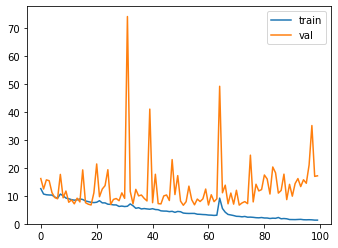

In [8]:
set_random_seeds()

model.compile(
    optimizer=Adam(), 
    loss='binary_crossentropy', 
    metrics=['accuracy', mcc]
)

metric_to_monitor = 'val_loss'
FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix='fine_tuning_merged_model_best_branches_')
early_stopping = EarlyStopping(
    monitor=metric_to_monitor, 
    mode='min', 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    FILE_MODEL, 
    monitor=metric_to_monitor, 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

class_weights = [compute_class_weights(y_train[:, i]) for i in range(y_train.shape[1])]

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.log_param("class_train", dict_train)
mlflow.log_param("class_val", dict_val)
mlflow.log_param("class_train_prop", dict_train_props)
mlflow.log_param("class_val_prop", dict_val_props)
mlflow.keras.autolog()

hist = model.fit(
    x_train, 
    np.hsplit(y_train, range(1, y_train.shape[1])), 
    batch_size=32, 
    epochs=100, 
    validation_data=(x_val, np.hsplit(y_val, range(1, y_val.shape[1]))),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
    class_weight=class_weights,
)
plot.keras_hist(hist.history)

mlflow.end_run()

# Test 

In [10]:
import cv2

list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']

im = load.images_from_list_files(list_files, output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

1 of 1


In [11]:
y_pred = model.predict(im)
for pred in y_pred:
    print(pred)

[[1.]]
[[0.4461791]]
[[1.]]
[[0.99203026]]
[[0.9999988]]
[[1.]]
[[0.06745486]]
[[0.99996746]]
[[0.9933089]]
[[0.00068906]]
[[0.87161493]]
[[0.77211964]]
[[0.33164123]]
[[0.99999034]]
[[1.]]
[[1.]]
[[0.99998367]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9758222]]
[[1.]]


In [25]:
custom_objects = {
    'matthews_correlation_coefficient': mcc,
}

model_recompiled = load_model(FILE_MODEL, custom_objects=custom_objects)
model_recompiled.compile(optimizer=Adam(), loss='binary_crossentropy')
model_recompiled.save(FILE_MODEL)

y_pred_1 = model.predict(x_val)
y_pred_2 = model_recompiled.predict(x_val)

assert(np.allclose(y_pred_1, y_pred_2))

In [26]:
merged_model = load_model(FILE_MODEL)
y_pred = merged_model.predict(im)
for pred in y_pred:
    print(pred)

[[1.]]
[[0.4461791]]
[[1.]]
[[0.99203026]]
[[0.9999988]]
[[1.]]
[[0.06745486]]
[[0.99996746]]
[[0.9933089]]
[[0.00068906]]
[[0.87161493]]
[[0.77211964]]
[[0.33164123]]
[[0.99999034]]
[[1.]]
[[1.]]
[[0.99998367]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9758222]]
[[1.]]


In [14]:
custom_objects = {
    'matthews_correlation_coefficient': mcc,
}

model_1 = load_model('C:/Users/arnal/Downloads/model.h5', custom_objects=custom_objects)
model_2 = load_model(FILE_MODEL)

y_pred_1 = model_1.predict(x_val)
y_pred_2 = model_2.predict(x_val)

assert(np.allclose(y_pred_1, y_pred_2))

AssertionError: 

In [22]:
model_1.save(FILE_MODEL)